# AgPV Index
Exploratory data analysis for creation of an AG PV index: a composite scoring metric to identify USA counties with high cobenefits potential for agrivoltaics

* Data inputs: solar supply, weather hazards, energy burden, minority owned cropland

## Data Processing
Things to do:

* ~aggregate NREL's solar supply data by county~
* ~get relevant weather hazards data from csv file (hail and drought are positives, tornado is negative.)~
    * might start ith overall agriculture burden for positives first
* ~load energy burden data~
* ~get minoirty owned data from R2R indices to start~
* Estimate fraction of energy coops in county
    * from Energy Information Administration. Need to combine several of provided datasets:
    * Power generated/customers served by each utility, Counties each utility services, FIPS info
* Suitable crops for ag pv
* [True land footprint of solar energy](https://betterenergy.org/blog/the-true-land-footprint-of-solar-energy/)
* 8-year slope values for each state's electricity (quads)
* C-intensity of electricity for most recent year (2022) divided by the electricity (quads)
 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import regex as re

from usda_qwikstats_utils import usda_qwikstats_utils
from qwi_utils import qwi_utils
from config import usda_qwik_stats_key, qwi_key
from requests import get
from typing import Callable, Union

data_dir = 'AgPV_data'
export_dir = 'Export_data'
graph_dir = 'AgPV_graphs'

# USDA Qwik stats
Crops like beets, tomatoes, peppers, and leafy greens seem to do well with agPV. e want to find counties with high amounts/percentages of crop area for these crops (beets, potatoes, radishes, tomatoes, peppers, carrots, spinach, lettuce, all berries, goats, and sheep)

May have to calculate livestock and crops seperately. I believe crops can be measured in area, but livestock might be measured in heads.



In [2]:
veggie_commodities = ['beets', 'potatoes', 'radishes', 'tomatoes', 'peppers', 'carrots', 'spinach', 'lettuce']

usda_search_params = {'year':'2022',
                      'agg_level':'county',
                      'source_desc':'census',
                      'statisticcat_desc': 'Area Harvested',
                      'format':'JSON'
                     }

usda_utils = usda_qwikstats_utils(usda_qwik_stats_key)

def get_usda_dfs(commodity: str, search_params:dict = usda_search_params, usda_utils:usda_qwikstats_utils = usda_utils) -> pd.DataFrame:
    '''Returns pandas df for the commodity searched for'''
    print(f'Getting {commodity.title()} Data...')
    
    params_copy = search_params
    
    if 'commodity_desc' not in params_copy.keys():
        params_copy['commodity_desc'] = commodity
        
    # make api call
    r = usda_utils.get_qwikstats_data(params_copy)
    
    
    try:
        data = r.json()['data']
        return pd.DataFrame(data)
    
    except Exception as e:
        print(e)
        print(r.text)


veggies_dfs = [get_usda_dfs(commodity) for commodity in veggie_commodities]

veggies_df = pd.concat(veggies_dfs)
veggies_df.head()

Getting Beets Data...
Getting Potatoes Data...
Getting Radishes Data...
Getting Tomatoes Data...
Getting Peppers Data...
Getting Carrots Data...
Getting Spinach Data...
Getting Lettuce Data...


freq_desc statisticcat_desc county_ansi               short_desc  \
0    ANNUAL    AREA HARVESTED              BEETS - ACRES HARVESTED   
1    ANNUAL    AREA HARVESTED              BEETS - ACRES HARVESTED   
2    ANNUAL    AREA HARVESTED              BEETS - ACRES HARVESTED   
3    ANNUAL    AREA HARVESTED              BEETS - ACRES HARVESTED   
4    ANNUAL    AREA HARVESTED              BEETS - ACRES HARVESTED   

  state_alpha commodity_desc begin_code  group_desc country_code sector_desc  \
0          US          BEETS         00  VEGETABLES         9000       CROPS   
1          US          BEETS         00  VEGETABLES         9000       CROPS   
2          US          BEETS         00  VEGETABLES         9000       CROPS   
3          US          BEETS         00  VEGETABLES         9000       CROPS   
4          US          BEETS         00  VEGETABLES         9000       CROPS   

   ... unit_desc watershed_code  location_desc         util_practice_desc  \
0  ...     ACRES       00000000       US TOTAL  ALL UTILIZATION PRACTICES   
1  ...     ACRES       00000000       US TOTAL  ALL UTILIZATION PRACTICES   
2  ...     ACRES       00000000       US TOTAL  ALL UTILIZATION PRACTICES   
3  ...     ACRES       00000000       US TOTAL  ALL UTILIZATION PRACTICES   
4  ...     ACRES       00000000       US TOTAL  ALL UTILIZATION PRACTICES   

                                 domain_desc source_desc   country_name  \
0  AREA HARVESTED, FRESH MARKET & PROCESSING      CENSUS  UNITED STATES   
1  AREA HARVESTED, FRESH MARKET & PROCESSING      CENSUS  UNITED STATES   
2  AREA HARVESTED, FRESH MARKET & PROCESSING      CENSUS  UNITED STATES   
3  AREA HARVESTED, FRESH MARKET & PROCESSING      CENSUS  UNITED STATES   
4  AREA HARVESTED, FRESH MARKET & PROCESSING      CENSUS  UNITED STATES   

  county_code week_ending end_code  
0                               00  
1                               00  
2                               00  
3                               00  
4                               00  

[5 rows x 39 columns]

In [296]:
veggies_df.loc[veggies_df.state_alpha == 'AK', :].columns

Index(['freq_desc', 'statisticcat_desc', 'county_ansi', 'short_desc',
       'state_alpha', 'commodity_desc', 'begin_code', 'group_desc',
       'country_code', 'sector_desc', 'load_time', 'congr_district_code',
       'year', 'watershed_desc', 'county_name', 'domaincat_desc', 'zip_5',
       'prodn_practice_desc', 'reference_period_desc', 'asd_code',
       'agg_level_desc', 'region_desc', 'class_desc', 'state_name', 'CV (%)',
       'asd_desc', 'Value', 'state_ansi', 'state_fips_code', 'unit_desc',
       'watershed_code', 'location_desc', 'util_practice_desc', 'domain_desc',
       'source_desc', 'country_name', 'county_code', 'week_ending',
       'end_code'],
      dtype='object')

In [287]:
def clean_usda_values(df: pd.DataFrame, suffix: str, domain_desc: str = 'TOTAL', fill_method: Union[Callable, int, float] = 0) -> pd.DataFrame:
    """
    Process the raw values returned from usda api results df. 
    
    -Filters for just county data
    -Creates specific column labeling data that was undisclosed
    -Removes ',' from numbers
    -Sets (D) and (Z) values to 0
    -Converts 'Value' column to numeric
    """
    if 'agg_level_desc' in df.columns:
        county_df = df.loc[df['agg_level_desc'] == 'COUNTY', :]
    elif 'Geo Level' in df.columns:
        county_df = df.loc[df['Geo Level'] == 'COUNTY', :]
    else:
        county_df = df.copy()
        
    if domain_desc is not None and 'domain_desc' in county_df.columns:
        county_df = county_df.loc[county_df['domain_desc'] == domain_desc]
        
    county_df.loc[:, [f'Undisclosed_{suffix}']] = county_df['Value'].apply(lambda x: x.strip().upper() == '(D)')
    county_df.loc[:, 'Value'] = county_df['Value'].apply(lambda x: x.strip().replace(',',''))
    county_df.loc[county_df['Value'] =='(Z)', 'Value'] = 0
    
    if isinstance(fill_method, Callable):
        county_df.loc[county_df['Value'] =='(D)', 'Value'] = fill_method(county_df.Value)
    else:
        county_df.loc[county_df['Value'] =='(D)', 'Value'] = fill_method
        
    county_df.loc[:, 'Value'] = county_df['Value'].astype(int, errors='ignore')
    
    return county_df
    
veggies_clean_df = clean_usda_values(veggies_df, 'veggies')
veggies_clean_df = veggies_clean_df.loc[(veggies_clean_df['unit_desc'] == 'ACRES') & \
                                        (veggies_clean_df['util_practice_desc'] == 'ALL UTILIZATION PRACTICES'), :]

veggies_sum_df = veggies_clean_df.groupby(['state_fips_code', 'county_code']).sum()[['Value', 'Undisclosed_veggies']]
veggies_sum_df = veggies_sum_df.reset_index()
veggies_sum_df['FIPS'] = veggies_sum_df['state_fips_code'] + veggies_sum_df['county_code']
veggies_sum_df = veggies_sum_df[['FIPS', 'Value', 'Undisclosed_veggies']]
veggies_sum_df.sort_values('Value', ascending=False)

FIPS  Value  Undisclosed_veggies
76    06083  12824                    0
1393  55071   5128                    0
87    06111   5016                    0
264   17175   4320                    0
1315  53057   3240                    0
...     ...    ...                  ...
606   27153      0                    8
612   27173      0                    8
614   28013      0                    8
615   28023      0                    8
1433  56045      0                    8

[1434 rows x 3 columns]

In [288]:
veggies_sum_df[[x[:2] == '02' for x in veggies_sum_df.FIPS]]

FIPS Value  Undisclosed_veggies
14  02010     0                    0
15  02020    64                    0
16  02090    24                    0
17  02110     0                    0
18  02122    24                    0

In [289]:
veggies_clean_df.loc[veggies_clean_df.state_ansi == '02', 'county_code']

21    090
22    020
23    122
24    110
25    010
21    090
22    020
23    122
24    110
25    010
21    090
22    020
23    122
24    110
25    010
21    090
22    020
23    122
24    110
25    010
21    090
22    020
23    122
24    110
25    010
21    090
22    020
23    122
24    110
25    010
21    090
22    020
23    122
24    110
25    010
21    090
22    020
23    122
24    110
25    010
Name: county_code, dtype: object

In [300]:
veggies_df.loc[veggies_df.state_ansi=='02', :].iloc[:, :]

agg_level_desc region_desc   class_desc state_name CV (%)  \
21           COUNTY              ALL CLASSES     ALASKA    (L)   
22           COUNTY              ALL CLASSES     ALASKA    (L)   
23           COUNTY              ALL CLASSES     ALASKA    (L)   
24           COUNTY              ALL CLASSES     ALASKA    (L)   
25           COUNTY              ALL CLASSES     ALASKA    (L)   
...             ...         ...          ...        ...    ...   
6125          STATE              ALL CLASSES     ALASKA    (L)   
6174         COUNTY              ALL CLASSES     ALASKA    (L)   
6175         COUNTY              ALL CLASSES     ALASKA    (L)   
6176         COUNTY              ALL CLASSES     ALASKA    (L)   
6422          STATE              ALL CLASSES     ALASKA    (L)   

                         asd_desc                 Value state_ansi  \
21                  TANANA VALLEY                     3         02   
22    MATANUSKA-SUSITNA-ANCHORAGE                     8         02   
23                KENAI PENINSULA                     3         02   
24                      SOUTHEAST                   (Z)         02   
25               SOUTHWEST & WEST                   (Z)         02   
...                           ...                   ...        ...   
6125                                                  1         02   
6174  MATANUSKA-SUSITNA-ANCHORAGE                     2         02   
6175              KENAI PENINSULA                     4         02   
6176                    SOUTHEAST                     3         02   
6422                                                  9         02   

     state_fips_code   unit_desc watershed_code  \
21                02       ACRES       00000000   
22                02       ACRES       00000000   
23                02       ACRES       00000000   
24                02       ACRES       00000000   
25                02       ACRES       00000000   
...              ...         ...            ...   
6125              02       ACRES       00000000   
6174              02  OPERATIONS       00000000   
6175              02  OPERATIONS       00000000   
6176              02  OPERATIONS       00000000   
6422              02  OPERATIONS       00000000   

                                       location_desc  \
21       ALASKA, TANANA VALLEY, FAIRBANKS NORTH STAR   
22    ALASKA, MATANUSKA-SUSITNA-ANCHORAGE, ANCHORAGE   
23          ALASKA, KENAI PENINSULA, KENAI PENINSULA   
24                         ALASKA, SOUTHEAST, JUNEAU   
25        ALASKA, SOUTHWEST & WEST, ALEUTIAN ISLANDS   
...                                              ...   
6125                                          ALASKA   
6174  ALASKA, MATANUSKA-SUSITNA-ANCHORAGE, ANCHORAGE   
6175        ALASKA, KENAI PENINSULA, KENAI PENINSULA   
6176                       ALASKA, SOUTHEAST, JUNEAU   
6422                                          ALASKA   

             util_practice_desc domain_desc source_desc   country_name  \
21    ALL UTILIZATION PRACTICES       TOTAL      CENSUS  UNITED STATES   
22    ALL UTILIZATION PRACTICES       TOTAL      CENSUS  UNITED STATES   
23    ALL UTILIZATION PRACTICES       TOTAL      CENSUS  UNITED STATES   
24    ALL UTILIZATION PRACTICES       TOTAL      CENSUS  UNITED STATES   
25    ALL UTILIZATION PRACTICES       TOTAL      CENSUS  UNITED STATES   
...                         ...         ...         ...            ...   
6125                 PROCESSING       TOTAL      CENSUS  UNITED STATES   
6174                 PROCESSING       TOTAL      CENSUS  UNITED STATES   
6175                 PROCESSING       TOTAL      CENSUS  UNITED STATES   
6176                 PROCESSING       TOTAL      CENSUS  UNITED STATES   
6422                 PROCESSING       TOTAL      CENSUS  UNITED STATES   

     county_code week_ending end_code  
21           090                   00  
22           020                   00  
23           122                   00  
24           110                   0

In [303]:
score_df.loc['08065', :]

state                                              NaN
county                                             NaN
capacity_mw_dc                                     NaN
Solar_supply_per_land_area                         NaN
RESL_SCORE                                   27.530001
SOVI_SCORE                                   44.810001
TRND_ALRA                                          0.0
TRND_EALA                                          0.0
HWAV_ALRA                                          0.0
HWAV_EALA                                          0.0
HAIL_ALRA                                          0.0
HAIL_EALA                                          0.0
DRGT_ALRA                                          0.0
DRGT_EALA                                          0.0
Energy Burden (% income)                           2.0
Percent Non Investor Owned                     0.00058
Value_veggies                                      NaN
Has_undisclosed_veggies                          False
Value_berr

In [306]:
# where is '08065' Lake, Colorado
solar_sums_df[solar_sums_df['FIPS'] == '08065']

Empty DataFrame
Columns: [FIPS, state, county, capacity_mw_ac, capacity_mw_dc, Solar_supply_per_land_area, ALAND_SQKM]
Index: []

### Berries
Berries have a different format

In [4]:
berry_search_params = {'year':'2022',
                              'agg_level':'county',
                              'source_desc':'census',
                              'statisticcat_desc_LIKE': 'ACRES GROWN',
                              'format':'JSON'}

berry_search_params['commodity_desc'] = 'Berry Totals'

r = usda_utils.get_qwikstats_data(berry_search_params)

berries_df = pd.DataFrame(r.json()['data'])

berries_clean_df = clean_usda_values(berries_df, 'berries')

# just keep 'acres' and 'all production practices'
berries_clean_df = berries_clean_df.loc[(berries_clean_df['unit_desc'] == 'ACRES') & (berries_clean_df['prodn_practice_desc'] == 'ALL PRODUCTION PRACTICES'),:]
berries_clean_df.head()

sector_desc country_code         group_desc begin_code commodity_desc  \
2353       CROPS         9000  FRUIT & TREE NUTS         00   BERRY TOTALS   
2354       CROPS         9000  FRUIT & TREE NUTS         00   BERRY TOTALS   
2355       CROPS         9000  FRUIT & TREE NUTS         00   BERRY TOTALS   
2356       CROPS         9000  FRUIT & TREE NUTS         00   BERRY TOTALS   
2357       CROPS         9000  FRUIT & TREE NUTS         00   BERRY TOTALS   

     state_alpha                  short_desc county_ansi statisticcat_desc  \
2353          AL  BERRY TOTALS - ACRES GROWN         033        AREA GROWN   
2354          AL  BERRY TOTALS - ACRES GROWN         059        AREA GROWN   
2355          AL  BERRY TOTALS - ACRES GROWN         077        AREA GROWN   
2356          AL  BERRY TOTALS - ACRES GROWN         079        AREA GROWN   
2357          AL  BERRY TOTALS - ACRES GROWN         083        AREA GROWN   

     freq_desc  ...   country_name         util_practice_desc  \
2353    ANNUAL  ...  UNITED STATES  ALL UTILIZATION PRACTICES   
2354    ANNUAL  ...  UNITED STATES  ALL UTILIZATION PRACTICES   
2355    ANNUAL  ...  UNITED STATES  ALL UTILIZATION PRACTICES   
2356    ANNUAL  ...  UNITED STATES  ALL UTILIZATION PRACTICES   
2357    ANNUAL  ...  UNITED STATES  ALL UTILIZATION PRACTICES   

                             location_desc watershed_code  unit_desc  \
2353     ALABAMA, NORTHERN VALLEY, COLBERT       00000000      ACRES   
2354    ALABAMA, NORTHERN VALLEY, FRANKLIN       00000000      ACRES   
2355  ALABAMA, NORTHERN VALLEY, LAUDERDALE       00000000      ACRES   
2356    ALABAMA, NORTHERN VALLEY, LAWRENCE       00000000      ACRES   
2357   ALABAMA, NORTHERN VALLEY, LIMESTONE       00000000      ACRES   

     state_ansi state_fips_code Value         asd_desc Undisclosed_berries  
2353         01              01     0  NORTHERN VALLEY                True  
2354         01              01     2  NORTHERN VALLEY               False  
2355         01              01     7  NORTHERN VALLEY               False  
2356         01              01     6  NORTHERN VALLEY               False  
2357         01              01    12  NORTHERN VALLEY               False  

[5 rows x 40 columns]

In [5]:
berries_clean_df['domaincat_desc'].value_counts()

domaincat_desc
NOT SPECIFIED    2406
Name: count, dtype: int64

In [6]:
berries_sum_df = berries_clean_df.groupby(['state_ansi', 'county_ansi']).sum()
berries_sum_df = berries_sum_df.reset_index()
berries_sum_df['FIPS'] = berries_sum_df['state_ansi'] + berries_sum_df['county_ansi']
berries_sum_df = berries_sum_df[['FIPS', 'Value', 'Undisclosed_berries']]
berries_sum_df.sort_values('Value', ascending=False)

FIPS  Value  Undisclosed_berries
944   23029  35203                    0
172   06083  18548                    0
185   06111  17443                    0
2268  53073  16302                    0
158   06053  14368                    0
...     ...    ...                  ...
1706  40147      0                    1
697   19129      0                    1
694   19123      0                    1
691   19117      0                    1
2401  56043      0                    1

[2402 rows x 3 columns]

### Goats and Sheep
Goats and sheep don't have acres available

In [7]:
sheep_goats_path = '68E1129D-0FD5-3FC4-A812-EF6D3EBE6718.csv'

sheep_goats_df = pd.read_csv(os.path.join(data_dir, sheep_goats_path), dtype={'State ANSI':str, 'County ANSI':str})

sheep_goats_clean_df = clean_usda_values(sheep_goats_df, 'goats_sheep_totals')
sheep_goats_clean_df['FIPS'] = sheep_goats_clean_df['State ANSI'] + sheep_goats_clean_df['County ANSI']
sheep_goats_clean_df = sheep_goats_clean_df[['FIPS', 'Value', 'Undisclosed_goats_sheep_totals']]
sheep_goats_clean_df = sheep_goats_clean_df.rename(columns={'Value':'Sheep_goats_total_sales'})
sheep_goats_clean_df.sort_values('Sheep_goats_total_sales', ascending=False)

FIPS Sheep_goats_total_sales  Undisclosed_goats_sheep_totals
233   08123                58383000                           False
179   06095                14990000                           False
2501  48105                13455000                           False
2885  55015                12850000                           False
185   06029                12590000                           False
...     ...                     ...                             ...
869   20123                       0                            True
1352  28071                       0                            True
1362  28139                       0                            True
2480  48185                       0                            True
454   13049                       0                            True

[2967 rows x 3 columns]

In [8]:
sheep_goats_demo_df = pd.read_csv(os.path.join(data_dir, 'sheep_goats_minority.csv'), dtype={'State ANSI':str, 'County ANSI':str})
sheep_goats_demo_df = clean_usda_values(sheep_goats_demo_df, 'goats_sheep_producers')
sheep_goats_demo_df['FIPS'] = sheep_goats_demo_df['State ANSI'] + sheep_goats_demo_df['County ANSI']
sheep_goats_demo_df = sheep_goats_demo_df[['FIPS', 'Year', 'Domain Category', 'Value', 'Undisclosed_goats_sheep_producers']]

white_value = 'PRODUCERS: (RACE = WHITE, ALONE OR COMBINED WITH OTHER RACES)'
female_value = 'PRODUCERS: (GENDER = FEMALE)'

sheep_goats_demo_df = sheep_goats_demo_df.loc[(sheep_goats_demo_df['Year'] == 2022)]

sheep_goats_demo_df = sheep_goats_demo_df.loc[sheep_goats_demo_df['Domain Category'].isin([white_value, female_value]), ['FIPS', 'Domain Category', 'Value']]
sheep_goats_demo_df = sheep_goats_demo_df.pivot_table(values='Value', index='FIPS', columns='Domain Category')
sheep_goats_demo_df['Percent Nonwhite Sheep Goats Producers'] = 100 - sheep_goats_demo_df[white_value]
sheep_goats_demo_df = sheep_goats_demo_df.rename(columns={female_value:'Percent Woman-owned Sheep Goats Producers'})
sheep_goats_demo_df = sheep_goats_demo_df.drop(columns=white_value)
sheep_goats_demo_df = sheep_goats_demo_df.fillna(0).reset_index()

sheep_goats_demo_df

Domain Category   FIPS  Percent Woman-owned Sheep Goats Producers  \
0                01001                                       18.0   
1                01003                                       11.0   
2                01005                                       87.0   
3                01007                                       19.0   
4                01009                                       96.0   
...                ...                                        ...   
2994             56037                                       79.0   
2995             56039                                       68.0   
2996             56041                                       94.0   
2997             56043                                       63.0   
2998             56045                                       98.0   

Domain Category  Percent Nonwhite Sheep Goats Producers  
0                                                  73.0  
1                                                   0.0  
2                                                  11.0  
3                                                   0.0  
4                                                   0.0  
...                                                 ...  
2994                                                0.0  
2995                                                0.0  
2996                                                0.0  
2997                                                0.0  
2998                                                0.0  

[2999 rows x 3 columns]

In [9]:
# berries and veggies can be added together since they're both in acres. Goats/sheep are in $
crops_sum_df = veggies_sum_df.merge(berries_sum_df, on='FIPS', suffixes=('_veggies', '_berries'), how='outer')
crops_sum_df['AgPV_crop_totals'] = crops_sum_df['Value_veggies'] + crops_sum_df['Value_berries']
crops_sum_df

FIPS Value_veggies  Undisclosed_veggies Value_berries  \
0     01003             0                  8.0           117   
1     01017             0                  8.0            10   
2     01019             0                  8.0            16   
3     01049             0                  8.0            14   
4     01063             0                  8.0             0   
...     ...           ...                  ...           ...   
2496  55083           NaN                  NaN            26   
2497  55107           NaN                  NaN             0   
2498  55121           NaN                  NaN            33   
2499  56003           NaN                  NaN             0   
2500  56041           NaN                  NaN             0   

      Undisclosed_berries AgPV_crop_totals  
0                     0.0              117  
1                     0.0               10  
2                     0.0               16  
3                     0.0               14  
4                     1.0                0  
...                   ...              ...  
2496                  0.0              NaN  
2497                  1.0              NaN  
2498                  0.0              NaN  
2499                  1.0              NaN  
2500                  1.0              NaN  

[2501 rows x 6 columns]

### Solar Panel Land Use
Land that isn't currently occupied by lots of solar panels. People might be more amenable to development if the landscape isn't already cluttered by existing solar panels

In [10]:
solar_land_path = os.path.join(data_dir, 'solar_panel_land_use.csv')
solar_land_df = pd.read_csv(solar_land_path, dtype={'FIPS':str})
solar_land_df = solar_land_df[['FIPS', 'SolarPanelLandUse']]
solar_land_df.head()

FIPS  SolarPanelLandUse
0  01001               0.05
1  01003               0.05
2  01005               0.05
3  01007               0.05
4  01009               0.05

In [206]:
crops_sum_df.loc[crops_sum_df['FIPS'].isin(['15001']), :]

FIPS Value_veggies  Undisclosed_veggies Value_berries  \
195  15001            40                  0.0             0   

     Undisclosed_berries AgPV_crop_totals  
195                  1.0               40

### Solar Supply Data NREL

Commonly cited NREL data for solar supply. I'm aggregating this by county.

https://www.nrel.gov/gis/solar-resource-maps.html

In [185]:
# got solar supply data
solar_dir = 'solar-pv-reference-access-2023'
solar_file = 'reference_access_2030_moderate_supply-curve.csv'

solar_df = pd.read_csv(os.path.join(solar_dir, solar_file), dtype={'cnty_fips':str})
solar_df['cnty_fips'] = solar_df['cnty_fips'].apply(lambda x: x.zfill(5))

# get total for each county
location_cols = ['cnty_fips', 'county', 'state']
solar_sums_df = solar_df.groupby(location_cols, as_index=False).sum()

# I think we just need capacity_mw_ac
solar_sums_df = solar_sums_df[location_cols + ['capacity_mw_ac', 'capacity_mw_dc']]

# rename fips column
solar_sums_df = solar_sums_df.rename(columns={'cnty_fips':'FIPS'})

# merge with land area. Need this because we want total land area, not just available solar land area in the NREL dataset
km2_per_mi2 = 2.58999
land_area_df = pd.read_csv(os.path.join(data_dir, '2024_Gaz_counties_national.txt'), delimiter='\t', dtype={'GEOID':str})
land_area_df = land_area_df.rename(columns={'GEOID':'FIPS'})
land_area_df['ALAND_SQKM'] = km2_per_mi2 * land_area_df['ALAND_SQMI']

solar_sums_df = solar_sums_df.merge(land_area_df, on='FIPS')
solar_sums_df['Solar_supply_per_land_area'] = solar_sums_df['capacity_mw_ac'] / solar_sums_df['ALAND_SQKM']

# keep only relevant columns
solar_sums_df = solar_sums_df[['FIPS', 'state', 'county', 'capacity_mw_ac', 'capacity_mw_dc', 'Solar_supply_per_land_area', 'ALAND_SQKM']]
solar_sums_df.head()

FIPS    state   county  capacity_mw_ac  capacity_mw_dc  \
0  01001  Alabama  Autauga    22349.202978    29947.935193   
1  01003  Alabama  Baldwin    46948.973155    62911.632997   
2  01005  Alabama  Barbour    43344.657028    58081.848135   
3  01007  Alabama     Bibb    28368.690972    38014.050777   
4  01009  Alabama   Blount    18483.385380    24767.738851   

   Solar_supply_per_land_area   ALAND_SQKM  
0                   14.515933  1539.632505  
1                   11.401515  4117.783661  
2                   18.909946  2292.161870  
3                   17.596358  1612.191075  
4                   11.066164  1670.261241

Text(0.5, 0.98, 'Solar Supply vs County Land Area')

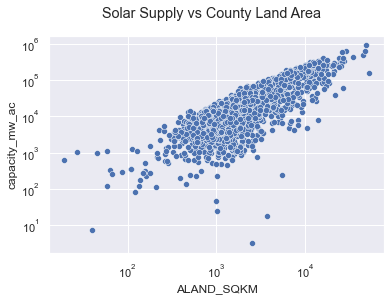

In [190]:
# correlation between solar supply and land area? I bet there is
sns.scatterplot(solar_sums_df, x='ALAND_SQKM', y='capacity_mw_ac')

plt.yscale('log')
plt.xscale('log')
plt.suptitle('Solar Supply vs County Land Area')

Text(0.5, 0.98, 'Solar Supply vs Land Area')

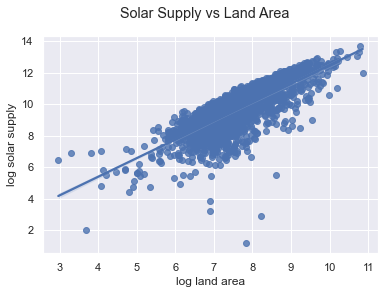

In [192]:
solar_plot_df = solar_sums_df.copy()
solar_plot_df['log solar supply'] = np.log(solar_plot_df['capacity_mw_ac'])
solar_plot_df['log land area'] = np.log(solar_plot_df['ALAND_SQKM'])

sns.regplot(solar_plot_df, x='log land area', y='log solar supply')
plt.suptitle('Solar Supply vs Land Area')

Text(0.5, 0, 'MW per Sq Km')

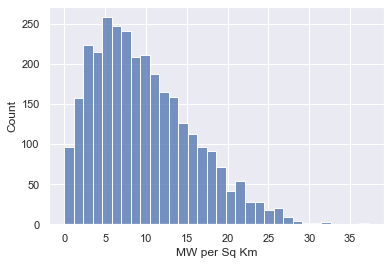

In [195]:
sns.histplot(solar_plot_df, x='Solar_supply_per_land_area')
plt.xlabel('MW per Sq Km')

### NRI Weather hazards data

FEMA has created weather hazard index scores for various weather hazards. Right now, I'm only focusing on how these hazards affect agricultural losses. For AgPV, tornadoes are negative, since they destroy solar panels. Drought, hail, and heatwave are positives, since AgPV can help protect crops or diversify farmer income hagainst these hazards.

Relevant columns:

* TRND_ALRA: expected tornado ag loss rate
* HWAV_ALRA: heatwave expected ag loss rate
* HAIL_ALRA: hail expected ag loss rate
* DRGT_ALRA: drought expected loss
* RESL_SCORE: community resilience score
* SOVI_SCORE: sovial vulnerability score
* _EALA: Expected anual Loss

can use different suffixes for different metrics. Other metrics of interest:
* RISKV: risk value
* RISKS: risk index score
* RISKR: risk index rating

https://hazards.fema.gov/nri

In [79]:
nri_dir = 'NRI_Table_Counties'
nri_file = 'NRI_Table_Counties.csv'

nri_df = pd.read_csv(os.path.join(data_dir, nri_dir, nri_file), dtype={'STCOFIPS':str})

# keep relevant columns
prefixes = ['TRND', 'HWAV', 'HAIL', 'DRGT']
suffixes = ['ALRA', 'EALA', 'RISKV', 'RISKS']
nri_keep_cols = ['_'.join([pf, sf]) for pf in prefixes for sf in suffixes]

nri_df = nri_df[['STCOFIPS', 'RESL_SCORE', 'SOVI_SCORE'] + nri_keep_cols]

# rename relevant columns
nri_df = nri_df.rename(columns={'STCOFIPS':'FIPS'})
nri_df.head()

FIPS  RESL_SCORE  SOVI_SCORE  TRND_ALRA     TRND_EALA    TRND_RISKV  \
0  01001   51.810001   51.299999   0.000029    722.769891  2.831745e+06   
1  01003   86.120003   31.030001   0.000004    620.946493  7.982720e+06   
2  01005    6.240000   99.269997   0.000009   1074.005284  2.845056e+06   
3  01007   19.730000   80.779999   0.000067    324.869968  2.609927e+06   
4  01009   22.820000   51.369999   0.000077  21587.960390  6.930682e+06   

   TRND_RISKS     HWAV_ALRA    HWAV_EALA    HWAV_RISKV  HWAV_RISKS  \
0   73.846643  2.747418e-06    67.624948  8.799794e+05   87.082405   
1   91.377665  9.080529e-07   125.392132  1.243722e+06   91.091314   
2   73.942094  2.747418e-06   332.645749  2.821581e+05   69.710468   
3   71.969456  4.200027e-06    20.241424  2.428259e+05   67.228762   
4   89.723194  4.200027e-06  1170.005046  6.368582e+05   82.437162   

      HAIL_ALRA    HAIL_EALA     HAIL_RISKV  HAIL_RISKS  DRGT_ALRA  \
0  4.687348e-05  1153.743797  152041.957165   57.111040   0.000826   
1  2.308179e-07    31.873420  124028.950214   52.943048   0.003216   
2  4.524451e-06   547.801324   68324.832750   39.993637   0.001623   
3  2.179460e-04  1050.359255   81868.702495   43.684378   0.000831   
4  1.966831e-05  5479.019058   82093.176164   43.716195   0.000093   

       DRGT_EALA     DRGT_RISKV  DRGT_RISKS  
0   20330.149968   28542.388900   50.652243  
1  444140.578012  484573.697842   86.796055  
2  196489.739432  295053.353506   80.687241  
3    4005.514889    4764.186212   32.421254  
4   25903.218298   32581.621879   52.147630

### Energy Burden

Percent of household income spent on energy. AgPV can help high burden counties lower their energy burden.

https://www.energy.gov/scep/slsc/lead-tool

In [49]:
eburden_file = 'LEAD Tool Data Counties.csv'

eburden_df = pd.read_csv(os.path.join(data_dir, eburden_file), skiprows=range(0,8), dtype={'Geography ID':str})
eburden_df = eburden_df.rename(columns={'Geography ID':'FIPS'})
eburden_df = eburden_df[['FIPS', 'Energy Burden (% income)']]
eburden_df.head()

FIPS  Energy Burden (% income)
0  01001                         3
1  01003                         2
2  01005                         4
3  01007                         4
4  01009                         3

### R2R Data

Farmer income and % of minority owned cropland analyzed for Roads to Removal. Don't get too sad at the minority owned farm numbers.

In [50]:
usda_search_params

{'year': '2022',
 'agg_level': 'county',
 'source_desc': 'census',
 'statisticcat_desc': 'Area Harvested',
 'format': 'JSON',
 'commodity_desc': 'beets'}

In [80]:
avg_farm_income_search = {'year':'2022',
                          'commodity_desc': 'INCOME, NET CASH FARM',
                          'domain_desc': 'TOTAL',
                          'agg_level': 'county',
                          'format': 'JSON',
                         'source_desc': 'census',
                         'statisticcat_desc': 'NET INCOME',
                         'short_desc': 'INCOME, NET CASH FARM, OF OPERATIONS - NET INCOME, MEASURED IN $ / OPERATION'}

def get_usda_economic_data(params: dict, suffix: str, domain_desc: str='TOTAL', fill_method: Union[Callable, int, float] = 0):
    try:
        # get data
        r = usda_utils.get_qwikstats_data(params)
        df = pd.DataFrame(r.json()['data'])
    except Exception as e:
        print(e)
        print(r)
        print(r.text)
        return None
    
    # clean data
    clean_df = clean_usda_values(df, suffix, domain_desc, fill_method=fill_method)
    clean_df['FIPS'] = clean_df['state_ansi'] + clean_df['county_ansi']
    
    return clean_df
    
clean_income_df = get_usda_economic_data(avg_farm_income_search, 'farm_income', fill_method=max)
clean_income_df = clean_income_df[['FIPS', 'Value', 'Undisclosed_farm_income']]
clean_income_df['Value'] = clean_income_df['Value'].astype(int)
clean_income_df = clean_income_df.rename(columns={'Value':'Avg Farm Net Income ($)'})
clean_income_df = clean_income_df.drop_duplicates(subset='FIPS', keep=False)
clean_income_df

FIPS  Avg Farm Net Income ($)  Undisclosed_farm_income
0     01033                    20282                    False
1     01059                    99691                    False
2     01077                    23117                    False
3     01079                    83570                    False
4     01083                    50169                    False
...     ...                      ...                      ...
3073  56009                    16519                    False
3074  56015                    49129                    False
3075  56021                    34674                    False
3076  56027                    55195                    False
3077  56031                    29982                    False

[3073 rows x 3 columns]

In [81]:
minority_cropland_search = {'year':'2022',
                          'commodity_desc': 'AG LAND',
                          'domain_desc': 'PRODUCERS',
                          'agg_level': 'county',
                          'format': 'JSON',
                         'source_desc': 'census',
                         'short_desc': 'AG LAND, CROPLAND - AREA, MEASURED IN PCT OF AG LAND'}

clean_minority_crop_df = get_usda_economic_data(minority_cropland_search, 'minority_crop', 'PRODUCERS', fill_method=0)
clean_minority_crop_df = clean_minority_crop_df[['FIPS', 'domaincat_desc', 'Value', 'Undisclosed_minority_crop']]
clean_minority_crop_df['Value'] = clean_minority_crop_df['Value'].astype(float)
clean_minority_crop_df = clean_minority_crop_df.rename(columns={'Value':'Percent'})

# Filter data and make calculations
domaincats = ['PRODUCERS: (GENDER = FEMALE)', 'PRODUCERS: (RACE = WHITE, ALONE OR COMBINED WITH OTHER RACES)']
filtered_minority_crop_df = clean_minority_crop_df.loc[clean_minority_crop_df['domaincat_desc'].isin(domaincats), :]
filtered_minority_crop_df = filtered_minority_crop_df.pivot_table(values=['Percent', 'Undisclosed_minority_crop'], index='FIPS', columns='domaincat_desc')
filtered_minority_crop_df[('Percent', 'Non-white')] =  100 - filtered_minority_crop_df[('Percent', 'PRODUCERS: (RACE = WHITE, ALONE OR COMBINED WITH OTHER RACES)')]
minority_crop_percents = filtered_minority_crop_df['Percent']
minority_crop_percents = minority_crop_percents.rename(columns={'PRODUCERS: (GENDER = FEMALE)': 'Percent Woman-owned Cropland',
                                                                'Non-white': 'Percent Non-white Cropland'})
minority_crop_percents = minority_crop_percents.drop(columns=['PRODUCERS: (RACE = WHITE, ALONE OR COMBINED WITH OTHER RACES)'])
minority_crop_percents = minority_crop_percents.fillna(0)
minority_crop_percents = minority_crop_percents.reset_index()
minority_crop_percents

domaincat_desc   FIPS  Percent Woman-owned Cropland  \
0               01001                          32.0   
1               01003                          33.0   
2               01005                          28.0   
3               01007                          21.0   
4               01009                          24.0   
...               ...                           ...   
2995            56037                          13.0   
2996            56039                          29.0   
2997            56041                          11.0   
2998            56043                          17.0   
2999            56045                           3.0   

domaincat_desc  Percent Non-white Cropland  
0                                     68.0  
1                                      0.0  
2                                     74.0  
3                                      0.0  
4                                      0.0  
...                                    ...  
2995                                   0.0  
2996                                   0.0  
2997                                   0.0  
2998                                   0.0  
2999                                   0.0  

[3000 rows x 3 columns]

In [82]:
minority_crop_percents[minority_crop_percents.index.duplicated()]

Empty DataFrame
Columns: [FIPS, Percent Woman-owned Cropland, Percent Non-white Cropland]
Index: []

In [54]:
pastureland_search = {'year':'2022',
                      'commodity_desc': 'AG LAND',
                      'domain_desc': 'TOTAL',
                      'sector_desc': 'ECONOMICS',
                      'group_desc_LIKE': 'FARM & LAND & ASSETS',
                      'agg_level': 'county',
                      'format': 'JSON',
                      'source_desc': 'census',
                      #'statisticcat_desc':'AREA',
                      'short_desc__LIKE': 'AG LAND, PASTURE'}

clean_pastureland_df = pd.read_csv(os.path.join(data_dir, 'pastureland.csv'), dtype={'State ANSI':str, 'County ANSI': str})
clean_pastureland_df = clean_usda_values(clean_pastureland_df, 'pastureland')
clean_pastureland_df['FIPS'] = clean_pastureland_df['State ANSI'] + clean_pastureland_df['County ANSI']
clean_pastureland_df = clean_pastureland_df.loc[clean_pastureland_df['Data Item'] == 'AG LAND, PASTURELAND, (EXCL CROPLAND & WOODLAND) - ACRES']
clean_pastureland_df = clean_pastureland_df[['FIPS', 'Value', 'Undisclosed_pastureland']]
clean_pastureland_df['Value'] = clean_pastureland_df['Value'].astype(float)
clean_pastureland_df = clean_pastureland_df.rename(columns={'Value':'Pastureland'})
clean_pastureland_df = clean_pastureland_df.drop_duplicates(subset='FIPS', keep=False)

clean_pastureland_df

FIPS  Pastureland  Undisclosed_pastureland
0     01001      19203.0                    False
1     01011      36659.0                    False
2     01047      51269.0                    False
3     01051      16007.0                    False
4     01063      19298.0                    False
...     ...          ...                      ...
3060  56031    1087705.0                    False
3061  56023     195043.0                    False
3062  56035     361742.0                    False
3063  56039      20356.0                    False
3064  56041     651079.0                    False

[3060 rows x 3 columns]

In [55]:
clean_pastureland_df[clean_pastureland_df['FIPS'].duplicated()]

Empty DataFrame
Columns: [FIPS, Pastureland, Undisclosed_pastureland]
Index: []

# Energy Information Admisitration: Coop data from 2022
Counties with strong existing cooperatively owned energy generators could have a stronger foundationg for equitably adopting AgPV

Unfortunately, the data from EIA doesn't have county FIPS codes. They only have state abbreviations and county names. We'll have to do some joins to get the actual FIPS code.

In [56]:
eia_dir = 'EIA_f8612022'
meters_file = 'Advanced_Meters_2022.xlsx'
sales_file = 'Sales_Ult_Cust_2022.xlsx'
service_territory_file = 'Service_Territory_2022.xlsx'

eia_sales_df = pd.read_excel(os.path.join(data_dir, eia_dir, sales_file), header=[0,1,2], nrows=2829)
eia_locations_df = pd.read_excel(os.path.join(data_dir, eia_dir, service_territory_file))

# keep only totals column from sales
eia_sales_df = eia_sales_df.loc[:, eia_sales_df.columns.get_level_values(0).isin(['Utility Characteristics', 'TOTAL'])]
eia_sales_df.columns = eia_sales_df.columns.get_level_values(-1)
eia_sales_df = eia_locations_df[['Utility Number', 'County']].merge(eia_sales_df, on='Utility Number')

# Clean case just in case there's some shenanigans
eia_sales_df['State'] = eia_sales_df['State'].apply(lambda x: x.strip().upper())
eia_sales_df['County'] = eia_sales_df['County'].apply(lambda x: x.strip().title())

# get county geo info
state_abbrevs_file = 'us-states-territories.csv'
county_file = 'US_FIPS_Codes.xls'
state_df = pd.read_csv(os.path.join(data_dir, state_abbrevs_file), encoding='unicode_escape')
state_df['Name'] = state_df['Name'].apply(lambda x: x.strip().title())

county_df = pd.read_excel(os.path.join(data_dir, county_file), header=1, dtype={'FIPS State':str, 'FIPS County':str})
county_df['State'] = county_df['State'].apply(lambda x: x.strip().title())
county_df['FIPS'] = county_df['FIPS State'] + county_df['FIPS County']

state_county_df = state_df[['Name', 'Abbreviation', 'area (square miles)']].merge(county_df[['State', 'County Name', 'FIPS']], left_on='Name', right_on='State')
state_county_df = state_county_df[['State', 'Abbreviation', 'County Name', 'FIPS', 'area (square miles)']]

state_county_df['Abbreviation'] = state_county_df['Abbreviation'].apply(lambda x: x.strip().upper())
state_county_df['County Name'] = state_county_df['County Name'].apply(lambda x: x.strip().title())
state_county_df = state_county_df.rename(columns={'County Name':'County'})

eia_sales_df = eia_sales_df.merge(state_county_df, left_on=['State', 'County'], right_on=['Abbreviation', 'County'])
keep_cols = ['FIPS', 'Ownership', 'area (square miles)', 'Thousand Dollars', 'Megawatthours', 'Count']
eia_sales_df = eia_sales_df[keep_cols]

# get percentage of non-investor-owned energy
sales_sum_df = eia_sales_df.loc[:, ['FIPS', 'Thousand Dollars', 'Megawatthours', 'Count']].groupby('FIPS', as_index=False).sum()

eia_ownership_sales_df = eia_sales_df.loc[:, ['FIPS', 'Ownership', 'Thousand Dollars', 'Megawatthours', 'Count']].groupby(['FIPS', 'Ownership'], as_index=False).sum()
sales_sum_df = eia_ownership_sales_df.merge(sales_sum_df, on='FIPS', suffixes=('', '_total'))
sales_sum_df['Percent Megawatthours'] = 100 * sales_sum_df['Megawatthours'] / sales_sum_df['Megawatthours_total']
sales_sum_df['Percent Count'] = 100 * sales_sum_df['Count'] / sales_sum_df['Count_total']

eia_percent_df = sales_sum_df.loc[sales_sum_df['Ownership'] == 'Investor Owned', :]
eia_percent_df['Percent Non Investor Owned'] = 100 - eia_percent_df['Percent Count']
eia_percent_df = eia_percent_df[['FIPS', 'Percent Non Investor Owned']]
eia_percent_df

<ipython-input-56-bc00d10825f3>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eia_percent_df['Percent Non Investor Owned'] = 100 - eia_percent_df['Percent Count']


FIPS  Percent Non Investor Owned
1     01001                    2.942734
3     01003                    9.632698
6     01005                    4.668915
8     01007                    2.942734
9     01009                    0.000000
...     ...                         ...
5286  56037                    0.003478
5289  56039                   22.753224
5290  56041                    0.000000
5293  56043                    8.685847
5295  56045                   91.119574

[2262 rows x 2 columns]

# Carbon Intensity of Electricity
Table 4. Per capita energy-related carbon dioxide emissions by state

metric tons of energy-related carbon dioxide per person

https://www.eia.gov/environment/emissions/state/

In [57]:
c_intensity_df = pd.read_excel(os.path.join(data_dir, 'table4.xlsx'), header=4)

c_intensity_df = c_intensity_df[['State', 2022]]
c_intensity_df = c_intensity_df.rename(columns={2022:'tonne_co2_per_person'})

# need to get state FIPS info from solar sums df
county_c_intensity_df = solar_sums_df.merge(c_intensity_df, left_on = 'state', right_on='State')
county_c_intensity_df = county_c_intensity_df[['FIPS', 'tonne_co2_per_person']]
county_c_intensity_df

FIPS  tonne_co2_per_person
0     01001             21.539853
1     01003             21.539853
2     01005             21.539853
3     01007             21.539853
4     01009             21.539853
...     ...                   ...
3063  56037             96.596210
3064  56039             96.596210
3065  56041             96.596210
3066  56043             96.596210
3067  56045             96.596210

[3068 rows x 2 columns]

### Ag Worker Heat Risk
This is likely to be highly correlated with the existing ag heat risk index. the plan here is to:

* get excessive heat day change due to climate change
    * https://ephtracking.cdc.gov/DataExplorer/?query=c380f325-ff71-4070-ba52-839272757eae
* multiply by qwi employment in crop and animal production to get the number of worker days exposed to excessive heat due to climate change
    * Census QWI data

In [83]:
excessive_heat_df = pd.read_csv(os.path.join(data_dir, 'excessive_heat_days_change_GWL', 'data_143828.csv'), dtype={'CountyFIPS':str, 'StateFIPS':str})
excessive_heat_df = excessive_heat_df.drop(columns='Unnamed: 7')
excessive_heat_df = excessive_heat_df.rename(columns = {'CountyFIPS':'FIPS'})
excessive_heat_df.head()

StateFIPS    State   FIPS   County                          Year  Value  \
0        01  Alabama  01001  Autauga  Point in time GWL is reached     14   
1        01  Alabama  01003  Baldwin  Point in time GWL is reached     14   
2        01  Alabama  01005  Barbour  Point in time GWL is reached     14   
3        01  Alabama  01007     Bibb  Point in time GWL is reached     13   
4        01  Alabama  01009   Blount  Point in time GWL is reached     10   

   Data Comment Absolute Threshold"Emissions Scenario"Global Warming Level  
0           NaN  Absolute Threshold: 95 degrees F"Emissions Sce...          
1           NaN  Absolute Threshold: 95 degrees F"Emissions Sce...          
2           NaN  Absolute Threshold: 95 degrees F"Emissions Sce...          
3           NaN  Absolute Threshold: 95 degrees F"Emissions Sce...          
4           NaN  Absolute Threshold: 95 degrees F"Emissions Sce...

In [84]:
def get_qwi_dfs(qwi: qwi_utils, state: str) -> pd.DataFrame:
    search_params = {'state': state,
                    'industry': ['111', '112'],
                    'time': '2022'}
    
    return qwi.make_qwi_df(**search_params)

state_fips = excessive_heat_df['StateFIPS'].unique()
qwi = qwi_utils(qwi_key)

ag_jobs_dfs = [get_qwi_dfs(qwi, state) for state in state_fips]
ag_jobs_df = pd.concat(ag_jobs_dfs)

# clean data
ag_jobs_df = ag_jobs_df.dropna(subset='Emp')
ag_jobs_df['Emp'] = ag_jobs_df['Emp'].astype(int)
ag_jobs_df = ag_jobs_df.groupby(['state','county', 'time'], as_index=False).sum()
ag_jobs_df = ag_jobs_df[['state', 'county', 'Emp']].groupby(['state','county'], as_index=False).mean()
ag_jobs_df['FIPS'] = ag_jobs_df['state'] + ag_jobs_df['county']
ag_jobs_df = ag_jobs_df[['FIPS', 'Emp']]
ag_jobs_df

Expecting value: line 1 column 1 (char 0)
<Response [204]>

Expecting value: line 1 column 1 (char 0)
<Response [204]>



FIPS     Emp
0     01001   34.50
1     01003  549.25
2     01005   53.50
3     01009   36.00
4     01011  269.00
...     ...     ...
2526  56037    3.00
2527  56039   81.00
2528  56041   22.00
2529  56043  129.00
2530  56045   36.00

[2531 rows x 2 columns]

In [85]:
worker_heat_days_df = excessive_heat_df.merge(ag_jobs_df, on='FIPS')
worker_heat_days_df['ag_worker_heat_days'] = worker_heat_days_df['Value'] * worker_heat_days_df['Emp']
worker_heat_days_df = worker_heat_days_df[['FIPS', 'ag_worker_heat_days']]
worker_heat_days_df.head()

FIPS  ag_worker_heat_days
0  01001                483.0
1  01003               7689.5
2  01005                749.0
3  01009                360.0
4  01011               3497.0

## Merge all DFs together

In [121]:
all_dfs = [solar_sums_df, 
           nri_df, 
           eburden_df, 
           eia_percent_df, 
           crops_sum_df, 
           sheep_goats_clean_df,
           sheep_goats_demo_df,
           clean_income_df,
           minority_crop_percents,
           clean_pastureland_df,
           county_c_intensity_df,
           solar_land_df,
           worker_heat_days_df
          ]

all_dfs = [df.dropna(subset='FIPS').set_index('FIPS') for df in all_dfs]
merged_df = pd.concat(all_dfs, axis=1)

# format undisclosed columns
for col in merged_df.columns:
    if re.match(r'^undisclosed_', col.lower()):
        merged_df[col] = merged_df[col] > 0
        merged_df = merged_df.rename(columns={col:'Has_' + col.lower()})
        
# label counties that nave neither livestock nor crop compatibility
merged_df['Ag_compatibility_exists'] = ~merged_df[['AgPV_crop_totals', 'Sheep_goats_total_sales']].isna().all(axis=1)

zero_fill_cols = ['Percent Non-white Cropland',
                  'Percent Woman-owned Cropland',
                  'Percent Non Investor Owned',
                  'AgPV_crop_totals', 
                  'Sheep_goats_total_sales', 
                  'Percent Nonwhite Sheep Goats Producers',
                  'Percent Woman-owned Sheep Goats Producers',
                  'Avg Farm Net Income ($)',
                  'Pastureland',
                  'ag_worker_heat_days']

merged_df[zero_fill_cols] = merged_df[zero_fill_cols].fillna(0)

env_risks = {'negative': ['TRND_EALA'],
             'positive': ['HWAV_EALA', 'HAIL_EALA', 'DRGT_EALA']
            }
eala_sums = merged_df[env_risks['positive']].sum(axis=1)
net_eala = eala_sums - merged_df[env_risks['negative']].sum(axis=1)

merged_df['eala_sum_positive'] = eala_sums
merged_df['eala_net'] = net_eala

merged_df

state   county  capacity_mw_ac  capacity_mw_dc  \
FIPS                                                      
01001  Alabama  Autauga    22349.202978    29947.935193   
01003  Alabama  Baldwin    46948.973155    62911.632997   
01005  Alabama  Barbour    43344.657028    58081.848135   
01007  Alabama     Bibb    28368.690972    38014.050777   
01009  Alabama   Blount    18483.385380    24767.738851   
...        ...      ...             ...             ...   
02232      NaN      NaN             NaN             NaN   
11031      NaN      NaN             NaN             NaN   
02010      NaN      NaN             NaN             NaN   
02         NaN      NaN             NaN             NaN   
02261      NaN      NaN             NaN             NaN   

       Solar_supply_per_land_area  RESL_SCORE  SOVI_SCORE  TRND_ALRA  \
FIPS                                                                   
01001                   14.515933   51.810001   51.299999   0.000029   
01003                   11.401515   86.120003   31.030001   0.000004   
01005                   18.909946    6.240000   99.269997   0.000009   
01007                   17.596358   19.730000   80.779999   0.000067   
01009                   11.066164   22.820000   51.369999   0.000077   
...                           ...         ...         ...        ...   
02232                         NaN         NaN         NaN        NaN   
11031                         NaN         NaN         NaN        NaN   
02010                         NaN         NaN         NaN        NaN   
02                            NaN         NaN         NaN        NaN   
02261                         NaN         NaN         NaN        NaN   

          TRND_EALA    TRND_RISKV  ...  Percent Woman-owned Cropland  \
FIPS                               ...                                 
01001    722.769891  2.831745e+06  ...                          32.0   
01003    620.946493  7.982720e+06  ...                          33.0   
01005   1074.005284  2.845056e+06  ...                          28.0   
01007    324.869968  2.609927e+06  ...                          21.0   
01009  21587.960390  6.930682e+06  ...                          24.0   
...             ...           ...  ...                           ...   
02232           NaN           NaN  ...                           0.0   
11031           NaN           NaN  ...                           0.0   
02010           NaN           NaN  ...                           0.0   
02              NaN           NaN  ...                          22.2   
02261           NaN           NaN  ...                           0.0   

       Percent Non-white Cropland  Pastureland  Has_undisclosed_pastureland  \
FIPS                                                                          
01001                        68.0      19203.0                        False   
01003                         0.0      13134.0                        False   
01005                        74.0      36564.0                        False   
01007                         0.0       8427.0                        False   
01009                         0.0      47693.0                        False   
...                           ...          ...                          ...   
02232                         0.0          0.0                        False   
11031                         0.0          0.0                        False   
02010                         0.0          0.0                        False   
02                           60.0          0.0                        False   
02261                         0.0          0.0                        False   

       tonne_co2_per_person  SolarPanelLandUse  ag_worker_heat_days  \
FIPS                                                                  
01001             21.539853               0.05                483.0   
01003             21.539853               0.05               7689.5   
01005             21.539853               0.05         

In [216]:
# does Hawaii exist
hi_counties = ['15001', '15003', '15005', '15007', '15009']
merged_df.loc[merged_df.index.isin(hi_counties), :]
score_df.loc[score_df.index.isin(hi_counties), :]
# solar_df.loc[solar_df.cnty_fips.isin(hi_counties), :]


state county  capacity_mw_dc  Solar_supply_per_land_area  RESL_SCORE  \
FIPS                                                                         
15001   NaN    NaN             NaN                         NaN   62.189999   
15003   NaN    NaN             NaN                         NaN   73.040001   
15005   NaN    NaN             NaN                         NaN   99.360001   
15007   NaN    NaN             NaN                         NaN   84.849998   
15009   NaN    NaN             NaN                         NaN   84.910004   

       SOVI_SCORE     TRND_ALRA   TRND_EALA  HWAV_ALRA  HWAV_EALA  ...  \
FIPS                                                               ...   
15001   62.290001  4.811433e-07  148.531653        0.0        0.0  ...   
15003   53.820000  1.227684e-06  213.165789        0.0        0.0  ...   
15005    0.060000  0.000000e+00    0.000000        0.0        0.0  ...   
15007   36.220001  3.782266e-07   26.471024        0.0        0.0  ...   
15009   47.959999  3.175463e-07   29.944198        0.0        0.0  ...   

       Pastureland  Has_undisclosed_pastureland  tonne_co2_per_person  \
FIPS                                                                    
15001     450368.0                        False                   NaN   
15003      23489.0                        False                   NaN   
15005          0.0                        False                   NaN   
15007      88098.0                        False                   NaN   
15009     162128.0                        False                   NaN   

       SolarPanelLandUse  ag_worker_heat_days  Ag_compatibility_exists  \
FIPS                                                                     
15001               0.05                  0.0                     True   
15003               0.05                  0.0                     True   
15005               0.05                  0.0                    False   
15007               0.05                  0.0                     True   
15009               0.05                  0.0                     True   

      eala_sum_positive      eala_net EW_AgPV_cobenefits_score  \
FIPS                                                             
15001      10303.646296  10155.114643                 0.730766   
15003        987.153068    773.987279                 0.683009   
15005          0.000000      0.000000                      NaN   
15007      42146.669284  42120.198260                 0.626194   
15009      15393.918829  15363.974631                 0.735404   

       Theme_Weighting_Score  
FIPS                          
15001               0.690724  
15003               0.632927  
15005                    NaN  
15007               0.560157  
15009               0.695320  

[5 rows x 39 columns]

In [229]:
# does alaska exist in data?
merged_df.loc[merged_df.state == 'Alaska', :]
solar_sums_df.loc[solar_sums_df['state'] == 'Alaska', :]

ak_missing_count = 0
ak_exists_count = 0

for df in all_dfs:
    print(df.columns)
    states = {fips[:2] for fips in df.index}
    if '02' in states:
        print('Ak Exists')
        ak_exists_count += 1
    else:
        print('No Ak Found')
        ak_missing_count += 1
        
print(ak_exists_count)
print(ak_missing_count)

Index(['state', 'county', 'capacity_mw_ac', 'capacity_mw_dc',
       'Solar_supply_per_land_area'],
      dtype='object')
No Ak Found
Index(['RESL_SCORE', 'SOVI_SCORE', 'TRND_ALRA', 'TRND_EALA', 'TRND_RISKV',
       'TRND_RISKS', 'HWAV_ALRA', 'HWAV_EALA', 'HWAV_RISKV', 'HWAV_RISKS',
       'HAIL_ALRA', 'HAIL_EALA', 'HAIL_RISKV', 'HAIL_RISKS', 'DRGT_ALRA',
       'DRGT_EALA', 'DRGT_RISKV', 'DRGT_RISKS'],
      dtype='object')
Ak Exists
Index(['Energy Burden (% income)'], dtype='object')
Ak Exists
Index(['Percent Non Investor Owned'], dtype='object')
Ak Exists
Index(['Value_veggies', 'Undisclosed_veggies', 'Value_berries',
       'Undisclosed_berries', 'AgPV_crop_totals'],
      dtype='object')
Ak Exists
Index(['Sheep_goats_total_sales', 'Undisclosed_goats_sheep_totals'], dtype='object')
No Ak Found
Index(['Percent Woman-owned Sheep Goats Producers', 'Percent Nonwhite Sheep Goats Producers'], dtype='object', name='Domain Category')
No Ak Found
Index(['Avg Farm Net Income ($)', 'Undisclos

In [122]:
merged_df['eala_sum_positive'].sort_values()

FIPS
02261    0.000000e+00
69120    0.000000e+00
69110    0.000000e+00
69100    0.000000e+00
66010    0.000000e+00
             ...     
06011    6.174464e+07
06101    7.268260e+07
06055    8.519486e+07
06113    1.017867e+08
06083    2.150561e+08
Name: eala_sum_positive, Length: 3236, dtype: float64

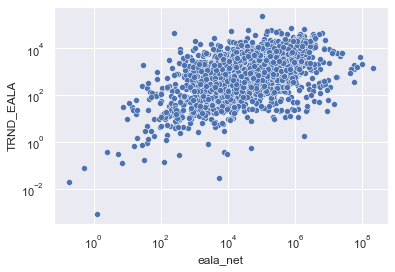

In [123]:
sns.scatterplot(merged_df, x='eala_net', y='TRND_EALA')
plt.xscale('log')
plt.yscale('log')

In [124]:
merged_df['Ag_compatibility_exists'].value_counts()

Ag_compatibility_exists
True     2983
False     253
Name: count, dtype: int64

In [125]:
merged_df.loc['08065', :]

state                                                 NaN
county                                                NaN
capacity_mw_ac                                        NaN
capacity_mw_dc                                        NaN
Solar_supply_per_land_area                            NaN
RESL_SCORE                                      27.530001
SOVI_SCORE                                      44.810001
TRND_ALRA                                             0.0
TRND_EALA                                             0.0
TRND_RISKV                                   64225.909332
TRND_RISKS                                      10.149539
HWAV_ALRA                                             0.0
HWAV_EALA                                             0.0
HWAV_RISKV                                            0.0
HWAV_RISKS                                            0.0
HAIL_ALRA                                             0.0
HAIL_EALA                                             0.0
HAIL_RISKV    

In [126]:
# show nan values in each column
nan_df = merged_df.loc[merged_df.isna().any(axis=1), merged_df.isna().any(axis=0)]

for col in nan_df.columns:
    if 'Undisclosed' not in col:
        display(nan_df.loc[nan_df[col].isna(), [col]])

state
FIPS       
02013   NaN
02016   NaN
02020   NaN
02050   NaN
02060   NaN
...     ...
02232   NaN
11031   NaN
02010   NaN
02      NaN
02261   NaN

[162 rows x 1 columns]

county
FIPS        
02013    NaN
02016    NaN
02020    NaN
02050    NaN
02060    NaN
...      ...
02232    NaN
11031    NaN
02010    NaN
02       NaN
02261    NaN

[162 rows x 1 columns]

capacity_mw_ac
FIPS                 
02013             NaN
02016             NaN
02020             NaN
02050             NaN
02060             NaN
...               ...
02232             NaN
11031             NaN
02010             NaN
02                NaN
02261             NaN

[162 rows x 1 columns]

capacity_mw_dc
FIPS                 
02013             NaN
02016             NaN
02020             NaN
02050             NaN
02060             NaN
...               ...
02232             NaN
11031             NaN
02010             NaN
02                NaN
02261             NaN

[162 rows x 1 columns]

Solar_supply_per_land_area
FIPS                             
02013                         NaN
02016                         NaN
02020                         NaN
02050                         NaN
02060                         NaN
...                           ...
02232                         NaN
11031                         NaN
02010                         NaN
02                            NaN
02261                         NaN

[162 rows x 1 columns]

RESL_SCORE
FIPS             
60010         NaN
60020         NaN
60050         NaN
66010         NaN
69100         NaN
...           ...
02232         NaN
11031         NaN
02010         NaN
02            NaN
02261         NaN

[93 rows x 1 columns]

SOVI_SCORE
FIPS             
60010         NaN
60020         NaN
60050         NaN
66010         NaN
69100         NaN
69110         NaN
69120         NaN
78010         NaN
78020         NaN
78030         NaN
02232         NaN
11031         NaN
02010         NaN
02            NaN
02261         NaN

TRND_ALRA
FIPS            
60010        NaN
60020        NaN
60050        NaN
66010        NaN
69100        NaN
69110        NaN
69120        NaN
02232        NaN
11031        NaN
02010        NaN
02           NaN
02261        NaN

TRND_EALA
FIPS            
60010        NaN
60020        NaN
60050        NaN
66010        NaN
69100        NaN
69110        NaN
69120        NaN
02232        NaN
11031        NaN
02010        NaN
02           NaN
02261        NaN

TRND_RISKV
FIPS             
60010         NaN
60020         NaN
60050         NaN
66010         NaN
69100         NaN
...           ...
02232         NaN
11031         NaN
02010         NaN
02            NaN
02261         NaN

[93 rows x 1 columns]

TRND_RISKS
FIPS             
60010         NaN
60020         NaN
60050         NaN
66010         NaN
69100         NaN
...           ...
02232         NaN
11031         NaN
02010         NaN
02            NaN
02261         NaN

[93 rows x 1 columns]

HWAV_ALRA
FIPS            
02232        NaN
11031        NaN
02010        NaN
02           NaN
02261        NaN

HWAV_EALA
FIPS            
02232        NaN
11031        NaN
02010        NaN
02           NaN
02261        NaN

HWAV_RISKV
FIPS             
60010         NaN
60020         NaN
60050         NaN
66010         NaN
69100         NaN
...           ...
02232         NaN
11031         NaN
02010         NaN
02            NaN
02261         NaN

[93 rows x 1 columns]

HWAV_RISKS
FIPS             
60010         NaN
60020         NaN
60050         NaN
66010         NaN
69100         NaN
...           ...
02232         NaN
11031         NaN
02010         NaN
02            NaN
02261         NaN

[93 rows x 1 columns]

HAIL_ALRA
FIPS            
60010        NaN
60020        NaN
60050        NaN
66010        NaN
69100        NaN
69110        NaN
69120        NaN
02232        NaN
11031        NaN
02010        NaN
02           NaN
02261        NaN

HAIL_EALA
FIPS            
60010        NaN
60020        NaN
60050        NaN
66010        NaN
69100        NaN
69110        NaN
69120        NaN
02232        NaN
11031        NaN
02010        NaN
02           NaN
02261        NaN

HAIL_RISKV
FIPS             
60010         NaN
60020         NaN
60050         NaN
66010         NaN
69100         NaN
...           ...
02232         NaN
11031         NaN
02010         NaN
02            NaN
02261         NaN

[93 rows x 1 columns]

HAIL_RISKS
FIPS             
60010         NaN
60020         NaN
60050         NaN
66010         NaN
69100         NaN
...           ...
02232         NaN
11031         NaN
02010         NaN
02            NaN
02261         NaN

[93 rows x 1 columns]

DRGT_ALRA
FIPS            
60010        NaN
60020        NaN
60050        NaN
66010        NaN
69100        NaN
69110        NaN
69120        NaN
02232        NaN
11031        NaN
02010        NaN
02           NaN
02261        NaN

DRGT_EALA
FIPS            
60010        NaN
60020        NaN
60050        NaN
66010        NaN
69100        NaN
69110        NaN
69120        NaN
02232        NaN
11031        NaN
02010        NaN
02           NaN
02261        NaN

DRGT_RISKV
FIPS             
60010         NaN
60020         NaN
60050         NaN
66010         NaN
69100         NaN
...           ...
02232         NaN
11031         NaN
02010         NaN
02            NaN
02261         NaN

[93 rows x 1 columns]

DRGT_RISKS
FIPS             
60010         NaN
60020         NaN
60050         NaN
66010         NaN
69100         NaN
...           ...
02232         NaN
11031         NaN
02010         NaN
02            NaN
02261         NaN

[93 rows x 1 columns]

Energy Burden (% income)
FIPS                           
60010                       NaN
60020                       NaN
60050                       NaN
66010                       NaN
69100                       NaN
69110                       NaN
69120                       NaN
78010                       NaN
78020                       NaN
78030                       NaN
02232                       NaN
11031                       NaN
02010                       NaN
02                          NaN
02261                       NaN

Value_veggies
FIPS               
01001           NaN
01005           NaN
01007           NaN
01009           NaN
01011           NaN
...             ...
78030           NaN
02232           NaN
11031           NaN
02              NaN
02261           NaN

[1802 rows x 1 columns]

Value_berries
FIPS               
01075           NaN
01085           NaN
04001           NaN
04009           NaN
04012           NaN
...             ...
78030           NaN
02232           NaN
11031           NaN
02010           NaN
02261           NaN

[834 rows x 1 columns]

tonne_co2_per_person
FIPS                       
11001                   NaN
44001                   NaN
44003                   NaN
44005                   NaN
44007                   NaN
...                     ...
02232                   NaN
11031                   NaN
02010                   NaN
02                      NaN
02261                   NaN

[168 rows x 1 columns]

SolarPanelLandUse
FIPS                    
02063                NaN
02066                NaN
60010                NaN
60020                NaN
60050                NaN
...                  ...
78030                NaN
02232                NaN
11031                NaN
02010                NaN
02                   NaN

[94 rows x 1 columns]

In [127]:
merged_df.loc[merged_df.isna().any(axis=1), merged_df.isna().any(axis=0)]

state   county  capacity_mw_ac  capacity_mw_dc  \
FIPS                                                      
01001  Alabama  Autauga    22349.202978    29947.935193   
01005  Alabama  Barbour    43344.657028    58081.848135   
01007  Alabama     Bibb    28368.690972    38014.050777   
01009  Alabama   Blount    18483.385380    24767.738851   
01011  Alabama  Bullock    32474.268989    43515.526148   
...        ...      ...             ...             ...   
02232      NaN      NaN             NaN             NaN   
11031      NaN      NaN             NaN             NaN   
02010      NaN      NaN             NaN             NaN   
02         NaN      NaN             NaN             NaN   
02261      NaN      NaN             NaN             NaN   

       Solar_supply_per_land_area  RESL_SCORE  SOVI_SCORE  TRND_ALRA  \
FIPS                                                                   
01001                   14.515933   51.810001   51.299999   0.000029   
01005                   18.909946    6.240000   99.269997   0.000009   
01007                   17.596358   19.730000   80.779999   0.000067   
01009                   11.066164   22.820000   51.369999   0.000077   
01011                   20.131783   17.980000   83.099998   0.000019   
...                           ...         ...         ...        ...   
02232                         NaN         NaN         NaN        NaN   
11031                         NaN         NaN         NaN        NaN   
02010                         NaN         NaN         NaN        NaN   
02                            NaN         NaN         NaN        NaN   
02261                         NaN         NaN         NaN        NaN   

          TRND_EALA    TRND_RISKV  ...  HAIL_RISKS  DRGT_ALRA      DRGT_EALA  \
FIPS                               ...                                         
01001    722.769891  2.831745e+06  ...   57.111040   0.000826   20330.149968   
01005   1074.005284  2.845056e+06  ...   39.993637   0.001623  196489.739432   
01007    324.869968  2.609927e+06  ...   43.684378   0.000831    4005.514889   
01009  21587.960390  6.930682e+06  ...   43.716195   0.000093   25903.218298   
01011   1500.352857  1.083751e+06  ...   24.021635   0.011559  891174.915609   
...             ...           ...  ...         ...        ...            ...   
02232           NaN           NaN  ...         NaN        NaN            NaN   
11031           NaN           NaN  ...         NaN        NaN            NaN   
02010           NaN           NaN  ...         NaN        NaN            NaN   
02              NaN           NaN  ...         NaN        NaN            NaN   
02261           NaN           NaN  ...         NaN        NaN            NaN   

         DRGT_RISKV  DRGT_RISKS  Energy Burden (% income)  Value_veggies  \
FIPS                                                                       
01001  2.854239e+04   50.652243                       3.0            NaN   
01005  2.950534e+05   80.687241                       4.0            NaN   
01007  4.764186e+03   32.421254                       4.0            NaN   
01009  3.258162e+04   52.147630                       3.0            NaN   
01011  1.190507e+06   95.036589                       4.0            NaN   
...             ...         ...                       ...            ...   
02232           NaN         NaN                       NaN            NaN   
11031           NaN         NaN                       NaN            NaN   
02010           NaN         NaN                       NaN              0   
02              NaN         NaN                       NaN            NaN   
02261           NaN         NaN                       NaN            NaN   

       Value_berries  tonne_co2_per_person  SolarPanelLandUse  
FIPS                                                           
01001              8             21.539853               0.05  
01005             12             21.539853               0.05  
01007             

In [235]:
# show alaska data
score_df.loc[[x[:2] == '02' for x in score_df.index], :].to_csv(os.path.join(export_dir, 'ak_agpv_data.csv'))

In [238]:
crops_sum_df[[x[:2] == '02' for x in crops_sum_df.FIPS]]

FIPS Value_veggies  Undisclosed_veggies Value_berries  \
14    02010             0                  0.0           NaN   
15    02020            64                  0.0           NaN   
16    02090            24                  0.0           NaN   
17    02110             0                  0.0           NaN   
18    02122            24                  0.0           NaN   
1485     02           NaN                  NaN            74   

      Undisclosed_berries AgPV_crop_totals  
14                    NaN              NaN  
15                    NaN              NaN  
16                    NaN              NaN  
17                    NaN              NaN  
18                    NaN              NaN  
1485                  0.0              NaN

In [128]:
# test for duplicate columns
for df in all_dfs:
    if df.index.duplicated().any():
        display(df[df.index.duplicated()])

In [129]:
# merged_df.loc['08065', :]
for df in all_dfs:
    if '08065' in df.index:
        display(df.loc['08065', :])

RESL_SCORE       27.530001
SOVI_SCORE       44.810001
TRND_ALRA         0.000000
TRND_EALA         0.000000
TRND_RISKV    64225.909332
TRND_RISKS       10.149539
HWAV_ALRA         0.000000
HWAV_EALA         0.000000
HWAV_RISKV        0.000000
HWAV_RISKS        0.000000
HAIL_ALRA         0.000000
HAIL_EALA         0.000000
HAIL_RISKV    65163.268992
HAIL_RISKS       38.657334
DRGT_ALRA         0.000000
DRGT_EALA         0.000000
DRGT_RISKV        0.000000
DRGT_RISKS        0.000000
Name: 08065, dtype: float64

Energy Burden (% income)    2
Name: 08065, dtype: int64

Percent Non Investor Owned    0.00058
Name: 08065, dtype: float64

Sheep_goats_total_sales            1000
Undisclosed_goats_sheep_totals    False
Name: 08065, dtype: object

Avg Farm Net Income ($)    -3384
Undisclosed_farm_income    False
Name: 08065, dtype: object

Pastureland                9172.0
Undisclosed_pastureland     False
Name: 08065, dtype: object

SolarPanelLandUse    0.05
Name: 08065, dtype: float64

## Data Exploration
Are there strong correlations in the undrelying variables> That might skew results.

Ac and DC solar potential are nearly identical and strongly correlated, so we can just use one of them.

Other than that, I didn't see any strong correlations between the variables. There is some positive correlation (~0.5) between tornado risk and the other weather hazards.

In [130]:
# only use one set of nri metric. The plot is already incomprehensible
sns.set_theme(style='darkgrid')
plot_cols = [col for col in merged_df.columns if '_RISKV' not in col and '_RISKS' not in col]

remake_graph = input('Do you want to make this stupid, huge graph? (Y/N)')
if remake_graph == 'Y':
    sns.pairplot(merged_df[plot_cols])

    # save plot
    graph_dir = 'AgPV_graphs'
    graph_file = 'agpv_pairplot.png'
    plt.savefig(os.path.join(graph_dir, graph_file))

else:
    print('Smart')

Do you want to make this stupid, huge graph? (Y/N)n
Smart


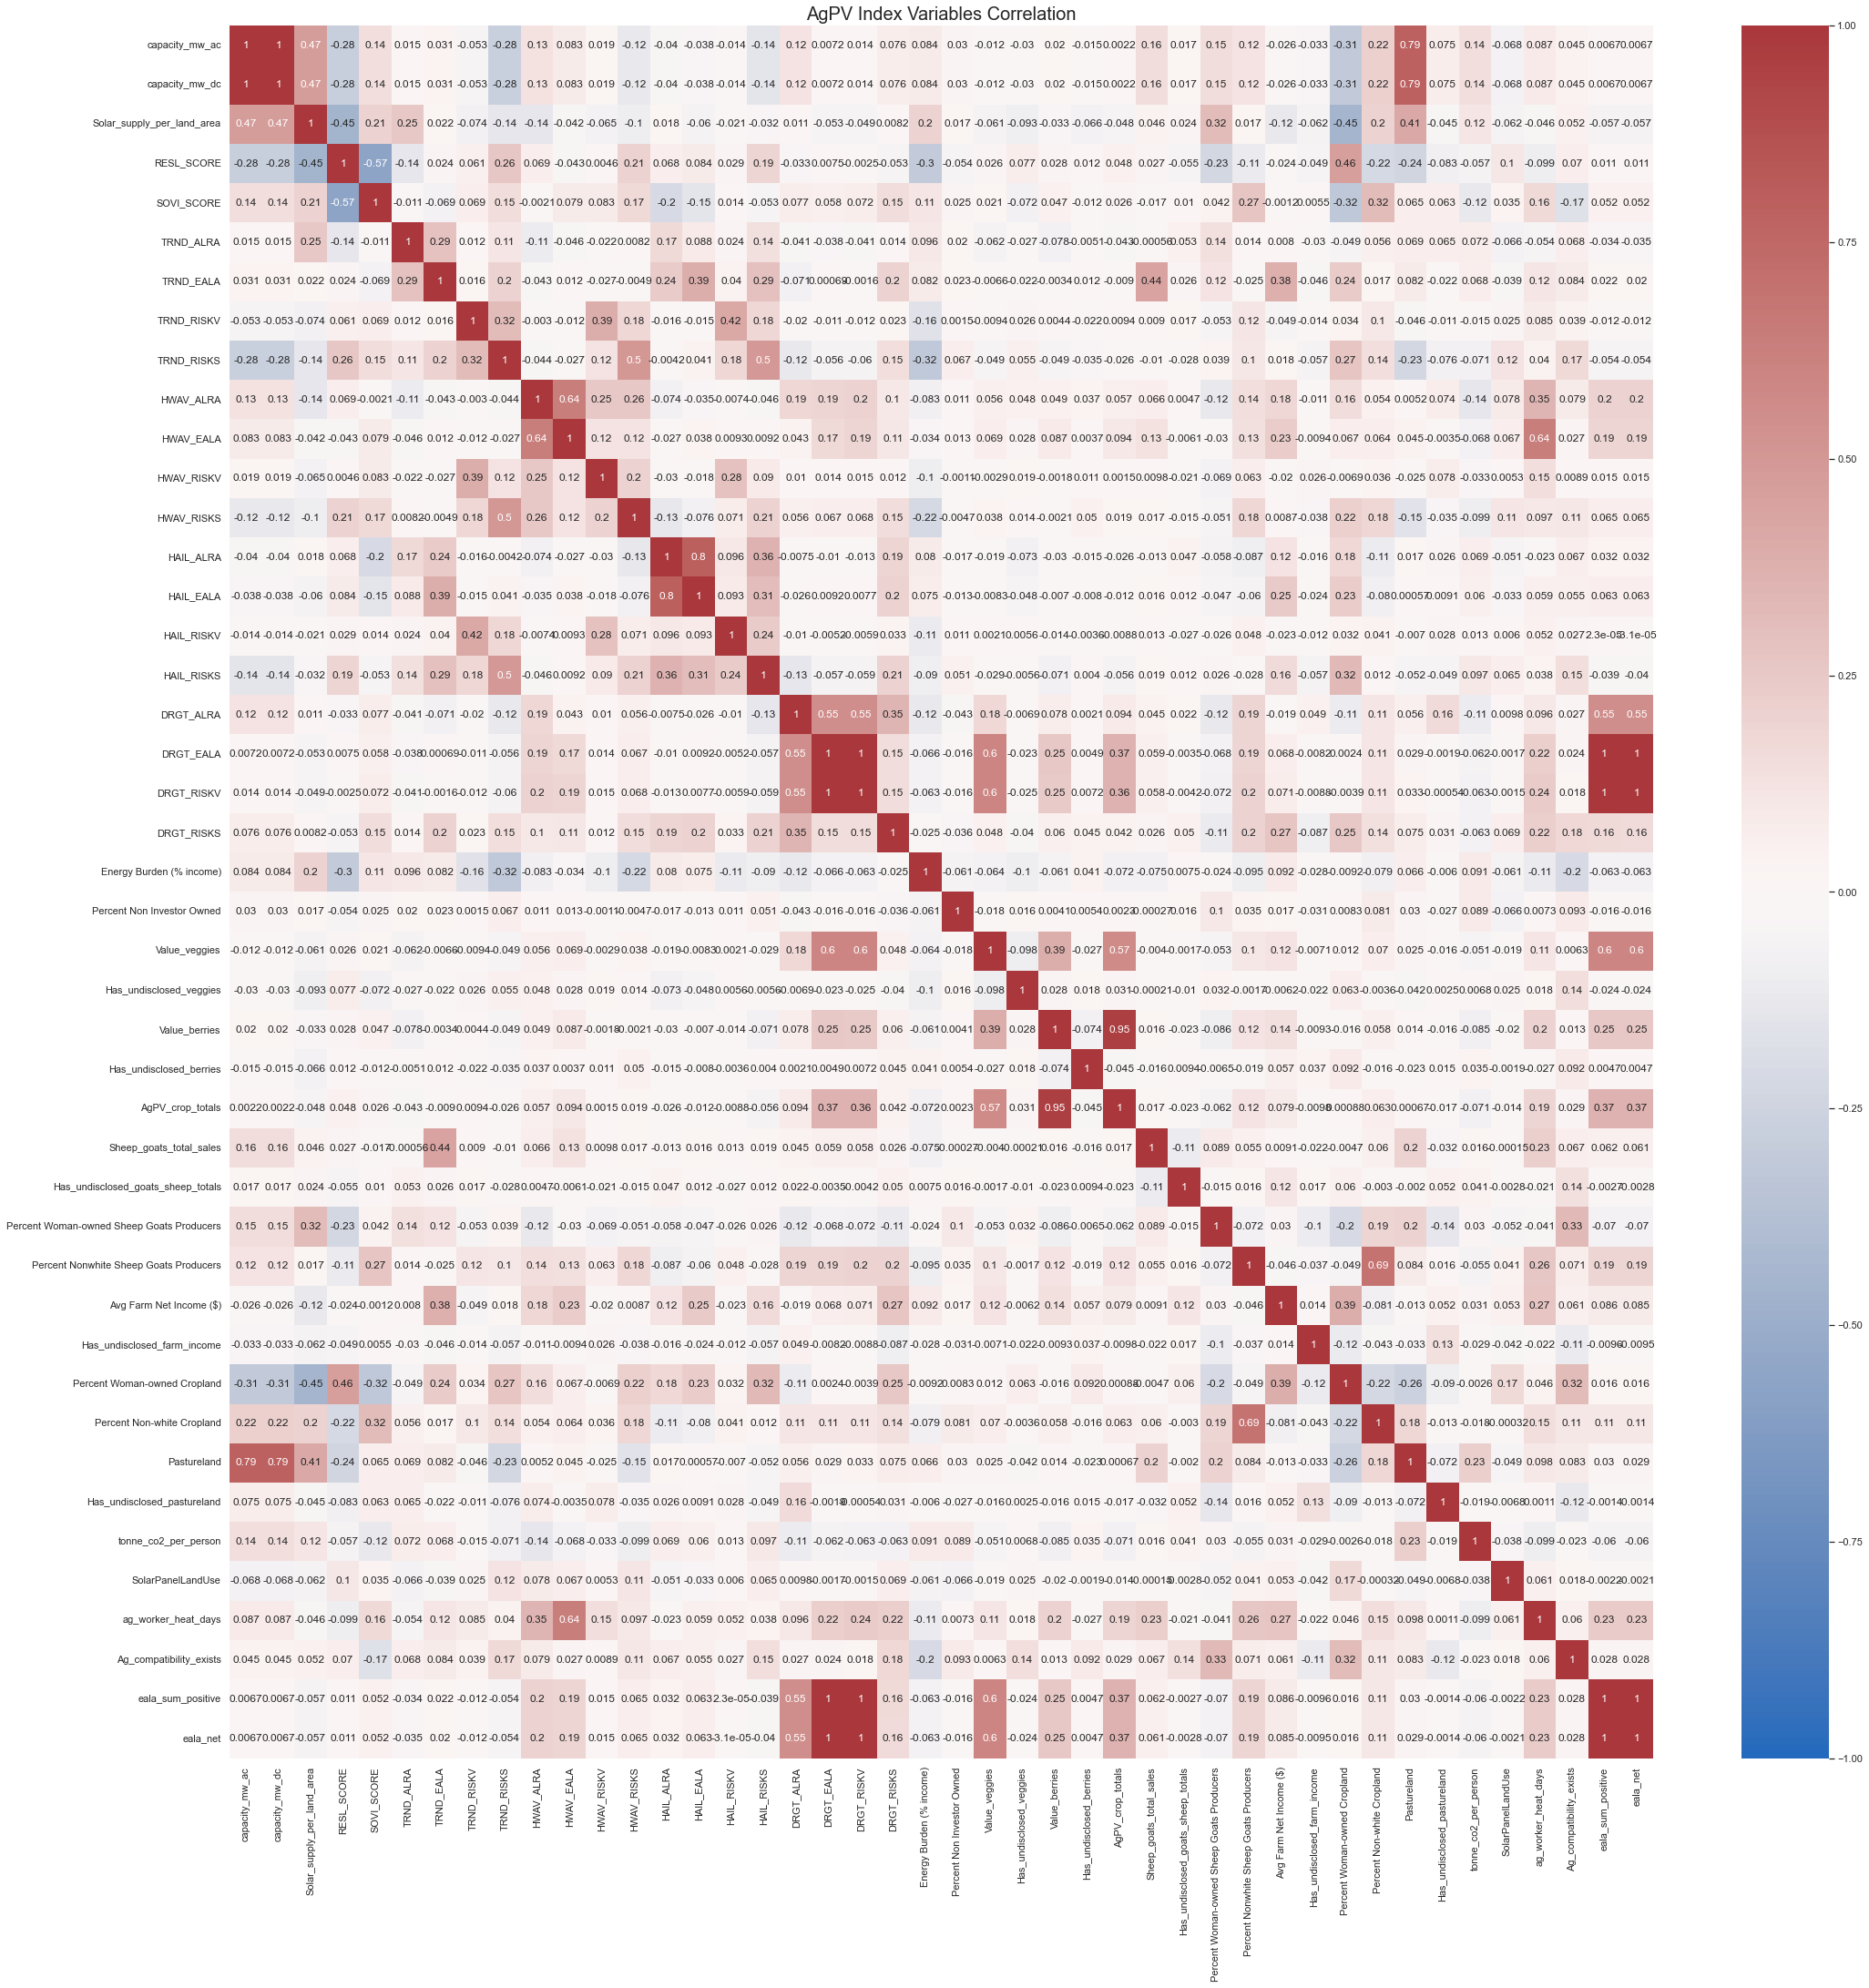

In [196]:
fig, ax = plt.subplots(figsize=(35,35))
corr_df = merged_df.iloc[:, 2:].corr()
sns.heatmap(corr_df, annot=True, cmap='vlag', vmin=-1, vmax=1)
plt.title('AgPV Index Variables Correlation', size=20)

# save file
corr_file = 'agpv_corr.png'
plt.savefig(os.path.join(graph_dir, corr_file))

### Pastureland Correlation
Solar supply and pastureland are highly correlated. This makes intuitive sense. Should it be included in the index if we don't want to directly include solar supply?

Text(0, 0.5, 'Solar Supply (MW AC)')

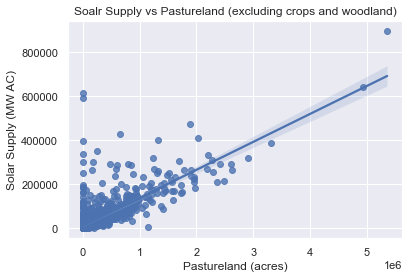

In [132]:
sns.regplot(merged_df, x='Pastureland', y='capacity_mw_ac')
plt.title('Soalr Supply vs Pastureland (excluding crops and woodland)')
plt.xlabel('Pastureland (acres)')
plt.ylabel('Solar Supply (MW AC)')

<Axes: xlabel='Percent Non-white Cropland', ylabel='Percent Nonwhite Sheep Goats Producers'>

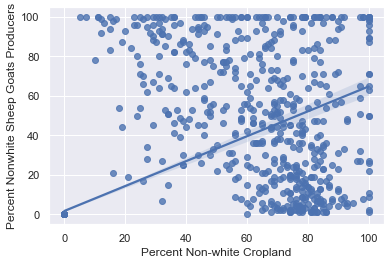

In [133]:
sns.regplot(merged_df, x='Percent Non-white Cropland', y='Percent Nonwhite Sheep Goats Producers')

### Ag Demographic Correlations

For both goats and cropland, race and gender seem to be inversely correlated after removing etreme values. Could this be due to the survey mechanism, or is it a real phenomenon?

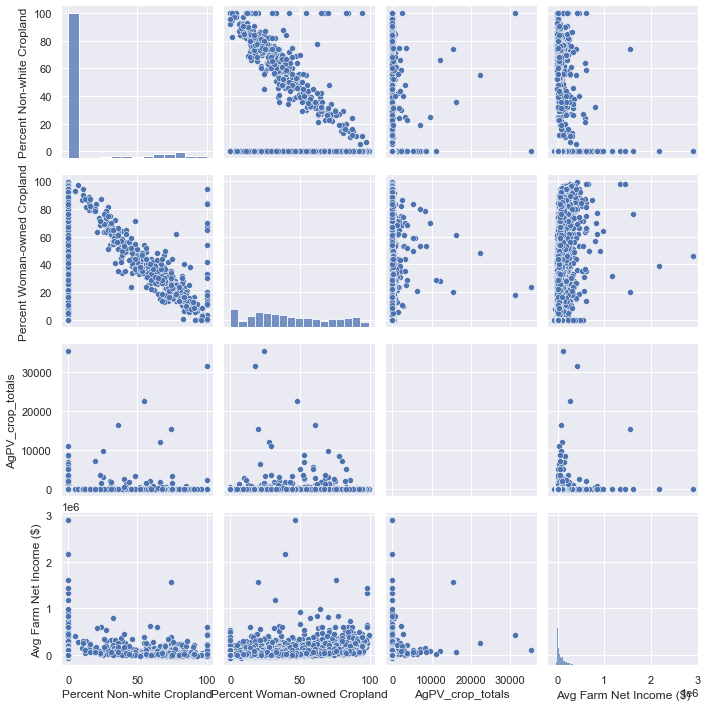

In [134]:
sns.pairplot(merged_df[['Percent Non-white Cropland', 'Percent Woman-owned Cropland', 'AgPV_crop_totals', 'Avg Farm Net Income ($)']])

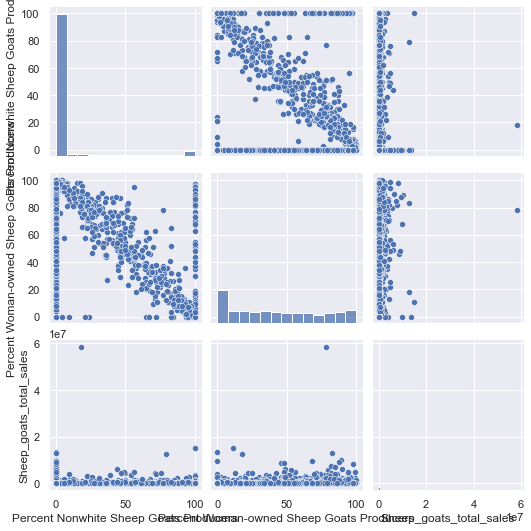

In [135]:
sns.pairplot(merged_df[['Percent Nonwhite Sheep Goats Producers', 'Percent Woman-owned Sheep Goats Producers', 'Sheep_goats_total_sales']])

<Axes: xlabel='Percent Non-white Cropland', ylabel='Percent Woman-owned Cropland'>

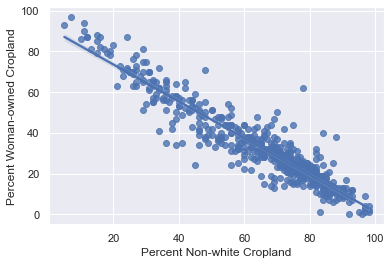

In [136]:
sns.regplot(merged_df[merged_df['Percent Non-white Cropland'].between(0,100, inclusive='neither')], x='Percent Non-white Cropland', y='Percent Woman-owned Cropland')

<Axes: xlabel='Percent Nonwhite Sheep Goats Producers', ylabel='Percent Woman-owned Sheep Goats Producers'>

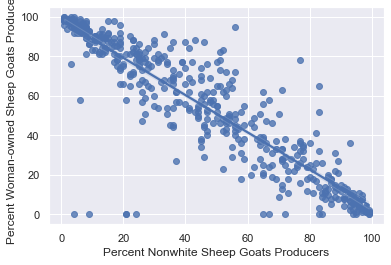

In [137]:
sns.regplot(merged_df[merged_df['Percent Nonwhite Sheep Goats Producers'].between(0,100, inclusive='neither')], x='Percent Nonwhite Sheep Goats Producers', y='Percent Woman-owned Sheep Goats Producers')

<Axes: xlabel='Percent Non-white Cropland', ylabel='Percent Woman-owned Cropland'>

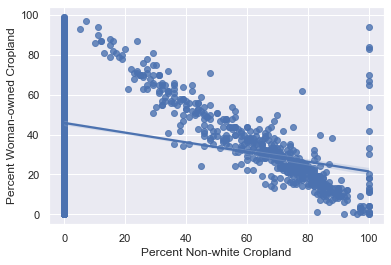

In [138]:
# is the apparent crop land woman-owned tradeoff due to undisclosed values?
sns.regplot(merged_df.loc[~merged_df[['Has_undisclosed_goats_sheep_totals', 'Has_undisclosed_veggies']].isna().any(axis=1), :], x='Percent Non-white Cropland', y='Percent Woman-owned Cropland')

### Woman-owned cropland and farm net income
There seem to be some positive correlation with farm net income and woman-ownership. What could be driving this?

We could investigate this later. The correlation seem small, but significant

Text(0.5, 0.98, 'Avg Farm Income vs Percent Woman Ownership')

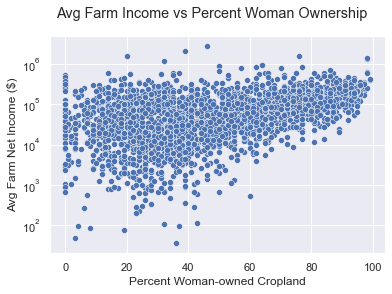

In [139]:
sns.scatterplot(merged_df, x='Percent Woman-owned Cropland', y='Avg Farm Net Income ($)', )
plt.yscale('log')
plt.suptitle('Avg Farm Income vs Percent Woman Ownership')

state     county  capacity_mw_ac  capacity_mw_dc  \
FIPS                                                          
48495      Texas    Winkler    65171.939462    87330.412063   
48127      Texas     Dimmit    91791.745729   123000.958688   
48443      Texas    Terrell   156034.935317   209086.851952   
48475      Texas       Ward    54914.054428    73584.843040   
13077    Georgia     Coweta    13673.475050    18322.457555   
48311      Texas   McMullen    80815.112833   108292.266610   
22051  Louisiana  Jefferson      622.354897      833.955580   
48103      Texas      Crane    51699.298199    69277.070000   
08097   Colorado     Pitkin     1817.499454     2435.449451   
48043      Texas   Brewster   267805.861152   358859.914931   

       Solar_supply_per_land_area  RESL_SCORE  SOVI_SCORE  TRND_ALRA  \
FIPS                                                                   
48495                   29.910775   18.620001   56.680000   0.000144   
48127                   26.669701    4.550000  100.000000   0.000012   
48443                   25.549811    5.220000   16.200001   0.000000   
48475                   25.373795    9.130000   73.139999   0.000032   
13077                   11.971434   59.990002   29.629999   0.000036   
48311                   27.375763   18.459999   72.019997   0.000026   
22051                    0.798674   96.050003   79.849998   0.000012   
48103                   25.426040    2.930000   63.880001   0.000685   
08097                    0.722921   62.790001   14.580000   0.000004   
48043                   16.721266   22.440001   78.489998   0.000006   

        TRND_EALA    TRND_RISKV  ...  Percent Non-white Cropland  Pastureland  \
FIPS                             ...                                            
48495  176.890983  2.082394e+05  ...                         0.0          0.0   
48127  390.860901  4.056930e+05  ...                         0.0     285275.0   
48443    0.000000  1.195761e+04  ...                         0.0     781949.0   
48475   58.102469  3.639056e+05  ...                         0.0     437318.0   
13077  483.622874  4.801081e+06  ...                         0.0          0.0   
48311  249.971034  6.250281e+04  ...                         0.0     475897.0   
22051    9.678317  2.228804e+06  ...                         0.0        148.0   
48103    0.119170  1.149477e+05  ...                         0.0          0.0   
08097   11.825258  4.337883e+04  ...                         0.0      22414.0   
48043  114.962753  1.750875e+05  ...                         0.0    2192068.0   

       Has_undisclosed_pastureland  tonne_co2_per_person  SolarPanelLandUse  \
FIPS                                                                          
48495                         True             22.078080               0.30   
48127                        False             22.078080               0.05   
48443                        False             22.078080               0.05   
48475                        False             22.078080               0.05   
13077                         True             11.431693               0.05   
48311                        False             22.078080               0.05   
22051                        False             41.797864               0.05   
48103                         True             22.078080               2.05   
08097                        False             15.183116               0.05   
48043                        False             22.078080               0.30   

       ag_worker_heat_days  Ag_compatibility_exists  eala_sum_positive  \
FIPS                                                                     
48495           394.250000                     True       54174.078673   
48127          1475.000000                     True       69997.828147   
48443           126.000000                     True        1745.465786   
48475           101.333333                     True       14848.508762   
13077           380.000

<Axes: xlabel='Percent Woman-owned Cropland', ylabel='Log Farm Income'>

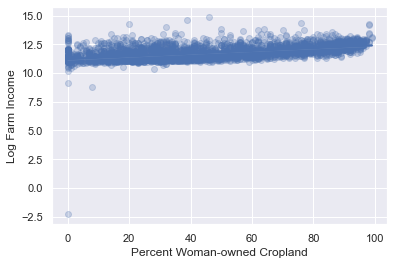

In [140]:
# try with a log transformation. Need to account for negative and zero values
log_df = merged_df.copy()
log_df['Log Farm Income'] = np.log(log_df['Avg Farm Net Income ($)'] + abs(log_df['Avg Farm Net Income ($)'].min()) + 0.1)

display(log_df.sort_values('Avg Farm Net Income ($)').iloc[:10, :])
sns.regplot(log_df, x='Percent Woman-owned Cropland', y='Log Farm Income', scatter_kws={'alpha': 0.25})

## Index Preprocessing

NRI score values seem appropriate over using the value or expected loss metric since SVI and community resiliency also use score.

For roads to removal, I used a Box-Cox transform to try and fit to a normal distribution. This time, I'm trying quantile normalization, which really forces the data to a normal distribution. The results look much more gaussian. In a sense, it's mangling the data, but since we're already doing so much to it anyway with the scaling, it's probably OK. In most cases, we get very pretty bell curves.

Process:

* Transform underlying variables to fit normal dist'n
* Minmax scale data [0-1]
* Invert 'negative' variables (tornadoes and farmer income)
* Average values of underlying variables
* Minmax scal results [0-1]

In [141]:
merged_df[plot_cols].iloc[:, 2:]

capacity_mw_ac  capacity_mw_dc  Solar_supply_per_land_area  RESL_SCORE  \
FIPS                                                                            
01001    22349.202978    29947.935193                   14.515933   51.810001   
01003    46948.973155    62911.632997                   11.401515   86.120003   
01005    43344.657028    58081.848135                   18.909946    6.240000   
01007    28368.690972    38014.050777                   17.596358   19.730000   
01009    18483.385380    24767.738851                   11.066164   22.820000   
...               ...             ...                         ...         ...   
02232             NaN             NaN                         NaN         NaN   
11031             NaN             NaN                         NaN         NaN   
02010             NaN             NaN                         NaN         NaN   
02                NaN             NaN                         NaN         NaN   
02261             NaN             NaN                         NaN         NaN   

       SOVI_SCORE  TRND_ALRA     TRND_EALA     HWAV_ALRA    HWAV_EALA  \
FIPS                                                                    
01001   51.299999   0.000029    722.769891  2.747418e-06    67.624948   
01003   31.030001   0.000004    620.946493  9.080529e-07   125.392132   
01005   99.269997   0.000009   1074.005284  2.747418e-06   332.645749   
01007   80.779999   0.000067    324.869968  4.200027e-06    20.241424   
01009   51.369999   0.000077  21587.960390  4.200027e-06  1170.005046   
...           ...        ...           ...           ...          ...   
02232         NaN        NaN           NaN           NaN          NaN   
11031         NaN        NaN           NaN           NaN          NaN   
02010         NaN        NaN           NaN           NaN          NaN   
02            NaN        NaN           NaN           NaN          NaN   
02261         NaN        NaN           NaN           NaN          NaN   

          HAIL_ALRA  ...  Percent Woman-owned Cropland  \
FIPS                 ...                                 
01001  4.687348e-05  ...                          32.0   
01003  2.308179e-07  ...                          33.0   
01005  4.524451e-06  ...                          28.0   
01007  2.179460e-04  ...                          21.0   
01009  1.966831e-05  ...                          24.0   
...             ...  ...                           ...   
02232           NaN  ...                           0.0   
11031           NaN  ...                           0.0   
02010           NaN  ...                           0.0   
02              NaN  ...                          22.2   
02261           NaN  ...                           0.0   

       Percent Non-white Cropland  Pastureland  Has_undisclosed_pastureland  \
FIPS                                                                          
01001                        68.0      19203.0                        False   
01003                         0.0      13134.0                        False   
01005                        74.0      36564.0                        False   
01007                         0.0       8427.0                        False   
01009                         0.0      47693.0                        False   
...                           ...          ...                          ...   
02232                         0.0          0.0                        False   
11031                         0.0          0.0                        False   
02010                         0.0          0.0                        False   
02                           60.0          0.0                        False   
02261                         0.0          0.0                        False   

       tonne_co2_per_person SolarPanelLandUse  ag_worker_heat_days  \
FIPS                                                                 
01001             21.539853              0.05                483.0   
01003     

In [142]:
# use quantile normalization to make everything have a normal distribution
from sklearn.preprocessing import quantile_transform, MinMaxScaler

plot_cols = [col for col in merged_df.columns if '_RISKV' not in col and '_RISKS' not in col]
X = quantile_transform(merged_df[plot_cols].iloc[:, 2:], output_distribution='normal')

# scale all values 0-1
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# create df from transformed data
normalized_df = pd.DataFrame(X, columns=merged_df[plot_cols].iloc[:, 2:].columns, index=merged_df.index)
if 'capacity_mw_dc' in normalized_df.columns:
    normalized_df = normalized_df.drop(columns=['capacity_mw_dc'])

# need to invert the neagtives in the index: tornado risk and farm income
normalized_df['Avg Farm Net Income ($)'] = 1 - normalized_df['Avg Farm Net Income ($)']
normalized_df['TRND_ALRA'] = 1 - normalized_df['TRND_ALRA']
normalized_df['TRND_EALA'] = 1 - normalized_df['TRND_EALA']
normalized_df['SolarPanelLandUse'] = 1 - normalized_df['SolarPanelLandUse']
normalized_df.head()

capacity_mw_ac  Solar_supply_per_land_area  RESL_SCORE  SOVI_SCORE  \
FIPS                                                                        
01001        0.547392                    0.577796    0.504360    0.500147   
01003        0.612527                    0.537601    0.604410    0.450342   
01005        0.606179                    0.631931    0.352376    0.735668   
01007        0.570387                    0.614479    0.418138    0.578821   
01009        0.530108                    0.533541    0.428377    0.500305   

       TRND_ALRA  TRND_EALA  HWAV_ALRA  HWAV_EALA  HAIL_ALRA  HAIL_EALA  ...  \
FIPS                                                                     ...   
01001   0.454402   0.526097   0.517837   0.505445   0.483737   0.465589  ...   
01003   0.593834   0.533618   0.493895   0.518681   0.358358   0.378877  ...   
01005   0.561889   0.508619   0.517837   0.539294   0.409336   0.442499  ...   
01007   0.347696   0.557772   0.526262   0.482610   0.544352   0.462693  ...   
01009   0.333056   0.299243   0.525761   0.563962   0.459150   0.513470  ...   

       Percent Woman-owned Cropland  Percent Non-white Cropland  Pastureland  \
FIPS                                                                           
01001                      0.479579                    0.626551     0.510806   
01003                      0.482776                    0.000000     0.492410   
01005                      0.464719                    0.640805     0.539314   
01007                      0.436419                    0.000000     0.470779   
01009                      0.450206                    0.000000     0.550008   

       Has_undisclosed_pastureland  tonne_co2_per_person  SolarPanelLandUse  \
FIPS                                                                          
01001                          0.0              0.531946                1.0   
01003                          0.0              0.531946                1.0   
01005                          0.0              0.531946                1.0   
01007                          0.0              0.531946                1.0   
01009                          0.0              0.531946                1.0   

       ag_worker_heat_days  Ag_compatibility_exists  eala_sum_positive  \
FIPS                                                                     
01001             0.508629                      1.0           0.470325   
01003             0.670972                      1.0           0.595120   
01005             0.533168                      1.0           0.556448   
01007             0.000000                      1.0           0.425744   
01009             0.495534                      1.0           0.485923   

       eala_net  
FIPS             
01001  0.473370  
01003  0.595371  
01005  0.557393  
01007  0.431854  
01009  0.453306  

[5 rows x 35 columns]

In [143]:
normalized_df.columns

Index(['capacity_mw_ac', 'Solar_supply_per_land_area', 'RESL_SCORE',
       'SOVI_SCORE', 'TRND_ALRA', 'TRND_EALA', 'HWAV_ALRA', 'HWAV_EALA',
       'HAIL_ALRA', 'HAIL_EALA', 'DRGT_ALRA', 'DRGT_EALA',
       'Energy Burden (% income)', 'Percent Non Investor Owned',
       'Value_veggies', 'Has_undisclosed_veggies', 'Value_berries',
       'Has_undisclosed_berries', 'AgPV_crop_totals',
       'Sheep_goats_total_sales', 'Has_undisclosed_goats_sheep_totals',
       'Percent Woman-owned Sheep Goats Producers',
       'Percent Nonwhite Sheep Goats Producers', 'Avg Farm Net Income ($)',
       'Has_undisclosed_farm_income', 'Percent Woman-owned Cropland',
       'Percent Non-white Cropland', 'Pastureland',
       'Has_undisclosed_pastureland', 'tonne_co2_per_person',
       'SolarPanelLandUse', 'ag_worker_heat_days', 'Ag_compatibility_exists',
       'eala_sum_positive', 'eala_net'],
      dtype='object')

The transformations seemed to slightly exagerate correlation between toranado and hail risk. Tornado and energy burden also have some correlation (0.3). This could cause some bias in the overall index.

Text(0.5, 1.0, 'AgPV Index Variables Quantile Transform Correlation')

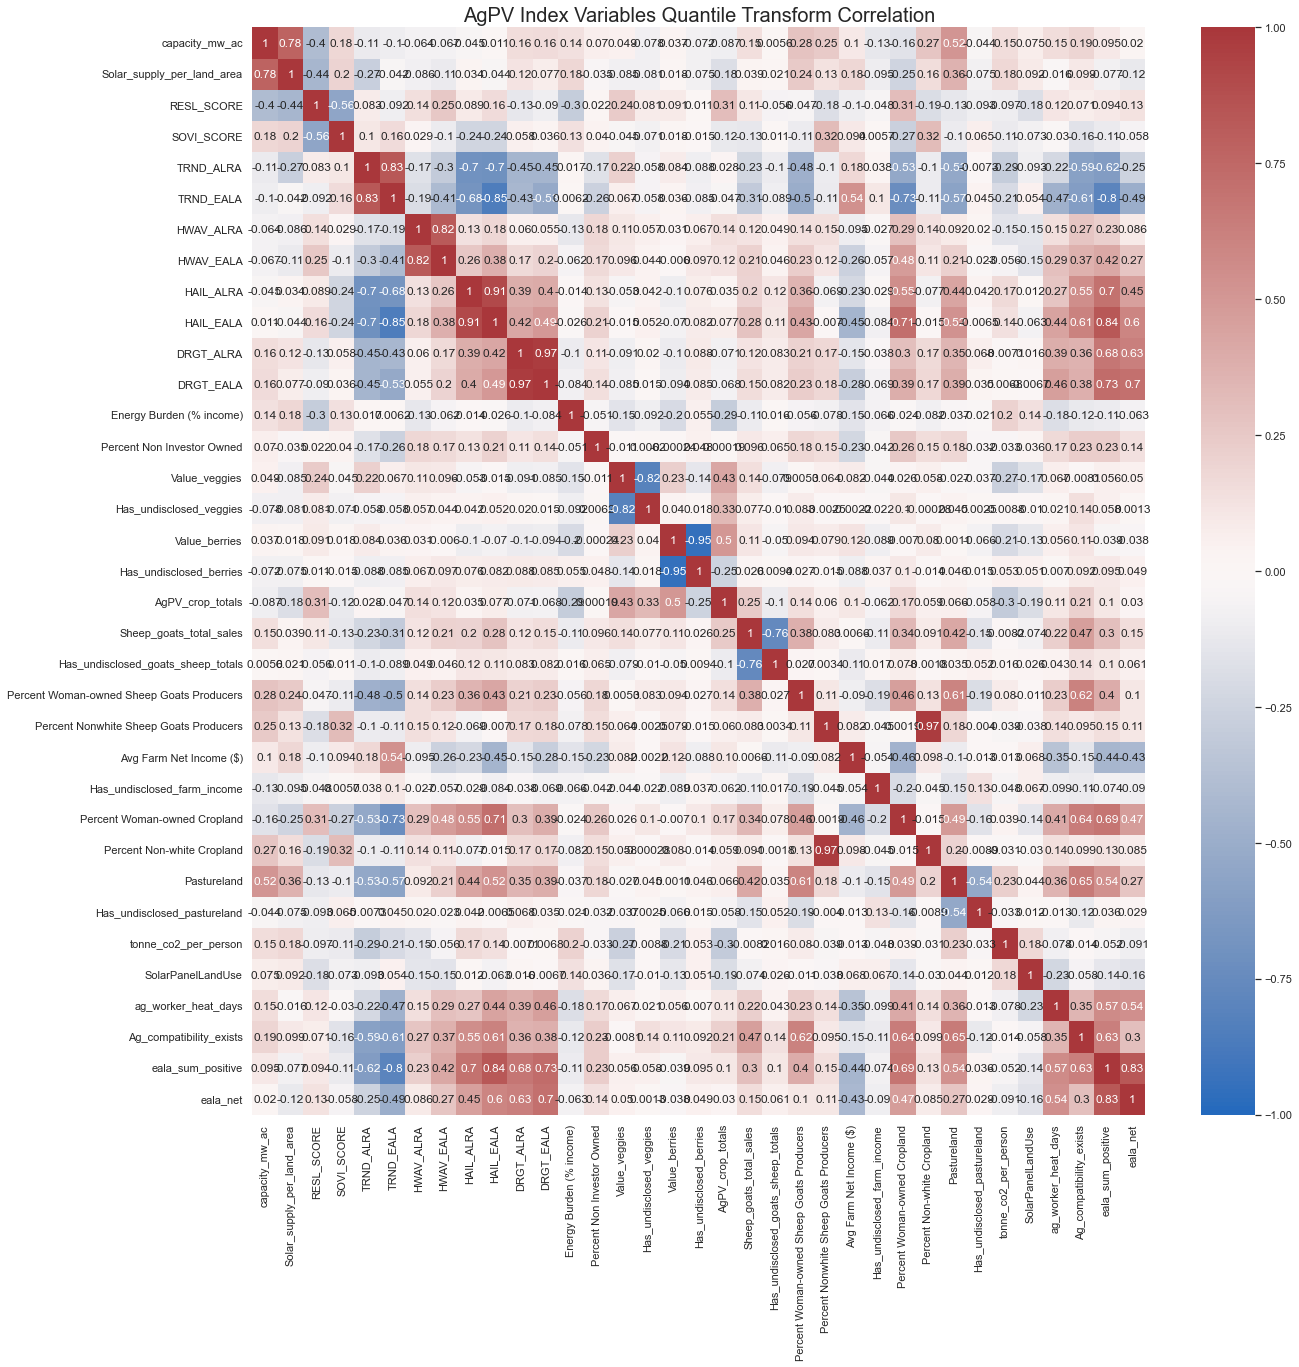

In [144]:
# correlation map with simplified variables and transformed
fig, ax = plt.subplots(figsize=(20,20))
corr_df = normalized_df.iloc[:, 0:].corr()
sns.heatmap(corr_df, annot=True, cmap='vlag', vmin=-1, vmax=1)
plt.title('AgPV Index Variables Quantile Transform Correlation', size=20)

<Axes: xlabel='Pastureland', ylabel='capacity_mw_ac'>

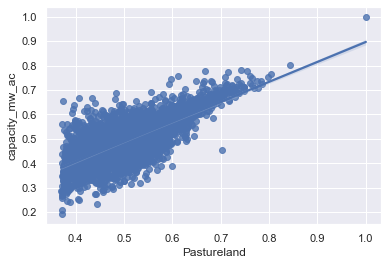

In [145]:
# are pastureland and solar supply still correlated? Yes, when you filter for 0 values
sns.regplot(normalized_df[normalized_df['Pastureland']>0], x='Pastureland', y='capacity_mw_ac')

### Demographics correlations
Minority-owned crops and goats have very high correlation. Women-owned crops and goats ahve moderate correlation. I think it's best to average each respectively to avoid potential "double counting."

<Axes: xlabel='Percent Non-white Cropland', ylabel='Percent Nonwhite Sheep Goats Producers'>

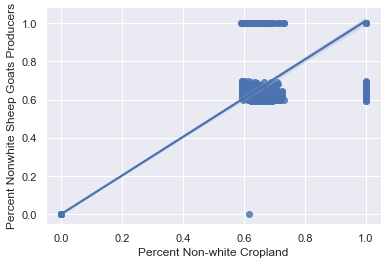

In [146]:
sns.regplot(normalized_df, x='Percent Non-white Cropland', y='Percent Nonwhite Sheep Goats Producers')

<Axes: xlabel='Percent Woman-owned Cropland', ylabel='Percent Woman-owned Sheep Goats Producers'>

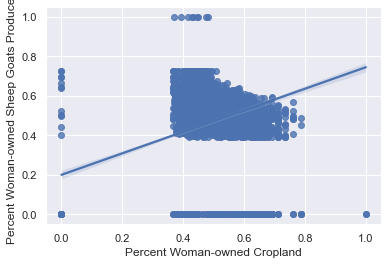

In [147]:
sns.regplot(normalized_df, x='Percent Woman-owned Cropland', y='Percent Woman-owned Sheep Goats Producers')

<Axes: xlabel='HAIL_ALRA', ylabel='TRND_ALRA'>

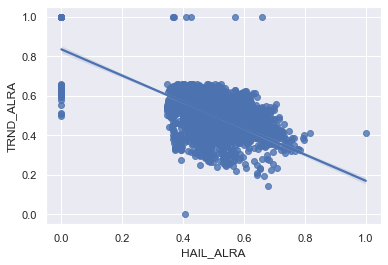

In [148]:
sns.regplot(normalized_df, x='HAIL_ALRA', y='TRND_ALRA')

In [149]:
# Get same columns from normalized df
plot_cols_df = merged_df[normalized_df.columns]
# scale un tranformed daata
scaled_original_data = scaler.fit_transform(plot_cols_df)
scaled_original_df = pd.DataFrame(scaled_original_data, index=plot_cols_df.index, columns=plot_cols_df.columns)
# add column to signify if this data has been quantile transformed
scaled_original_df['Quantile Transform'] = 'No'
# join dfs
xform_comp_df = pd.concat([scaled_original_df, normalized_df])
xform_comp_df['Quantile Transform'] = xform_comp_df['Quantile Transform'].fillna('Yes')
xform_comp_df = xform_comp_df.reset_index(drop=True)
xform_comp_df

capacity_mw_ac  Solar_supply_per_land_area  RESL_SCORE  SOVI_SCORE  \
0           0.024866                    0.389419      0.5181      0.5130   
1           0.052241                    0.305861      0.8612      0.3103   
2           0.048230                    0.507308      0.0624      0.9927   
3           0.031565                    0.472065      0.1973      0.8078   
4           0.020564                    0.296864      0.2282      0.5137   
...              ...                         ...         ...         ...   
6467             NaN                         NaN         NaN         NaN   
6468             NaN                         NaN         NaN         NaN   
6469             NaN                         NaN         NaN         NaN   
6470             NaN                         NaN         NaN         NaN   
6471             NaN                         NaN         NaN         NaN   

      TRND_ALRA  TRND_EALA  HWAV_ALRA  HWAV_EALA  HAIL_ALRA  HAIL_EALA  ...  \
0      0.025848   0.003125   0.002106   0.000020   0.004276   0.000186  ...   
1      0.003958   0.002685   0.000696   0.000037   0.000021   0.000005  ...   
2      0.007808   0.004644   0.002106   0.000099   0.000413   0.000088  ...   
3      0.059338   0.001405   0.003220   0.000006   0.019883   0.000169  ...   
4      0.068216   0.093344   0.003220   0.000350   0.001794   0.000882  ...   
...         ...        ...        ...        ...        ...        ...  ...   
6467        NaN        NaN        NaN        NaN        NaN        NaN  ...   
6468        NaN        NaN        NaN        NaN        NaN        NaN  ...   
6469        NaN        NaN        NaN        NaN        NaN        NaN  ...   
6470        NaN        NaN        NaN        NaN        NaN        NaN  ...   
6471        NaN        NaN        NaN        NaN        NaN        NaN  ...   

      Percent Non-white Cropland  Pastureland  Has_undisclosed_pastureland  \
0                       0.680000     0.003583                          0.0   
1                       0.000000     0.002451                          0.0   
2                       0.740000     0.006823                          0.0   
3                       0.000000     0.001572                          0.0   
4                       0.000000     0.008899                          0.0   
...                          ...          ...                          ...   
6467                    0.000000     0.000000                          0.0   
6468                    0.000000     0.000000                          0.0   
6469                    0.000000     0.000000                          0.0   
6470                    0.615874     0.000000                          0.0   
6471                    0.000000     0.000000                          0.0   

      tonne_co2_per_person  SolarPanelLandUse  ag_worker_heat_days  \
0                 0.150879                0.0             0.002513   
1                 0.150879                0.0             0.040011   
2                 0.150879                0.0             0.003897   
3                 0.150879                0.0             0.000000   
4                 0.150879                0.0             0.001873   
...                    ...                ...                  ...   
6467                   NaN                NaN             0.000000   
6468                   NaN                NaN             0.000000   
6469                   NaN                NaN             0.000000   
6470                   NaN                NaN             0.000000   
6471                   NaN                1.0             0.000000   

      Ag_compatibility_exists  eala_sum_positive  eala_net  Quantile Transform  
0                         1.0           0.000100  0.000217                  No  
1                         1.0           0.002066  0.002183                  No  
2                         1.0           0.000918  0.001033                  No  
3                         1.0           0.

Text(0.5, 1.0, 'Nomalized Index Value Comparisons:\nWoman-owned Cropland vs Avg Farm Income')

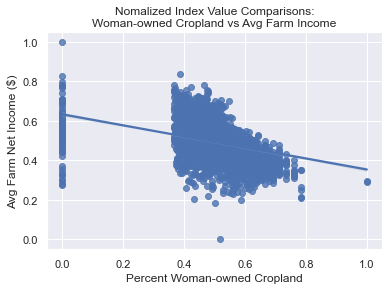

In [150]:
sns.regplot(normalized_df, x='Percent Woman-owned Cropland', y='Avg Farm Net Income ($)', )
plt.title('Nomalized Index Value Comparisons:\nWoman-owned Cropland vs Avg Farm Income')

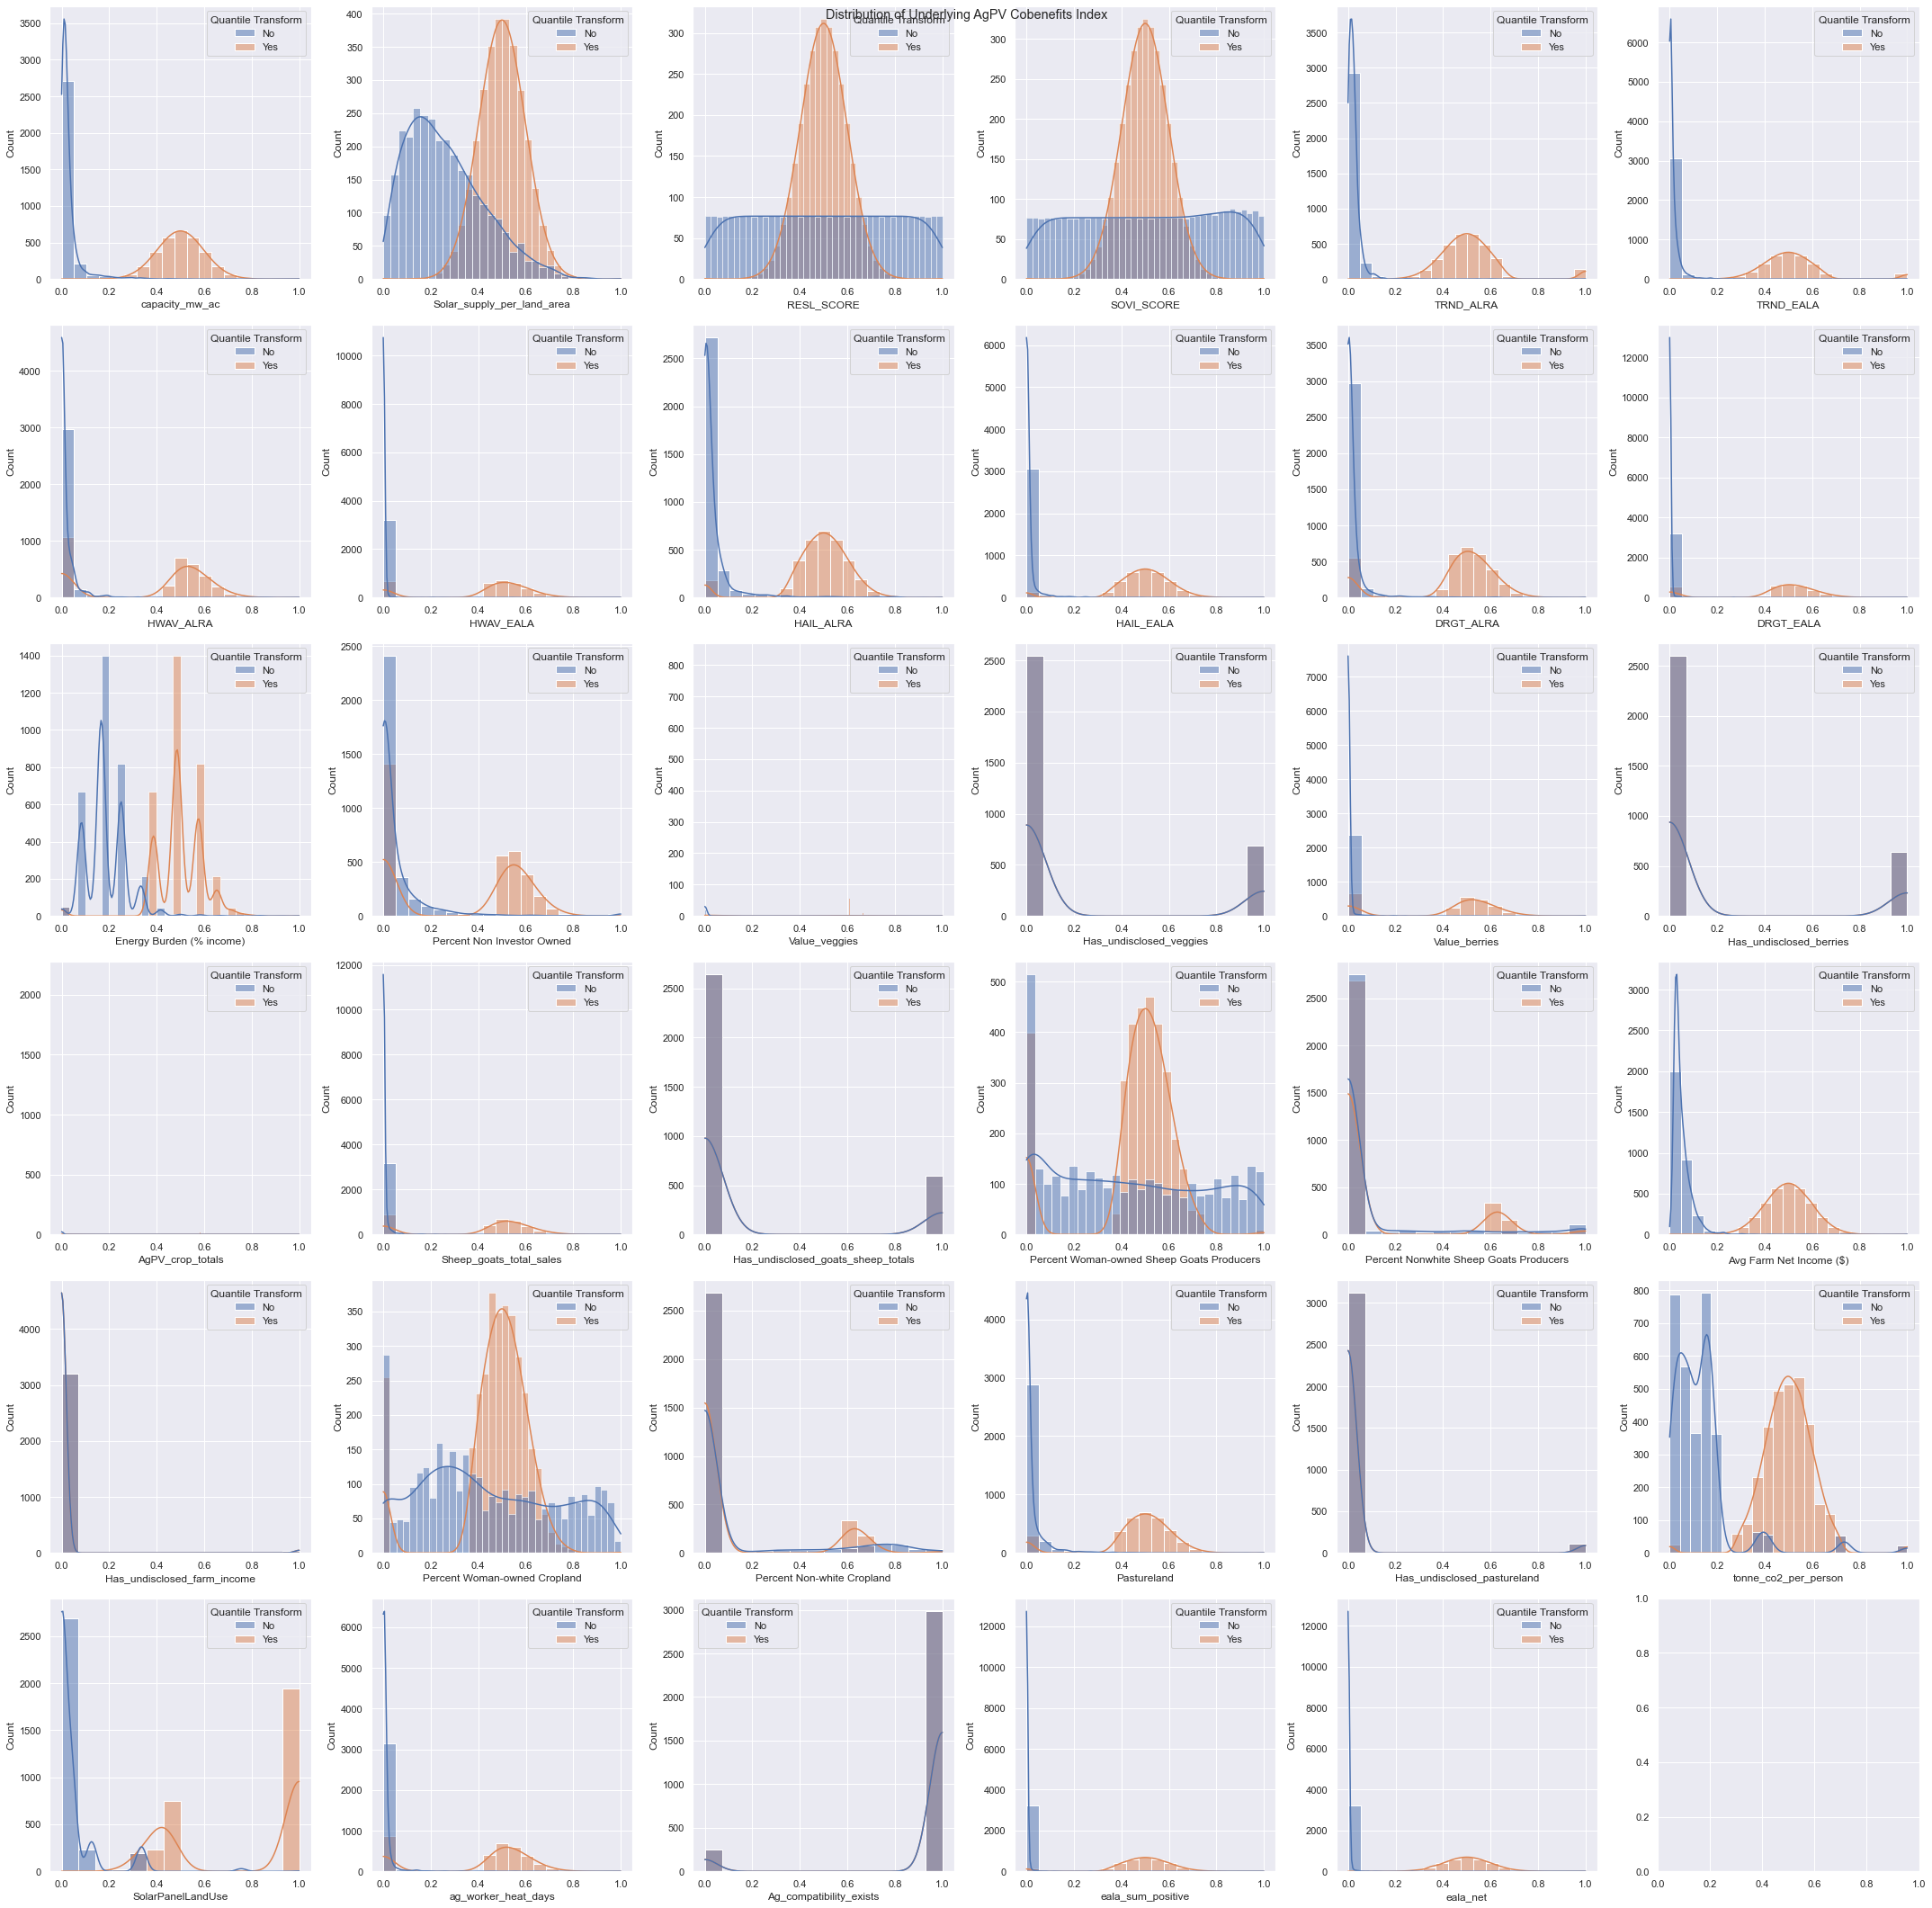

In [151]:
# look at histograms of transformed data compared to just minmax scaling. Look how beautiful these normal distributions are!
fig, axes = plt.subplots(6, 6, figsize=(30,30))

for col, ax in zip(xform_comp_df.iloc[:, :-1].columns, axes.flatten()):
    if col is not None:
        sns.histplot(xform_comp_df, x=col, kde=True, ax=ax, hue='Quantile Transform')
    
fig.suptitle('Distribution of Underlying AgPV Cobenefits Index')
plt.tight_layout()
plt.savefig(os.path.join(graph_dir, 'agpv_variable_distribution.png'))

Look at how wonderful those bell curves look!

Crop totals is hard to see It's likely because there are too many 0 values. Here's a filtered, zoomed in version

<Axes: xlabel='AgPV_crop_totals', ylabel='Count'>

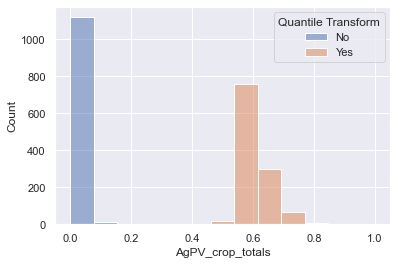

In [152]:
sns.histplot(xform_comp_df[xform_comp_df['AgPV_crop_totals']>0], x='AgPV_crop_totals', hue='Quantile Transform')

### Ag PV Index Calculation

[Apache, AZ](https://en.wikipedia.org/wiki/Apache_County,_Arizona) stands out due to its near 100% minority cropland ownership, reasonably high energy burden (80th percentile), high drought risk (95th percentile), low torndo risk (2nd percentile), and high solar supply (99th percentile).

Most of this land is owned by the Navajo nation, so the high minoirty ownership is not suprising.

Also note that most of the top counties in overall index seem to have high social vulnerability as well. This makes sense, since climate hazards make up much of the underlying variables.


In [153]:
# get average of relevant variables
index_vars = ['eala_net',
              #'TRND_ALRA', 
              #'HWAV_ALRA', 
              #'HAIL_ALRA', 
              #'DRGT_ALRA',
              #'alra_sum_positive',
              'Energy Burden (% income)',
              'Avg Farm Net Income ($)',
              'Percent Non-white Cropland',
              'Percent Non Investor Owned', 
              'Percent Woman-owned Cropland',
              'AgPV_crop_totals',
              'Sheep_goats_total_sales',
              'Percent Nonwhite Sheep Goats Producers',
              'Percent Woman-owned Sheep Goats Producers',
              'tonne_co2_per_person',
              'SolarPanelLandUse',
              'ag_worker_heat_days']

# calculate eually weighted score
agpv_benefits_score = normalized_df.loc[normalized_df.Ag_compatibility_exists > 0, index_vars].mean(axis=1)

theme_dict = {'environemntal_hazards': [col for col in index_vars if 'EALA' in col.upper()],
              'minority_ownership': ['Percent Non-white Cropland', 'Percent Nonwhite Sheep Goats Producers'],
              'women_ownership': ['Percent Woman-owned Cropland', 'Percent Woman-owned Sheep Goats Producers']
             }
              
themes_df = normalized_df.loc[normalized_df.Ag_compatibility_exists > 0, index_vars].copy()

for key, cols in theme_dict.items():
    themes_df[key] = themes_df[cols].mean(axis=1)
    themes_df = themes_df.drop(columns=cols)
    
themes_score = themes_df.mean(axis=1)

# min max scale final numbers
themes_score = (themes_score - themes_score.min()) / (themes_score.max() - themes_score.min())
agpv_benefits_score = (agpv_benefits_score - agpv_benefits_score.min()) / (agpv_benefits_score.max() - agpv_benefits_score.min())

In [154]:
themes_df['environemntal_hazards'].sort_values(ascending=False)

FIPS
06083    1.000000
06113    0.804127
06055    0.800278
06101    0.797665
06011    0.782462
           ...   
28123    0.212955
28129    0.200633
28099    0.179213
28127    0.148199
28079    0.000000
Name: environemntal_hazards, Length: 2983, dtype: float64

In [155]:
# merge calculated score with underlying data
score_df = pd.concat([merged_df, agpv_benefits_score, themes_score], axis=1)
score_df = score_df.rename(columns={0:'EW_AgPV_cobenefits_score', 1:'Theme_Weighting_Score'})

# filter relevant columns
score_df = score_df[plot_cols + ['EW_AgPV_cobenefits_score', 'Theme_Weighting_Score']]
score_df = score_df.drop(columns=['capacity_mw_ac'])

# show top n counties
ranks = score_df.set_index(['county', 'state'], append=True).sort_values(['EW_AgPV_cobenefits_score'], ascending=False).rank(pct=True).head(50)
compare_cols = ['AgPV_crop_totals', 'Sheep_goats_total_sales', 'EW_AgPV_cobenefits_score', 'Theme_Weighting_Score']
display(ranks[compare_cols])

AgPV_crop_totals  Sheep_goats_total_sales  \
FIPS  county      state                                                       
40021 Cherokee    Oklahoma                0.838690                 0.707355   
35045 San Juan    New Mexico              0.686032                 0.966007   
08077 Mesa        Colorado                0.917182                 0.987021   
35053 Socorro     New Mexico              0.322775                 0.543572   
48339 Montgomery  Texas                   0.924598                 0.758962   
40037 Creek       Oklahoma                0.926298                 0.888288   
30013 Cascade     Montana                 0.768696                 0.950556   
48303 Lubbock     Texas                   0.693758                 0.843789   
55073 Marathon    Wisconsin               0.940822                 0.685569   
53077 Yakima      Washington              0.979913                 0.973733   
12083 Marion      Florida                 0.960136                 0.921199   
48051 Burleson    Texas                   0.648177                 0.699166   
06077 San Joaquin California              0.989493                 0.987639   
06061 Placer      California              0.870056                 0.961527   
41043 Linn        Oregon                  0.993201                 0.992583   
04005 Coconino    Arizona                 0.676452                 0.962299   
04017 Navajo      Arizona                 0.787701                 0.941904   
13267 Tattnall    Georgia                 0.713072                 0.389988   
08029 Delta       Colorado                0.812886                 0.960136   
40027 Cleveland   Oklahoma                0.726823                 0.730377   
35049 Santa Fe    New Mexico              0.806397                 0.922435   
05015 Carroll     Arkansas                0.665791                 0.834672   
06089 Shasta      California              0.884425                 0.845952   
40135 Sequoyah    Oklahoma                0.693758                 0.683096   
45035 Dorchester  South Carolina          0.761897                 0.443140   
41019 Douglas     Oregon                  0.981150                 0.992274   
48203 Harrison    Texas                   0.906211                 0.420890   
30081 Ravalli     Montana                 0.796817                 0.863412   
48293 Limestone   Texas                   0.768696                 0.787392   
12069 Lake        Florida                 0.980841                 0.899876   
05045 Faulkner    Arkansas                0.862639                 0.792027   
40143 Tulsa       Oklahoma                0.791564                 0.695766   
04019 Pima        Arizona                 0.842707                 0.541564   
53063 Spokane     Washington              0.936032                 0.881953   
48225 Houston     Texas                   0.768696                 0.478986   
53041 Lewis       Washington              0.987021                 0.869747   
56013 Fremont     Wyoming                 0.322775                 0.978986   
41059 Umatilla    Oregon                  0.970334                 0.958900   
20125 Montgomery  Kansas                  0.713072                 0.648331   
12119 Sumter      Florida                 0.975896                 0.648331   
08123 Weld        Colorado                0.911774                 1.000000   
53053 Pierce      Washington              0.977441                 0.915019   
20087 Jefferson   Kansas                  0.713072                 0.675525   
40087 McClain     Oklahoma                0.852905                 0.804543   
06095 Solano      California              0.925525                 0.999691   
08039 Elbert      Colorado                0.686032                 0.737485   
06101 Sutter      California              0.322775                 0.909456   
45091 York        South Carolina          0.906211                 0.593016   
35035 Otero       New Mexico              0.665791                 0.564586   
40071

In [156]:
theme_ranks = score_df.set_index(['county', 'state'], append=True).sort_values(['Theme_Weighting_Score'], ascending=False).rank(pct=True).head(50)
display(theme_ranks[compare_cols])

AgPV_crop_totals  Sheep_goats_total_sales  \
FIPS  county      state                                                       
35045 San Juan    New Mexico              0.686032                 0.966007   
40021 Cherokee    Oklahoma                0.838690                 0.707355   
48339 Montgomery  Texas                   0.924598                 0.758962   
48303 Lubbock     Texas                   0.693758                 0.843789   
40037 Creek       Oklahoma                0.926298                 0.888288   
08077 Mesa        Colorado                0.917182                 0.987021   
06061 Placer      California              0.870056                 0.961527   
53077 Yakima      Washington              0.979913                 0.973733   
12083 Marion      Florida                 0.960136                 0.921199   
48051 Burleson    Texas                   0.648177                 0.699166   
04017 Navajo      Arizona                 0.787701                 0.941904   
35049 Santa Fe    New Mexico              0.806397                 0.922435   
41043 Linn        Oregon                  0.993201                 0.992583   
08029 Delta       Colorado                0.812886                 0.960136   
40027 Cleveland   Oklahoma                0.726823                 0.730377   
06089 Shasta      California              0.884425                 0.845952   
30013 Cascade     Montana                 0.768696                 0.950556   
12069 Lake        Florida                 0.980841                 0.899876   
41019 Douglas     Oregon                  0.981150                 0.992274   
40135 Sequoyah    Oklahoma                0.693758                 0.683096   
30081 Ravalli     Montana                 0.796817                 0.863412   
48203 Harrison    Texas                   0.906211                 0.420890   
05045 Faulkner    Arkansas                0.862639                 0.792027   
40143 Tulsa       Oklahoma                0.791564                 0.695766   
53063 Spokane     Washington              0.936032                 0.881953   
55073 Marathon    Wisconsin               0.940822                 0.685569   
48293 Limestone   Texas                   0.768696                 0.787392   
06077 San Joaquin California              0.989493                 0.987639   
04005 Coconino    Arizona                 0.676452                 0.962299   
35053 Socorro     New Mexico              0.322775                 0.543572   
48225 Houston     Texas                   0.768696                 0.478986   
35035 Otero       New Mexico              0.665791                 0.564586   
41059 Umatilla    Oregon                  0.970334                 0.958900   
53041 Lewis       Washington              0.987021                 0.869747   
13267 Tattnall    Georgia                 0.713072                 0.389988   
12119 Sumter      Florida                 0.975896                 0.648331   
53053 Pierce      Washington              0.977441                 0.915019   
20125 Montgomery  Kansas                  0.713072                 0.648331   
56013 Fremont     Wyoming                 0.322775                 0.978986   
05015 Carroll     Arkansas                0.665791                 0.834672   
20087 Jefferson   Kansas                  0.713072                 0.675525   
08123 Weld        Colorado                0.911774                 1.000000   
08039 Elbert      Colorado                0.686032                 0.737485   
45091 York        South Carolina          0.906211                 0.593016   
45035 Dorchester  South Carolina          0.761897                 0.443140   
41039 Lane        Oregon                  0.979295                 0.990420   
45023 Chester     South Carolina          0.791564                 0.572775   
48467 Van Zandt   Texas                   0.958900                 0.859703   
13175 Laurens     Georgia                 0.686032                 0.513288   
08083

In [157]:
score_df_copy = score_df.copy().set_index(['county', 'state'], append=True)
score_df_copy['Score_diff'] = score_df_copy['EW_AgPV_cobenefits_score'] - score_df_copy['Theme_Weighting_Score']

quantile_EW_80 = score_df_copy['EW_AgPV_cobenefits_score'].quantile(.80)
quantile_TW_80 = score_df_copy['Theme_Weighting_Score'].quantile(.80)

new_df = pd.DataFrame()
# get percentiles 
for col in score_df_copy.columns:
    new_df[col, 'Value'] = score_df_copy[col]
    new_df[col, 'Percentile'] = score_df_copy[col].rank(pct=True)
    
new_df.columns = pd.MultiIndex.from_tuples(new_df.columns)
new_df = new_df.loc[new_df[('EW_AgPV_cobenefits_score', 'Value')] > quantile_EW_80, :]
idx = pd.IndexSlice

new_df = new_df.loc[:, idx[compare_cols + ['Score_diff'], :]]
new_df[('Score_diff', 'Pct_change')] = new_df[('Score_diff', 'Value')] / new_df[('EW_AgPV_cobenefits_score', 'Value')]
new_df['Left Top 20%'] = new_df[('Theme_Weighting_Score', 'Value')] < quantile_TW_80

method_comp_df = new_df.sort_values(('Score_diff', 'Value'), ascending=False).drop(columns=[('EW_AgPV_cobenefits_score', 'Percentile'), 
                                                                                            ('Theme_Weighting_Score', 'Percentile'),
                                                                                            ('Score_diff', 'Percentile')])

method_comp_df.to_excel(os.path.join(export_dir, 'method_comp2.xlsx'))
method_comp_df

AgPV_crop_totals             \
                                         Value Percentile   
FIPS  county      state                                     
48253 Jones       Texas                      0   0.322775   
51175 Southampton Virginia                   0   0.322775   
28087 Lowndes     Mississippi                0   0.322775   
22119 Webster     Louisiana                  0   0.322775   
29097 Jasper      Missouri                   0   0.322775   
...                                        ...        ...   
56003 Big Horn    Wyoming                    0   0.322775   
12049 Hardee      Florida                  486   0.975278   
01003 Baldwin     Alabama                  117   0.939277   
56031 Platte      Wyoming                    3   0.665791   
06033 Lake        California                32   0.842707   

                              Sheep_goats_total_sales             \
                                                Value Percentile   
FIPS  county      state                                            
48253 Jones       Texas                        137000   0.623146   
51175 Southampton Virginia                      46000   0.428152   
28087 Lowndes     Mississippi                   12000   0.304697   
22119 Webster     Louisiana                         0   0.134734   
29097 Jasper      Missouri                          0   0.134734   
...                                               ...        ...   
56003 Big Horn    Wyoming                     2595000   0.981459   
12049 Hardee      Florida                      106000   0.577565   
01003 Baldwin     Alabama                      136000   0.621137   
56031 Platte      Wyoming                      105000   0.575093   
06033 Lake        California                  1791000   0.968480   

                              EW_AgPV_cobenefits_score Theme_Weighting_Score  \
                                                 Value                 Value   
FIPS  county      state                                                        
48253 Jones       Texas                       0.712254              0.626394   
51175 Southampton Virginia                    0.700386              0.615715   
28087 Lowndes     Mississippi                 0.693833              0.610206   
22119 Webster     Louisiana                   0.741835              0.661318   
29097 Jasper      Missouri                    0.721837              0.642556   
...                                                ...                   ...   
56003 Big Horn    Wyoming                     0.734892              0.811033   
12049 Hardee      Florida                     0.735905              0.812854   
01003 Baldwin     Alabama                     0.720468              0.798987   
56031 Platte      Wyoming                     0.761247              0.845264   
06033 Lake        California                  0.716111              0.802350   

                              Score_diff            Left Top 20%  
                                   Value Pct_change               
FIPS  county      state                                           
48253 Jones       Texas         0.085859   0.120546         True  
51175 Southampton Virginia      0.084671   0.120892         True  
28087 Lowndes     Mississippi   0.083627   0.120529         True  
22119 Webster     Louisiana     0.080517   0.108538         True  
29097 Jasper      Missouri      0.079281   0.109832         True  
...                                  ...        ...          ...  
56003 Big Horn    Wyoming      -0.076141  -0.103608        False  
12049 Hardee      Florida      -0.076949  -0.104564        False  
01003 Baldwin     Alabama      -0.078519  -0.108983        False  
56031 Platte      Wyoming      -0.084018  -0.110368        False  
06033 Lake        California   -0.086239  -0.120427        False  

[597 rows x 9 columns]

In [161]:
score_df.rank(pct=True).loc[['40021', '35045', '04001'], :].T

FIPS                                          40021     35045     04001
state                                      0.690956  0.574496  0.024398
county                                     0.151431  0.797820  0.022772
capacity_mw_dc                             0.734873  0.995120  0.999675
Solar_supply_per_land_area                 0.743331  0.958360  0.963891
RESL_SCORE                                 0.189310  0.130130  0.006682
SOVI_SCORE                                 0.946911  0.930146  0.964918
TRND_ALRA                                  0.861042  0.060484  0.194479
TRND_EALA                                  0.733871  0.122208  0.183002
HWAV_ALRA                                  0.603064  0.292479  0.104766
HWAV_EALA                                  0.651192  0.297431  0.103374
HAIL_ALRA                                  0.301489  0.243486  0.214330
HAIL_EALA                                  0.357940  0.320099  0.172457
DRGT_ALRA                                  0.918114  0.990385  0.977357
DRGT_EALA                                  0.903846  0.987903  0.906638
Energy Burden (% income)                   0.440702  0.440702  0.784539
Percent Non Investor Owned                 0.780284  0.903894  0.743356
Value_veggies                              0.289400  0.289400       NaN
Has_undisclosed_veggies                    0.893232  0.893232  0.393232
Value_berries                              0.767069  0.429642       NaN
Has_undisclosed_berries                    0.401576  0.401576  0.401576
AgPV_crop_totals                           0.838690  0.686032  0.322775
Sheep_goats_total_sales                    0.707355  0.966007  0.965698
Has_undisclosed_goats_sheep_totals         0.408220  0.408220  0.408220
Percent Woman-owned Sheep Goats Producers  0.850278  0.285074  0.061805
Percent Nonwhite Sheep Goats Producers     0.990266  0.990266  0.990266
Avg Farm Net Income ($)                    0.231459  0.253090  0.046817
Has_undisclosed_farm_income                0.495210  0.495210  0.495210
Percent Woman-owned Cropland               0.269159  0.081891  0.097342
Percent Non-white Cropland                 0.952101  0.966007  0.991965
Pastureland                                0.771014  0.996910  0.999691
Has_undisclosed_pastureland                0.482540  0.482540  0.482540
tonne_co2_per_person                       0.653846  0.671773  0.166558
SolarPanelLandUse                          0.309835  0.309835  0.309835
ag_worker_heat_days                        0.970025  0.945612  0.336681
Ag_compatibility_exists                    0.539246  0.539246  0.539246
eala_sum_positive                          0.873300  0.987330  0.876082
eala_net                                   0.873609  0.987330  0.878245
EW_AgPV_cobenefits_score                   1.000000  0.999665  0.949715
Theme_Weighting_Score                      0.999665  1.000000  0.958431

In [162]:
new_df['Left Top 20%'].value_counts()

Left Top 20%
False    480
True     117
Name: count, dtype: int64

In [163]:
merged_df.sort_values('AgPV_crop_totals', ascending=False).iloc[:20, :]

state         county  capacity_mw_ac  capacity_mw_dc  \
FIPS                                                                  
23029          Maine     Washington   118929.255579   159365.227682   
06083     California  Santa Barbara    21151.875492    28343.515023   
06111     California        Ventura    12661.270999    16966.104172   
53073     Washington        Whatcom     6362.764881     8526.105182   
06053     California       Monterey    34394.396342    46088.494310   
12057        Florida   Hillsborough     8043.299220    10778.021472   
25023  Massachusetts       Plymouth    13006.280650    17428.416309   
26159       Michigan      Van Buren    10382.986330    13913.202366   
34001     New Jersey       Atlantic     8180.526855    10961.906385   
26139       Michigan         Ottawa     7680.908927    10292.418104   
41047         Oregon         Marion     9776.052705    13099.911170   
13005        Georgia          Bacon     7768.771235    10410.154176   
23009          Maine        Hancock    67421.958926    90345.437837   
53057     Washington         Skagit     6802.249473     9115.014464   
55141      Wisconsin           Wood    14564.423928    19516.328594   
34005     New Jersey     Burlington     7862.594268    10535.876419   
55071      Wisconsin      Manitowoc     5686.314439     7619.661487   
06087     California     Santa Cruz     2183.827910     2926.329522   
41067         Oregon     Washington     6286.367799     8423.732928   
55081      Wisconsin         Monroe    15908.274520    21317.088531   

       Solar_supply_per_land_area  RESL_SCORE  SOVI_SCORE     TRND_ALRA  \
FIPS                                                                      
23029                   17.917962   62.250000   69.570000  1.345547e-06   
06083                    2.987182   47.930000   83.639999  7.877626e-07   
06111                    2.655690   47.040001   60.730000  2.262192e-06   
53073                    1.165434   79.500000   52.770000  3.962449e-07   
06053                    4.046582   28.900000   84.500000  1.336111e-06   
12057                    3.037086   40.900002   79.059998  2.607247e-05   
25023                    7.626020   99.010002   28.450001  6.958118e-06   
26159                    6.595816   92.080002   68.870003  7.518727e-06   
34001                    5.685101   79.760002   87.709999  1.634458e-06   
26139                    5.262659   99.809998   17.730000  1.546516e-05   
41047                    3.196498   50.060001   88.570000  1.447692e-06   
13005                   10.558590   18.870001   93.320000  1.584402e-05   
23009                   16.401783   92.519997   20.430000  2.011539e-06   
53057                    1.517925   77.019997   54.840000  5.756709e-07   
55141                    7.091059   91.470001   14.260000  2.313088e-05   
34005                    3.798098   95.389999   26.480000  1.853115e-06   
55071                    3.725544   99.779999   10.470000  1.511214e-05   
06087                    1.894335   72.059998   61.389999  2.851632e-06   
41067                    3.351197   64.739998   34.950001  1.581239e-06   
55081                    6.817835   72.150002   42.110001  2.947138e-05   

          TRND_EALA    TRND_RISKV  ...  Percent Woman-owned Cropland  \
FIPS                               ...                                 
23029     66.680264  6.358058e+04  ...                          24.0   
06083   1373.356574  2.138120e+04  ...                          18.0   
06111   4237.914745  1.050511e+06  ...                          48.0   
53073    169.462245  1.273650e+05  ...                          61.0   
06053   6307.955356  4.924557e+05  ...                          20.0   
12057  13385.509363  8.390885e+07  ...                          28.0   
25023    574.113881  1.243601e+06  ...                          29.0   
26159   1772.512021  3.481732e+06  ...                          70.0   
34001    226.220018  1.332363e+06  ...                          53.0   
26139   8

In [164]:
score_df.columns

Index(['state', 'county', 'capacity_mw_dc', 'Solar_supply_per_land_area',
       'RESL_SCORE', 'SOVI_SCORE', 'TRND_ALRA', 'TRND_EALA', 'HWAV_ALRA',
       'HWAV_EALA', 'HAIL_ALRA', 'HAIL_EALA', 'DRGT_ALRA', 'DRGT_EALA',
       'Energy Burden (% income)', 'Percent Non Investor Owned',
       'Value_veggies', 'Has_undisclosed_veggies', 'Value_berries',
       'Has_undisclosed_berries', 'AgPV_crop_totals',
       'Sheep_goats_total_sales', 'Has_undisclosed_goats_sheep_totals',
       'Percent Woman-owned Sheep Goats Producers',
       'Percent Nonwhite Sheep Goats Producers', 'Avg Farm Net Income ($)',
       'Has_undisclosed_farm_income', 'Percent Woman-owned Cropland',
       'Percent Non-white Cropland', 'Pastureland',
       'Has_undisclosed_pastureland', 'tonne_co2_per_person',
       'SolarPanelLandUse', 'ag_worker_heat_days', 'Ag_compatibility_exists',
       'eala_sum_positive', 'eala_net', 'EW_AgPV_cobenefits_score',
       'Theme_Weighting_Score'],
      dtype='object')

In [165]:
keep_cols = ['county', 
             'state', 
             'Ag_compatibility_exists', 
             'Has_undisclosed_veggies',
             'SOVI_SCORE', 
             'capacity_mw_dc', 
             'EW_AgPV_cobenefits_score', 
             'Theme_Weighting_Score']

current_version = 'v7'

export_df = score_df.copy()
export_df = export_df.rename(columns={'Has_undisclosed_veggies':'Has_undisclosed_cropland'})
# export_df['AgPV Opportunity Label'] = pd.qcut(export_df['Theme_Weighting_Score'], q=5, labels=['Low', 'Medium-low', 'Medium', 'Medium-high', 'High'])
export_df.to_csv(os.path.join(export_dir, f'agpv_index_{current_version}.csv'))
export_df

state   county  capacity_mw_dc  Solar_supply_per_land_area  \
FIPS                                                                  
01001  Alabama  Autauga    29947.935193                   14.515933   
01003  Alabama  Baldwin    62911.632997                   11.401515   
01005  Alabama  Barbour    58081.848135                   18.909946   
01007  Alabama     Bibb    38014.050777                   17.596358   
01009  Alabama   Blount    24767.738851                   11.066164   
...        ...      ...             ...                         ...   
02232      NaN      NaN             NaN                         NaN   
11031      NaN      NaN             NaN                         NaN   
02010      NaN      NaN             NaN                         NaN   
02         NaN      NaN             NaN                         NaN   
02261      NaN      NaN             NaN                         NaN   

       RESL_SCORE  SOVI_SCORE  TRND_ALRA     TRND_EALA     HWAV_ALRA  \
FIPS                                                                   
01001   51.810001   51.299999   0.000029    722.769891  2.747418e-06   
01003   86.120003   31.030001   0.000004    620.946493  9.080529e-07   
01005    6.240000   99.269997   0.000009   1074.005284  2.747418e-06   
01007   19.730000   80.779999   0.000067    324.869968  4.200027e-06   
01009   22.820000   51.369999   0.000077  21587.960390  4.200027e-06   
...           ...         ...        ...           ...           ...   
02232         NaN         NaN        NaN           NaN           NaN   
11031         NaN         NaN        NaN           NaN           NaN   
02010         NaN         NaN        NaN           NaN           NaN   
02            NaN         NaN        NaN           NaN           NaN   
02261         NaN         NaN        NaN           NaN           NaN   

         HWAV_EALA  ...  Pastureland  Has_undisclosed_pastureland  \
FIPS                ...                                             
01001    67.624948  ...      19203.0                        False   
01003   125.392132  ...      13134.0                        False   
01005   332.645749  ...      36564.0                        False   
01007    20.241424  ...       8427.0                        False   
01009  1170.005046  ...      47693.0                        False   
...            ...  ...          ...                          ...   
02232          NaN  ...          0.0                        False   
11031          NaN  ...          0.0                        False   
02010          NaN  ...          0.0                        False   
02             NaN  ...          0.0                        False   
02261          NaN  ...          0.0                        False   

       tonne_co2_per_person  SolarPanelLandUse  ag_worker_heat_days  \
FIPS                                                                  
01001             21.539853               0.05                483.0   
01003             21.539853               0.05               7689.5   
01005             21.539853               0.05                749.0   
01007             21.539853               0.05                  0.0   
01009             21.539853               0.05                360.0   
...                     ...                ...                  ...   
02232                   NaN                NaN                  0.0   
11031                   NaN                NaN                  0.0   
02010                   NaN                NaN                  0.0   
02                      NaN                NaN                  0.0   
02261                   NaN               0.05                  0.0   

       Ag_compatibility_exists eala_sum_positive       eala_net  \
FIPS                                                              
01001                     True      21551.518712   20828.748821   
01003                     True     444297.843564  443676.897072   
01005                     True     197370.186504  196296.1

### Calculate Quintile Bins

In [166]:
export_quantile_df = export_df.set_index(['county', 'state'], append=True).select_dtypes(include='number').quantile([.2, .4, .6, .8, 0.95])
export_quantile_df.index.names = ['quantile']
export_quantile_df.to_csv(os.path.join(export_dir, f'agpv_index_quantiles_{current_version}.csv'))
export_quantile_df

capacity_mw_dc  Solar_supply_per_land_area  RESL_SCORE  SOVI_SCORE  \
quantile                                                                       
0.20         7002.081019                    4.272663   20.002000   20.500000   
0.40        13783.497159                    7.185803   40.001999   40.990002   
0.60        23373.027742                   10.418095   59.998001   61.459999   
0.80        43401.939688                   14.844122   79.998003   81.379997   
0.95       127757.115112                   21.219952   94.997000   95.230003   

          TRND_ALRA     TRND_EALA     HWAV_ALRA     HWAV_EALA  HAIL_ALRA  \
quantile                                                                   
0.20       0.000007    151.330615  0.000000e+00      0.000000   0.000007   
0.40       0.000016    754.386515  3.932054e-07     13.865920   0.000034   
0.60       0.000025   1997.789569  3.721096e-06    166.322881   0.000139   
0.80       0.000038   4754.976864  3.419193e-05   2676.971243   0.000434   
0.95       0.000072  12829.927929  1.058098e-04  18056.026930   0.001648   

              HAIL_EALA  ...  Percent Woman-owned Cropland  \
quantile                 ...                                 
0.20         243.787010  ...                          17.0   
0.40        1563.702314  ...                          31.0   
0.60        7814.164822  ...                          49.0   
0.80       41275.154556  ...                          74.0   
0.95      304080.867575  ...                          91.0   

          Percent Non-white Cropland  Pastureland  tonne_co2_per_person  \
quantile                                                                  
0.20                             0.0      2754.00             11.088011   
0.40                             0.0      9299.00             15.345368   
0.60                             0.0     26854.00             21.161984   
0.80                             0.0    126518.00             22.341196   
0.95                            78.0    548160.25             41.797864   

          SolarPanelLandUse  ag_worker_heat_days  eala_sum_positive  \
quantile                                                              
0.20                   0.05                 0.00       4.100562e+03   
0.40                   0.05               215.25       2.475993e+04   
0.60                   0.05               643.50       9.090915e+04   
0.80                   0.30              1561.00       3.379252e+05   
0.95                   2.05              6070.25       1.364656e+06   

              eala_net  EW_AgPV_cobenefits_score  Theme_Weighting_Score  
quantile                                                                 
0.20      2.860964e+03                  0.479386               0.497617  
0.40      2.224443e+04                  0.541320               0.567247  
0.60      8.761326e+04                  0.602154               0.634301  
0.80      3.338668e+05                  0.678918               0.698878  
0.95      1.353494e+06                  0.819696               0.805869  

[5 rows x 29 columns]

### Check for Correlations with SVI

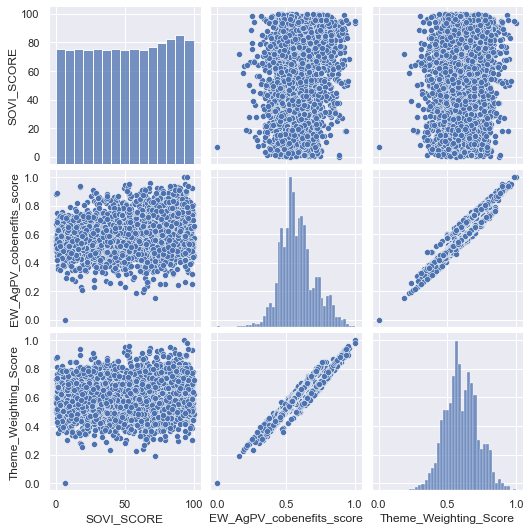

In [167]:
sns.pairplot(export_df[['SOVI_SCORE', 'EW_AgPV_cobenefits_score', 'Theme_Weighting_Score']])

<Axes: >

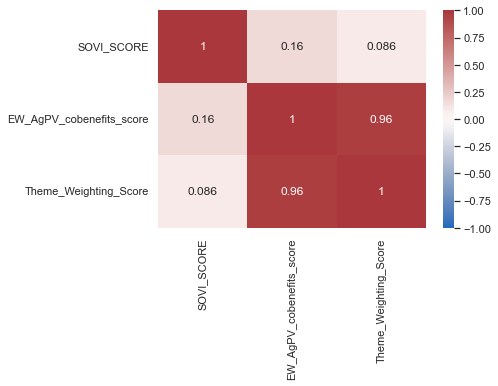

In [168]:
sns.heatmap(export_df[['SOVI_SCORE', 'EW_AgPV_cobenefits_score', 'Theme_Weighting_Score']].corr(), annot=True, cmap='vlag', vmin=-1, vmax=1)

<Axes: xlabel='SOVI_SCORE', ylabel='Theme_Weighting_Score'>

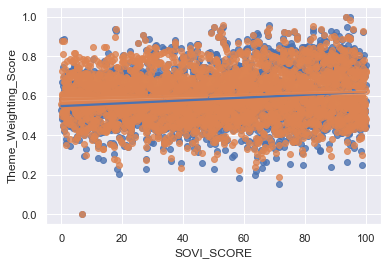

In [169]:
sns.regplot(export_df, x='SOVI_SCORE', y='EW_AgPV_cobenefits_score')
sns.regplot(export_df, x='SOVI_SCORE', y='Theme_Weighting_Score')

In [170]:
print(export_df.Theme_Weighting_Score.quantile([.2, .4, .6, .8]))
print(export_df['EW_AgPV_cobenefits_score'].quantile([.2, .4, .6, .8]))

0.2    0.497617
0.4    0.567247
0.6    0.634301
0.8    0.698878
Name: Theme_Weighting_Score, dtype: float64
0.2    0.479386
0.4    0.541320
0.6    0.602154
0.8    0.678918
Name: EW_AgPV_cobenefits_score, dtype: float64


In [171]:
export_df.loc['04001']

state                                              Arizona
county                                              Apache
capacity_mw_dc                               861473.520644
Solar_supply_per_land_area                       22.165957
RESL_SCORE                                            0.64
SOVI_SCORE                                            96.5
TRND_ALRA                                         0.000006
TRND_EALA                                       129.476307
HWAV_ALRA                                              0.0
HWAV_EALA                                              0.0
HAIL_ALRA                                         0.000008
HAIL_EALA                                       156.914955
DRGT_ALRA                                           0.0302
DRGT_EALA                                    623596.989589
Energy Burden (% income)                               4.0
Percent Non Investor Owned                        5.192231
Value_veggies                                          N

In [172]:
export_df.loc[(~export_df.Ag_compatibility_exists), :].sort_values('Theme_Weighting_Score', ascending=False).head(20)

state                county  capacity_mw_dc  \
FIPS                                                      
05001    Arkansas              Arkansas     7196.072930   
05077    Arkansas                   Lee     5603.481746   
05095    Arkansas                Monroe     3808.468918   
05147    Arkansas              Woodruff     3668.476787   
06003  California                Alpine     2215.787120   
06075  California         San Francisco      110.355375   
08053    Colorado              Hinsdale     1006.113323   
08079    Colorado               Mineral     2121.596314   
08091    Colorado                 Ouray    11135.708378   
08111    Colorado              San Juan       32.788962   
08117    Colorado                Summit     1187.062117   
11001        D.C.  District of Columbia      420.091594   
12037     Florida              Franklin     4116.805026   
12087     Florida                Monroe        4.263192   
13053     Georgia         Chattahoochee     2995.247798   
13089     Georgia                DeKalb     2254.632932   
13215     Georgia              Muscogee     6885.689044   
13259     Georgia               Stewart    35207.428798   
17059    Illinois              Gallatin     6282.652917   
17185    Illinois                Wabash     5152.872224   

       Solar_supply_per_land_area  RESL_SCORE  SOVI_SCORE     TRND_ALRA  \
FIPS                                                                      
05001                    2.089872   49.270000   69.669998  3.208219e-05   
05077                    2.691805    4.900000   97.389999  2.462595e-05   
05095                    1.806463   21.670000   89.620003  3.869929e-05   
05147                    1.803870   18.840000   74.440002  3.444606e-05   
06003                    0.864706   44.779999   50.410000  8.903811e-07   
06075                    0.681104   99.139999   43.220001  5.285694e-07   
08053                    0.259478    8.820000   26.030001  1.449394e-05   
08079                    0.698031   41.980000    7.540000  1.043765e-04   
08091                    5.934469   51.529999    2.740000  8.093794e-07   
08111                    0.024380   49.080002   42.040001  0.000000e+00   
08117                    0.562254   39.049999   19.959999  2.985592e-05   
11001                    1.980228   74.699997   65.019997  0.000000e+00   
12037                    2.176515   28.549999   90.709999  1.995775e-05   
12087                    0.001250   27.879999   69.860001  3.312771e-06   
13053                    3.469680    7.610000   74.279999  3.331424e-05   
13089                    2.427056   31.510000   81.639999  3.101669e-05   
13215                    9.164032   50.860001   94.970001  2.969313e-05   
13259                   22.112616    0.290000   96.370003  5.387406e-05   
17059                    5.605534   13.880000   48.279999  1.167861e-05   
17185                    6.648337   62.990002   40.959999  9.104575e-06   

         TRND_EALA     HWAV_ALRA     HWAV_EALA  ...  Pastureland  \
FIPS                                            ...                
05001  7884.238966  9.992684e-07    245.571460  ...       3211.0   
05077  3674.527055  3.201815e-06    477.754491  ...       1779.0   
05095  4267.232549  1.046853e-06    115.432701  ...        524.0   
05147  4774.551915  1.179616e-06    163.506057  ...       1145.0   
06003     2.027598  3.024663e-08      0.068878  ...          0.0   
06075    19.943762  1.437000e-10      0.005422  ...          0.0   
08053    15.319120  0.000000e+00      0.000000  ...          0.0   
08079     9.576544  0.000000e+00      0.000000  ...       3712.0   
08091     3.902568  0.000000e+00      0.000000  ...      58003.0   
08111     0.000000  0.000000e+00      0.000000  ...          0.0   
08117    51.106315  0.000000e+00      0.000000  ...       9191.0   
11001     0.000000  0.000000e+00      0.000000  ...          0.0   
12037     0.872174  2.232656e-06      0.097569  ...        860.0   
12087    14.951763  0.000000e+00      0.00

### Comparing Methods for Index Calculation
I'm testing out 2 different ways of calculating index: equally weighting all variables, and first grouping variables into themes, averaging those themes, then averageing the themes. This "Theme" method will effectively add different weights to the index.

In [173]:
# export comparison of top n counties with each scoring method
n_count = 50
percentile = 0.95
threshold = export_quantile_df.loc[percentile, 'Theme_Weighting_Score']
ew_thresh = export_quantile_df.loc[percentile, 'EW_AgPV_cobenefits_score']

equal_weights = score_df[score_df['EW_AgPV_cobenefits_score'] > ew_thresh].sort_values(['EW_AgPV_cobenefits_score'], ascending=False, ignore_index=True)
themes = score_df[score_df['Theme_Weighting_Score'] > threshold].sort_values(['Theme_Weighting_Score'], ascending=False, ignore_index=True)

method_comp = pd.concat([equal_weights[['county', 'state', 'EW_AgPV_cobenefits_score']], themes[['county', 'state', 'Theme_Weighting_Score']]], axis=1)
method_comp.to_csv(f'score_method_top_{(1 - percentile) * 100}pct_comp.csv')
method_comp

county       state  EW_AgPV_cobenefits_score      county  \
0      Cherokee    Oklahoma                  1.000000    San Juan   
1      San Juan  New Mexico                  0.998245    Cherokee   
2          Mesa    Colorado                  0.960262  Montgomery   
3       Socorro  New Mexico                  0.949455     Lubbock   
4    Montgomery       Texas                  0.947689       Creek   
..          ...         ...                       ...         ...   
145  Bernalillo  New Mexico                  0.822072        Utah   
146     Douglas    Missouri                  0.821714       Smith   
147      Newton    Missouri                  0.820878    Anderson   
148  Kingfisher    Oklahoma                  0.820246       Caddo   
149    Pontotoc    Oklahoma                  0.819733        Rusk   

              state  Theme_Weighting_Score  
0        New Mexico               1.000000  
1          Oklahoma               0.983152  
2             Texas               0.958054  
3             Texas               0.955493  
4          Oklahoma               0.950165  
..              ...                    ...  
145            Utah               0.806743  
146           Texas               0.806043  
147  South Carolina               0.806024  
148       Louisiana               0.805978  
149           Texas               0.805902  

[150 rows x 6 columns]

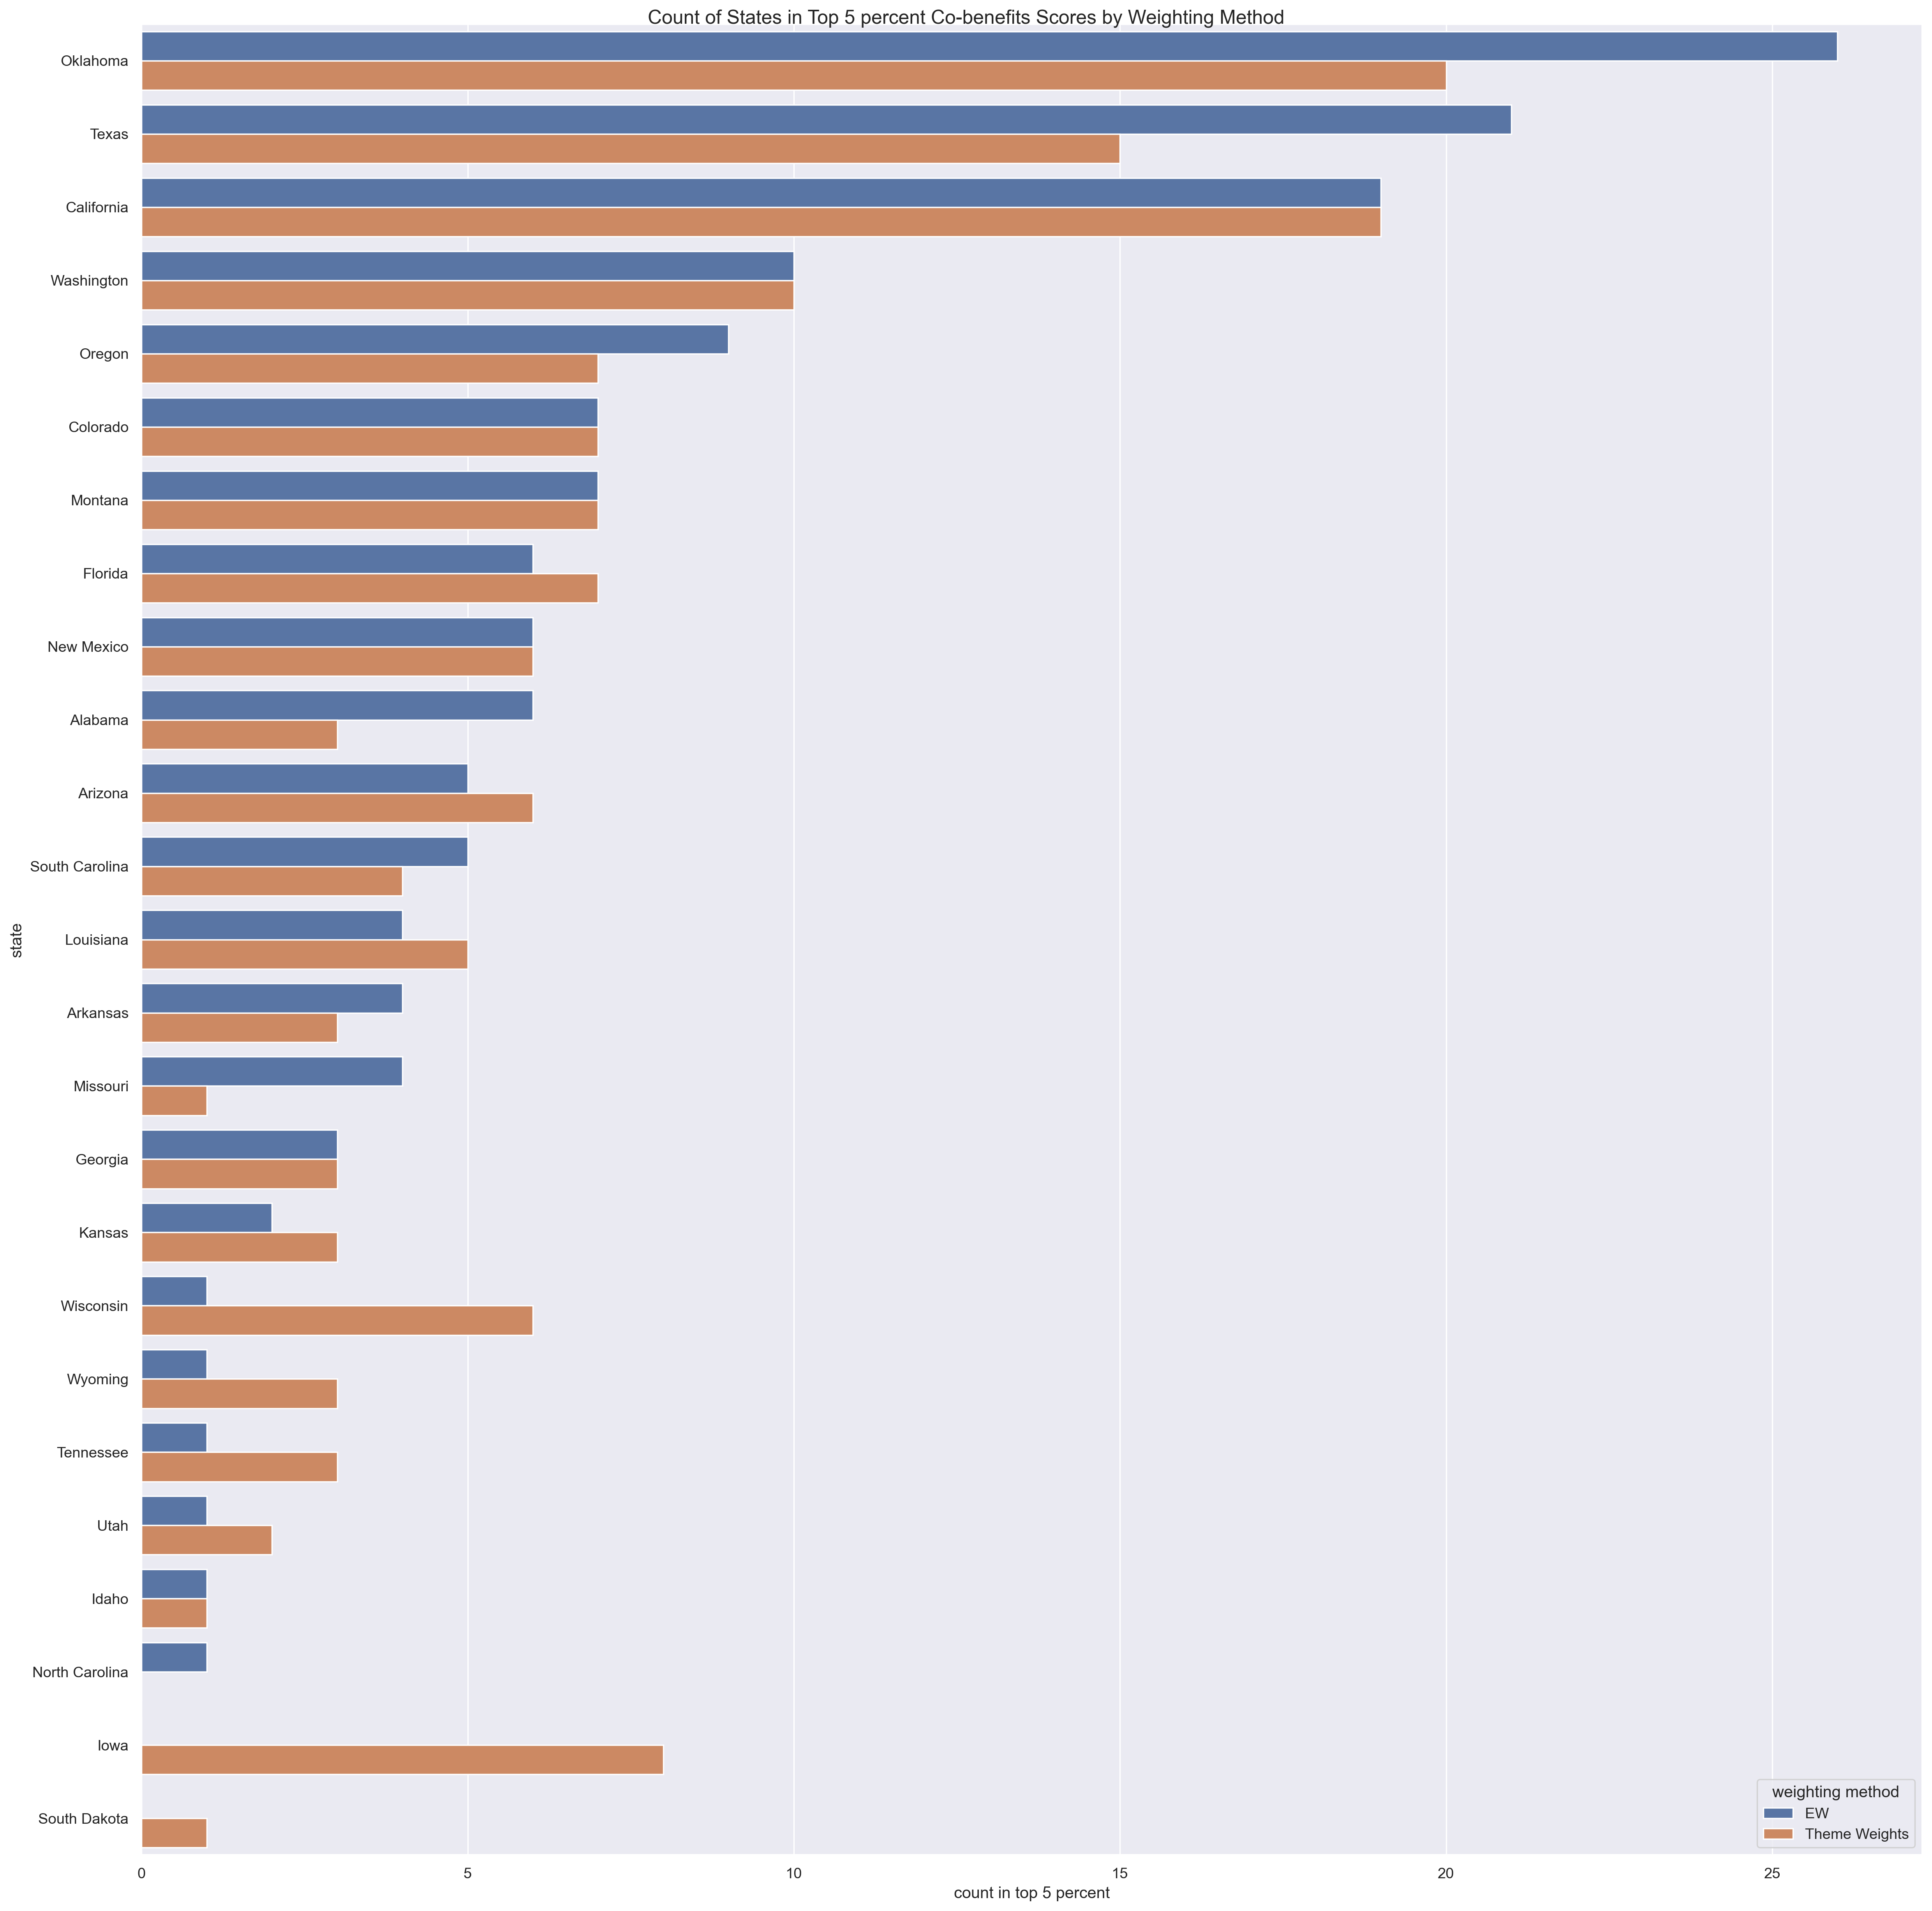

In [175]:
counts_df = pd.DataFrame()

ew_df = pd.DataFrame(equal_weights['state'].value_counts(ascending=False)).rename(columns={'count':'EW'})
tw_df = pd.DataFrame(themes['state'].value_counts(ascending=False)).rename(columns={'count':'Theme Weights'})
counts_df = pd.concat([ew_df, tw_df], axis=1)
counts_df = counts_df.fillna(0)
counts_df['Theme Weights'] = counts_df['Theme Weights'].astype(int)
counts_df['EW'] = counts_df['EW'].astype(int)

counts_df = counts_df.sort_values(['EW', 'Theme Weights'], ascending=[False, False])

value_name = f'count in top {(1-percentile) * 100:.0f} percent'
counts_df = counts_df.reset_index().melt(id_vars='state', value_name=value_name, var_name='weighting method')

fig, ax = plt.subplots(1, 1, dpi=250, figsize=(20,20))
g = sns.barplot(counts_df, y='state', x=value_name, hue='weighting method', ax=ax)
plt.suptitle(f'Count of States in Top {(1-percentile) * 100:.0f} percent Co-benefits Scores by Weighting Method')
plt.tight_layout()
plt.savefig(os.path.join(graph_dir, 'score_weight_state_comp2.png'))

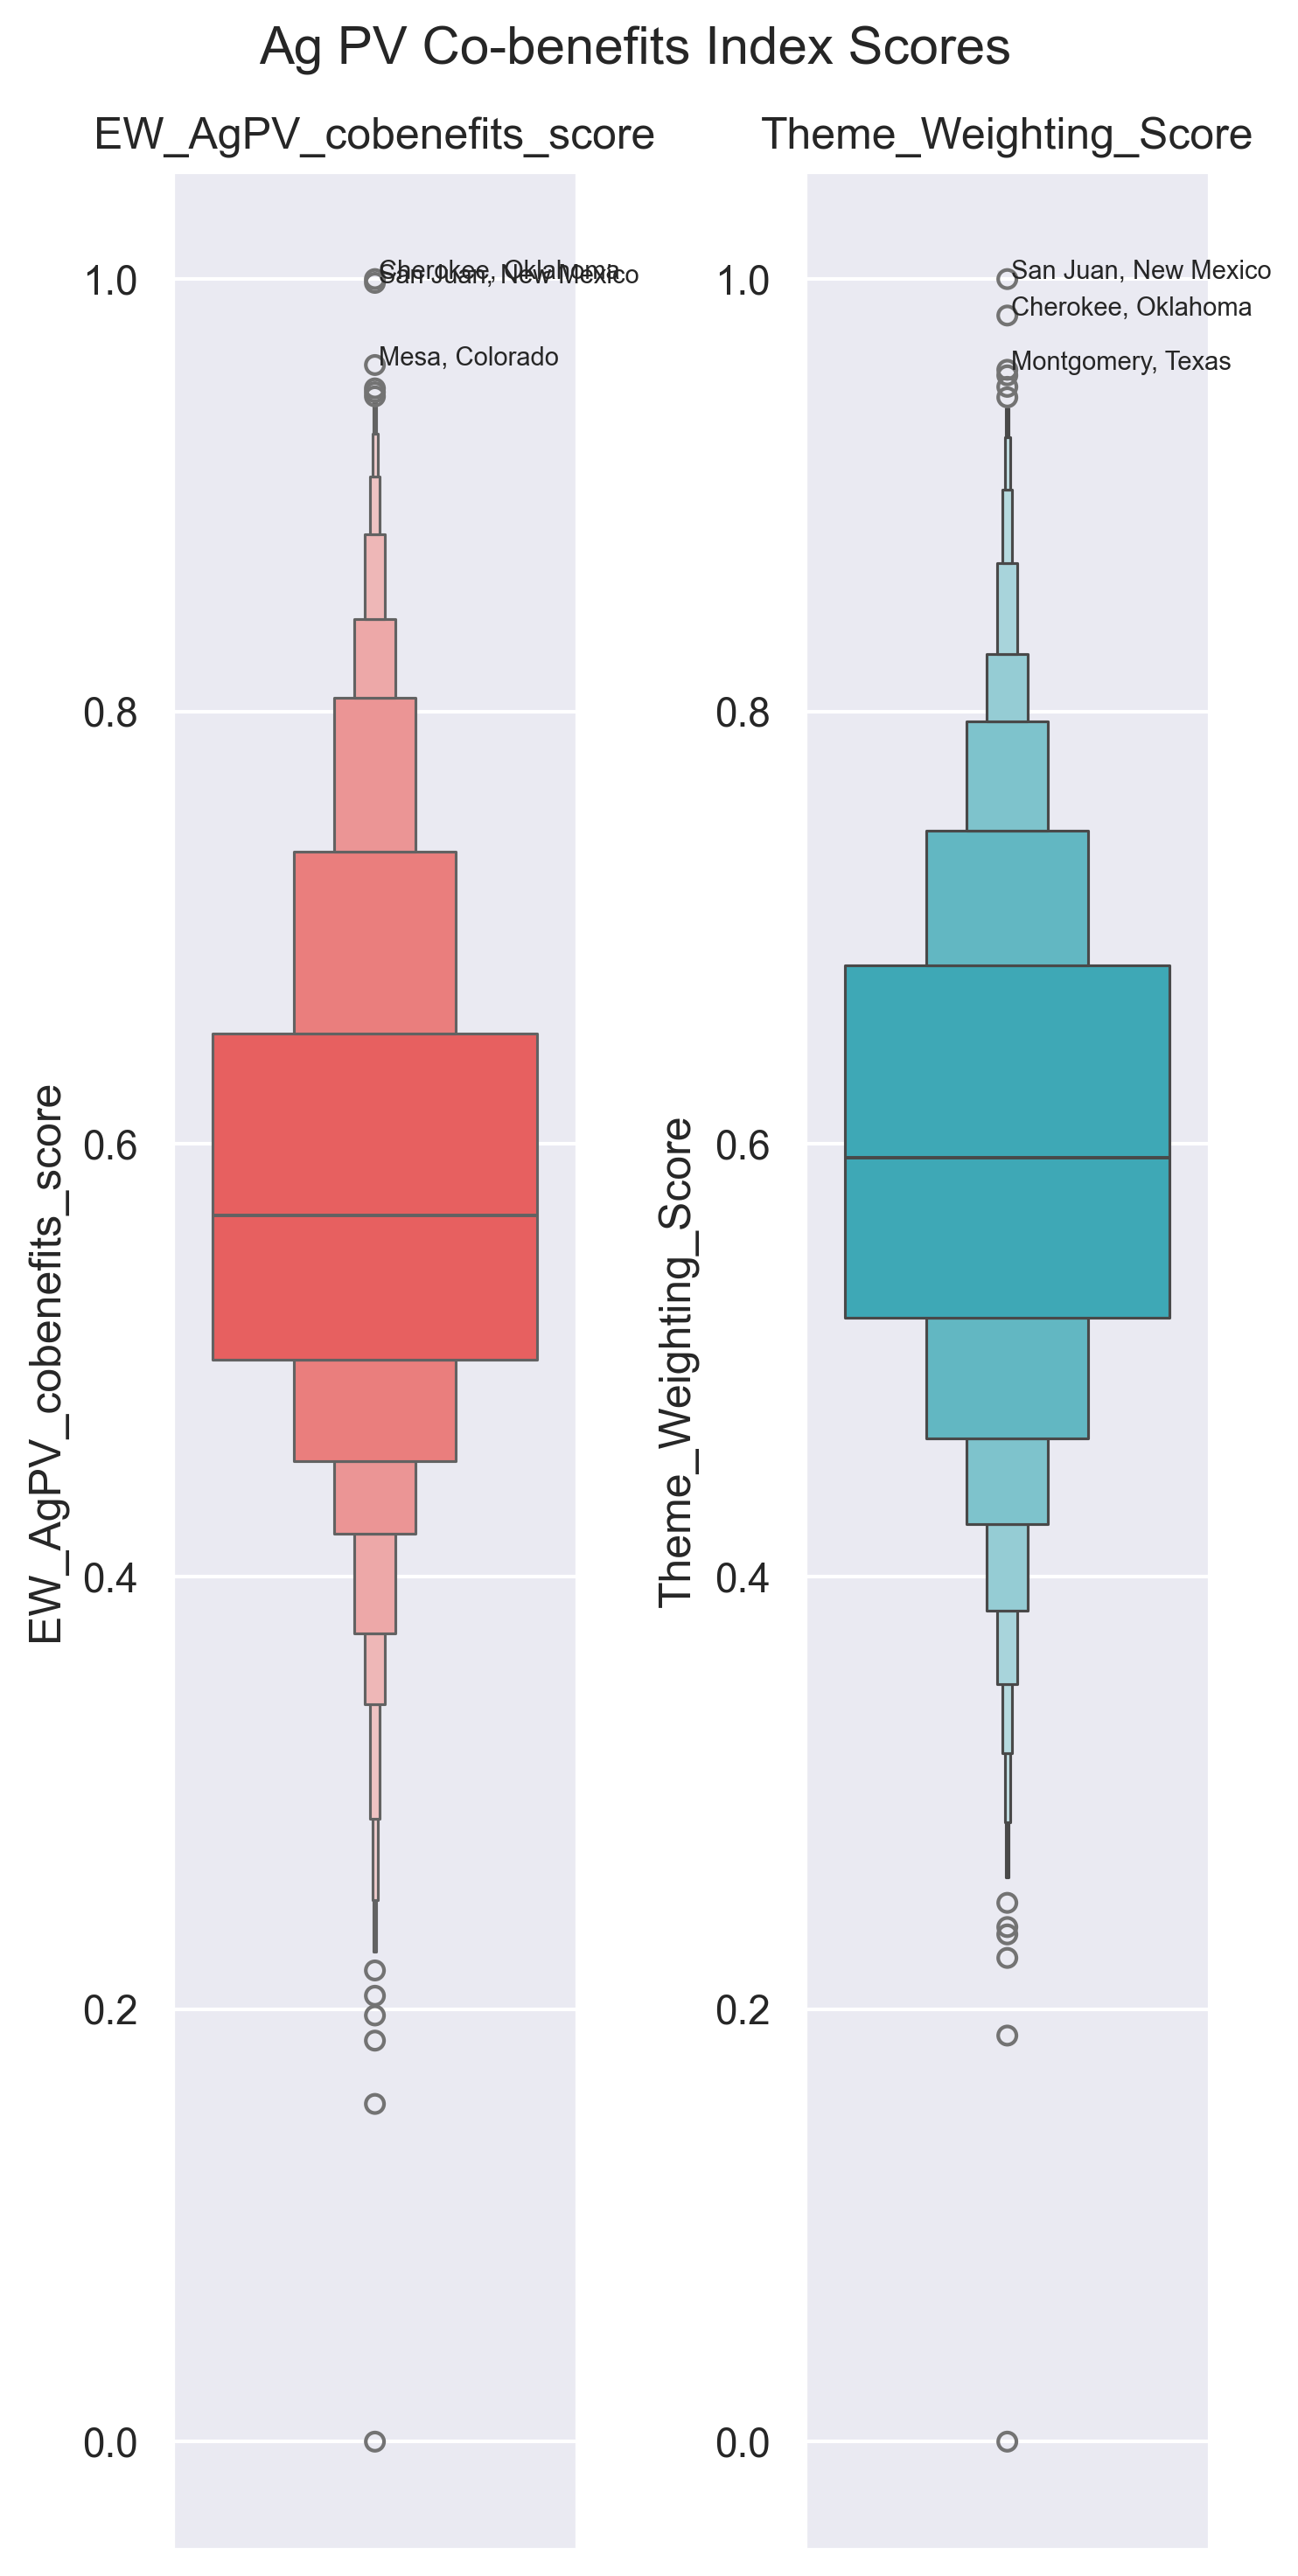

In [176]:
fig, axes = plt.subplots(1,2, figsize=(5,10), dpi=300)

# annotate top n outliers
def annotate_outliers(row, col, g):
    text = ', '.join([row['county'], row['state']])
    y = row[col]
    g.annotate(text, xy=(0.01, y), ha='left', size=7)
    
colors = iter(['#FE4A49', '#2AB7CA'])

for metric, ax in zip(['EW_AgPV_cobenefits_score', 'Theme_Weighting_Score'], axes):
    g = sns.boxenplot(score_df, y=metric, ax=ax, color=next(colors))
    score_df.sort_values(metric, ascending=False).iloc[:3].apply(lambda x: annotate_outliers(x, metric, g), axis=1)
    ax.title.set_text(metric)

fig.suptitle('Ag PV Co-benefits Index Scores')
plt.tight_layout()
plt.savefig(os.path.join(graph_dir, 'agpv_score_boxen.png'))

In [177]:
merged_df.rank(pct=True).loc['40021', :]

state                                        0.690956
county                                       0.151431
capacity_mw_ac                               0.734873
capacity_mw_dc                               0.734873
Solar_supply_per_land_area                   0.743331
RESL_SCORE                                   0.189310
SOVI_SCORE                                   0.946911
TRND_ALRA                                    0.861042
TRND_EALA                                    0.733871
TRND_RISKV                                   0.825008
TRND_RISKS                                   0.825008
HWAV_ALRA                                    0.603064
HWAV_EALA                                    0.651192
HWAV_RISKV                                   0.952593
HWAV_RISKS                                   0.952593
HAIL_ALRA                                    0.301489
HAIL_EALA                                    0.357940
HAIL_RISKV                                   0.531021
HAIL_RISKS                  

In [179]:
score_df.loc[['08031'], :].T #.sort_values('Theme_Weighting_Score')

FIPS                                             08031
state                                         Colorado
county                                          Denver
capacity_mw_dc                             5334.183122
Solar_supply_per_land_area                    10.04069
RESL_SCORE                                   54.389999
SOVI_SCORE                                   58.209999
TRND_ALRA                                     0.000064
TRND_EALA                                   114.654391
HWAV_ALRA                                          0.0
HWAV_EALA                                          0.0
HAIL_ALRA                                     0.002656
HAIL_EALA                                     4764.999
DRGT_ALRA                                     0.000223
DRGT_EALA                                   400.834118
Energy Burden (% income)                           1.0
Percent Non Investor Owned                         0.0
Value_veggies                                        0
Has_undisclosed_veggies                           True
Value_berries                                      NaN
Has_undisclosed_berries                          False
AgPV_crop_totals                                     0
Sheep_goats_total_sales                              0
Has_undisclosed_goats_sheep_totals                True
Percent Woman-owned Sheep Goats Producers          0.0
Percent Nonwhite Sheep Goats Producers             0.0
Avg Farm Net Income ($)                        -3380.0
Has_undisclosed_farm_income                      False
Percent Woman-owned Cropland                       0.0
Percent Non-white Cropland                         0.0
Pastureland                                        0.0
Has_undisclosed_pastureland                       True
tonne_co2_per_person                         15.183116
SolarPanelLandUse                                  0.3
ag_worker_heat_days                           22173.25
Ag_compatibility_exists                           True
eala_sum_positive                          5165.833118
eala_net                                   5051.178727
EW_AgPV_cobenefits_score                      0.185439
Theme_Weighting_Score                         0.223683

### East v West Analysis
Check if west has more opportunity than east

In [180]:
quantile_thresh = 0.8
thresh_value = export_quantile_df.loc[quantile_thresh, 'Theme_Weighting_Score']
export_quantile_df

capacity_mw_dc  Solar_supply_per_land_area  RESL_SCORE  SOVI_SCORE  \
quantile                                                                       
0.20         7002.081019                    4.272663   20.002000   20.500000   
0.40        13783.497159                    7.185803   40.001999   40.990002   
0.60        23373.027742                   10.418095   59.998001   61.459999   
0.80        43401.939688                   14.844122   79.998003   81.379997   
0.95       127757.115112                   21.219952   94.997000   95.230003   

          TRND_ALRA     TRND_EALA     HWAV_ALRA     HWAV_EALA  HAIL_ALRA  \
quantile                                                                   
0.20       0.000007    151.330615  0.000000e+00      0.000000   0.000007   
0.40       0.000016    754.386515  3.932054e-07     13.865920   0.000034   
0.60       0.000025   1997.789569  3.721096e-06    166.322881   0.000139   
0.80       0.000038   4754.976864  3.419193e-05   2676.971243   0.000434   
0.95       0.000072  12829.927929  1.058098e-04  18056.026930   0.001648   

              HAIL_EALA  ...  Percent Woman-owned Cropland  \
quantile                 ...                                 
0.20         243.787010  ...                          17.0   
0.40        1563.702314  ...                          31.0   
0.60        7814.164822  ...                          49.0   
0.80       41275.154556  ...                          74.0   
0.95      304080.867575  ...                          91.0   

          Percent Non-white Cropland  Pastureland  tonne_co2_per_person  \
quantile                                                                  
0.20                             0.0      2754.00             11.088011   
0.40                             0.0      9299.00             15.345368   
0.60                             0.0     26854.00             21.161984   
0.80                             0.0    126518.00             22.341196   
0.95                            78.0    548160.25             41.797864   

          SolarPanelLandUse  ag_worker_heat_days  eala_sum_positive  \
quantile                                                              
0.20                   0.05                 0.00       4.100562e+03   
0.40                   0.05               215.25       2.475993e+04   
0.60                   0.05               643.50       9.090915e+04   
0.80                   0.30              1561.00       3.379252e+05   
0.95                   2.05              6070.25       1.364656e+06   

              eala_net  EW_AgPV_cobenefits_score  Theme_Weighting_Score  
quantile                                                                 
0.20      2.860964e+03                  0.479386               0.497617  
0.40      2.224443e+04                  0.541320               0.567247  
0.60      8.761326e+04                  0.602154               0.634301  
0.80      3.338668e+05                  0.678918               0.698878  
0.95      1.353494e+06                  0.819696               0.805869  

[5 rows x 29 columns]

In [181]:
regional_df = export_df.merge(state_df, left_on='state', right_on='Name')
regional_df = regional_df[['state', 'county', 'Region', 'capacity_mw_dc', 'Theme_Weighting_Score', 'EW_AgPV_cobenefits_score']]
regional_df.loc[regional_df['Theme_Weighting_Score'] > thresh_value, ['Region', 'capacity_mw_dc', 'EW_AgPV_cobenefits_score', 'Theme_Weighting_Score']].groupby('Region').count()

capacity_mw_dc  EW_AgPV_cobenefits_score  Theme_Weighting_Score
Region                                                                 
East               169                       169                    169
West               425                       425                    425

In [184]:
from scipy import stats

topn_df = regional_df.loc[regional_df['Theme_Weighting_Score'] > thresh_value, :]

for col in ['capacity_mw_dc', 'Theme_Weighting_Score', 'EW_AgPV_cobenefits_score']:
    print(f'Testing {col}...')
    a = topn_df.loc[regional_df['Region'] == 'West', col]
    b = topn_df.loc[regional_df['Region'] == 'East', col]

    # is West greater than east?
    print('T-test', a.mean(), b.mean())
    print(stats.ttest_ind(a, b, alternative='greater'), '\n')
    
    # are the raw counts the same in the top n pct?
    print('Chi Square:', len(a), len(b))
    print(stats.chisquare([len(a), len(b)]), '\n')
    
    # are the counties in west ranked higher than the counties in east?
    print('Man Whitney U Test')
    print(stats.mannwhitneyu(a, b, alternative='greater'))
    print('-'*20)
    print('\n')

Testing capacity_mw_dc...
T-test 66504.17400302272 21779.848485692448
Ttest_indResult(statistic=5.109889440008516, pvalue=2.177746073766701e-07) 

Chi Square: 425 169
Power_divergenceResult(statistic=110.32996632996633, pvalue=8.29649502266096e-26) 

Man Whitney U Test
MannwhitneyuResult(statistic=49803.0, pvalue=9.173642633911927e-14)
--------------------


Testing Theme_Weighting_Score...
T-test 0.7777480061646359 0.7651252045225976
Ttest_indResult(statistic=2.3825686787594678, pvalue=0.008753486229545603) 

Chi Square: 425 169
Power_divergenceResult(statistic=110.32996632996633, pvalue=8.29649502266096e-26) 

Man Whitney U Test
MannwhitneyuResult(statistic=39507.0, pvalue=0.028424996590021123)
--------------------


Testing EW_AgPV_cobenefits_score...
T-test 0.768382902159057 0.7457295724815126
Ttest_indResult(statistic=3.190526916992495, pvalue=0.0007476388101305457) 

Chi Square: 425 169
Power_divergenceResult(statistic=110.32996632996633, pvalue=8.29649502266096e-26) 

Man Whitne

## Clustering
Let's do some simple unsupervised learning on this data set. Maybe using clusters can provide more nuaced themes and analysis for groups that a single number might overlook.

This [post](https://medium.com/@jackiee.jecksom/clustering-and-principal-component-analysis-pca-from-sklearn-c8ea5fed6648) has some cool visualization ideas: 

In [183]:
test_df = merged_df[index_vars]
test_df[test_df.isna().any(axis=1)]

eala_net  Energy Burden (% income)  Avg Farm Net Income ($)  \
FIPS                                                                      
11001       0.000000                       1.0                      0.0   
44001    3882.063445                       2.0                   5948.0   
44003   23022.454676                       3.0                  -1660.0   
44005  146917.653391                       3.0                  25747.0   
44007   84129.624359                       3.0                    411.0   
...              ...                       ...                      ...   
02232       0.000000                       NaN                      0.0   
11031       0.000000                       NaN                      0.0   
02010       0.000000                       NaN                      0.0   
02          0.000000                       NaN                      0.0   
02261       0.000000                       NaN                      0.0   

       Percent Non-white Cropland  Percent Non Investor Owned  \
FIPS                                                            
11001                         0.0                         0.0   
44001                         0.0                         0.0   
44003                         0.0                         0.0   
44005                         0.0                         0.0   
44007                         0.0                         0.0   
...                           ...                         ...   
02232                         0.0                         0.0   
11031                         0.0                         0.0   
02010                         0.0                         0.0   
02                           60.0                         0.0   
02261                         0.0                         0.0   

       Percent Woman-owned Cropland  AgPV_crop_totals  \
FIPS                                                    
11001                           0.0                 0   
44001                          33.0                 0   
44003                          23.0                16   
44005                          47.0                85   
44007                          26.0                51   
...                             ...               ...   
02232                           0.0                 0   
11031                           0.0                 0   
02010                           0.0                 0   
02                             22.2                 0   
02261                           0.0                 0   

       Sheep_goats_total_sales  Percent Nonwhite Sheep Goats Producers  \
FIPS                                                                     
11001                        0                                     0.0   
44001                        0                                     0.0   
44003                    11000                                     0.0   
44005                    46000                                     0.0   
44007                   115000                                     0.0   
...                        ...                                     ...   
02232                        0                                     0.0   
11031                        0                                     0.0   
02010                        0                                     0.0   
02                           0                                     0.0   
02261                        0                                     0.0   

       Percent Woman-owned Sheep Goats Producers  tonne_co2_per_person  \
FIPS                                                                     
11001                                        0.0                   NaN   
44001                                       34.0                   NaN   
44003                                       14.0                   NaN   
44005                                       39.0                   NaN   
44007                                    

<Axes: >

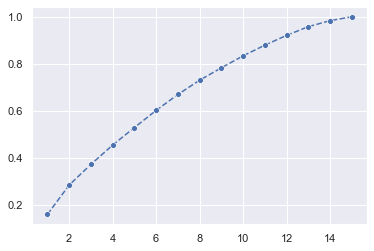

In [263]:
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, AffinityPropagation

cluster_vars = index_vars + ['capacity_mw_dc', 'SOVI_SCORE']
to_cluster_df = merged_df[cluster_vars].dropna() # merged_df.loc[(merged_df['AgPV_crop_totals'] > 0) | (merged_df['Sheep_goats_total_sales'] > 0), cluster_vars]

# normalize data
X_norm = StandardScaler().fit_transform(to_cluster_df)

# principal component analysis
kpca = KernelPCA(kernel='linear')
kpca.fit(X_norm)
scores_kpca = kpca.transform(X_norm)

# get percent variance explained
explained_variance = np.var(scores_kpca, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)

sns.lineplot(x=range(1, len(explained_variance_ratio) + 1), y=explained_variance_ratio.cumsum(), marker='o', linestyle='--')

In [264]:
n_comps=11
pca = KernelPCA(n_components=n_comps, kernel='linear')
pca.fit(X_norm)
scores_pca = pca.transform(X_norm)

k_values = range(2,21)
# clustering
WCSS = [] # holds within cluster sum of squares for eack value of k

for k in k_values:
    kmeans_pca = KMeans(n_clusters=k, init='k-means++', random_state=123)
    kmeans_pca.fit(scores_pca)
    WCSS.append(kmeans_pca.inertia_)

C:\Users\stanley27\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\stanley27\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\stanley27\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\stanley27\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. 

Text(0, 0.5, 'WCSS')

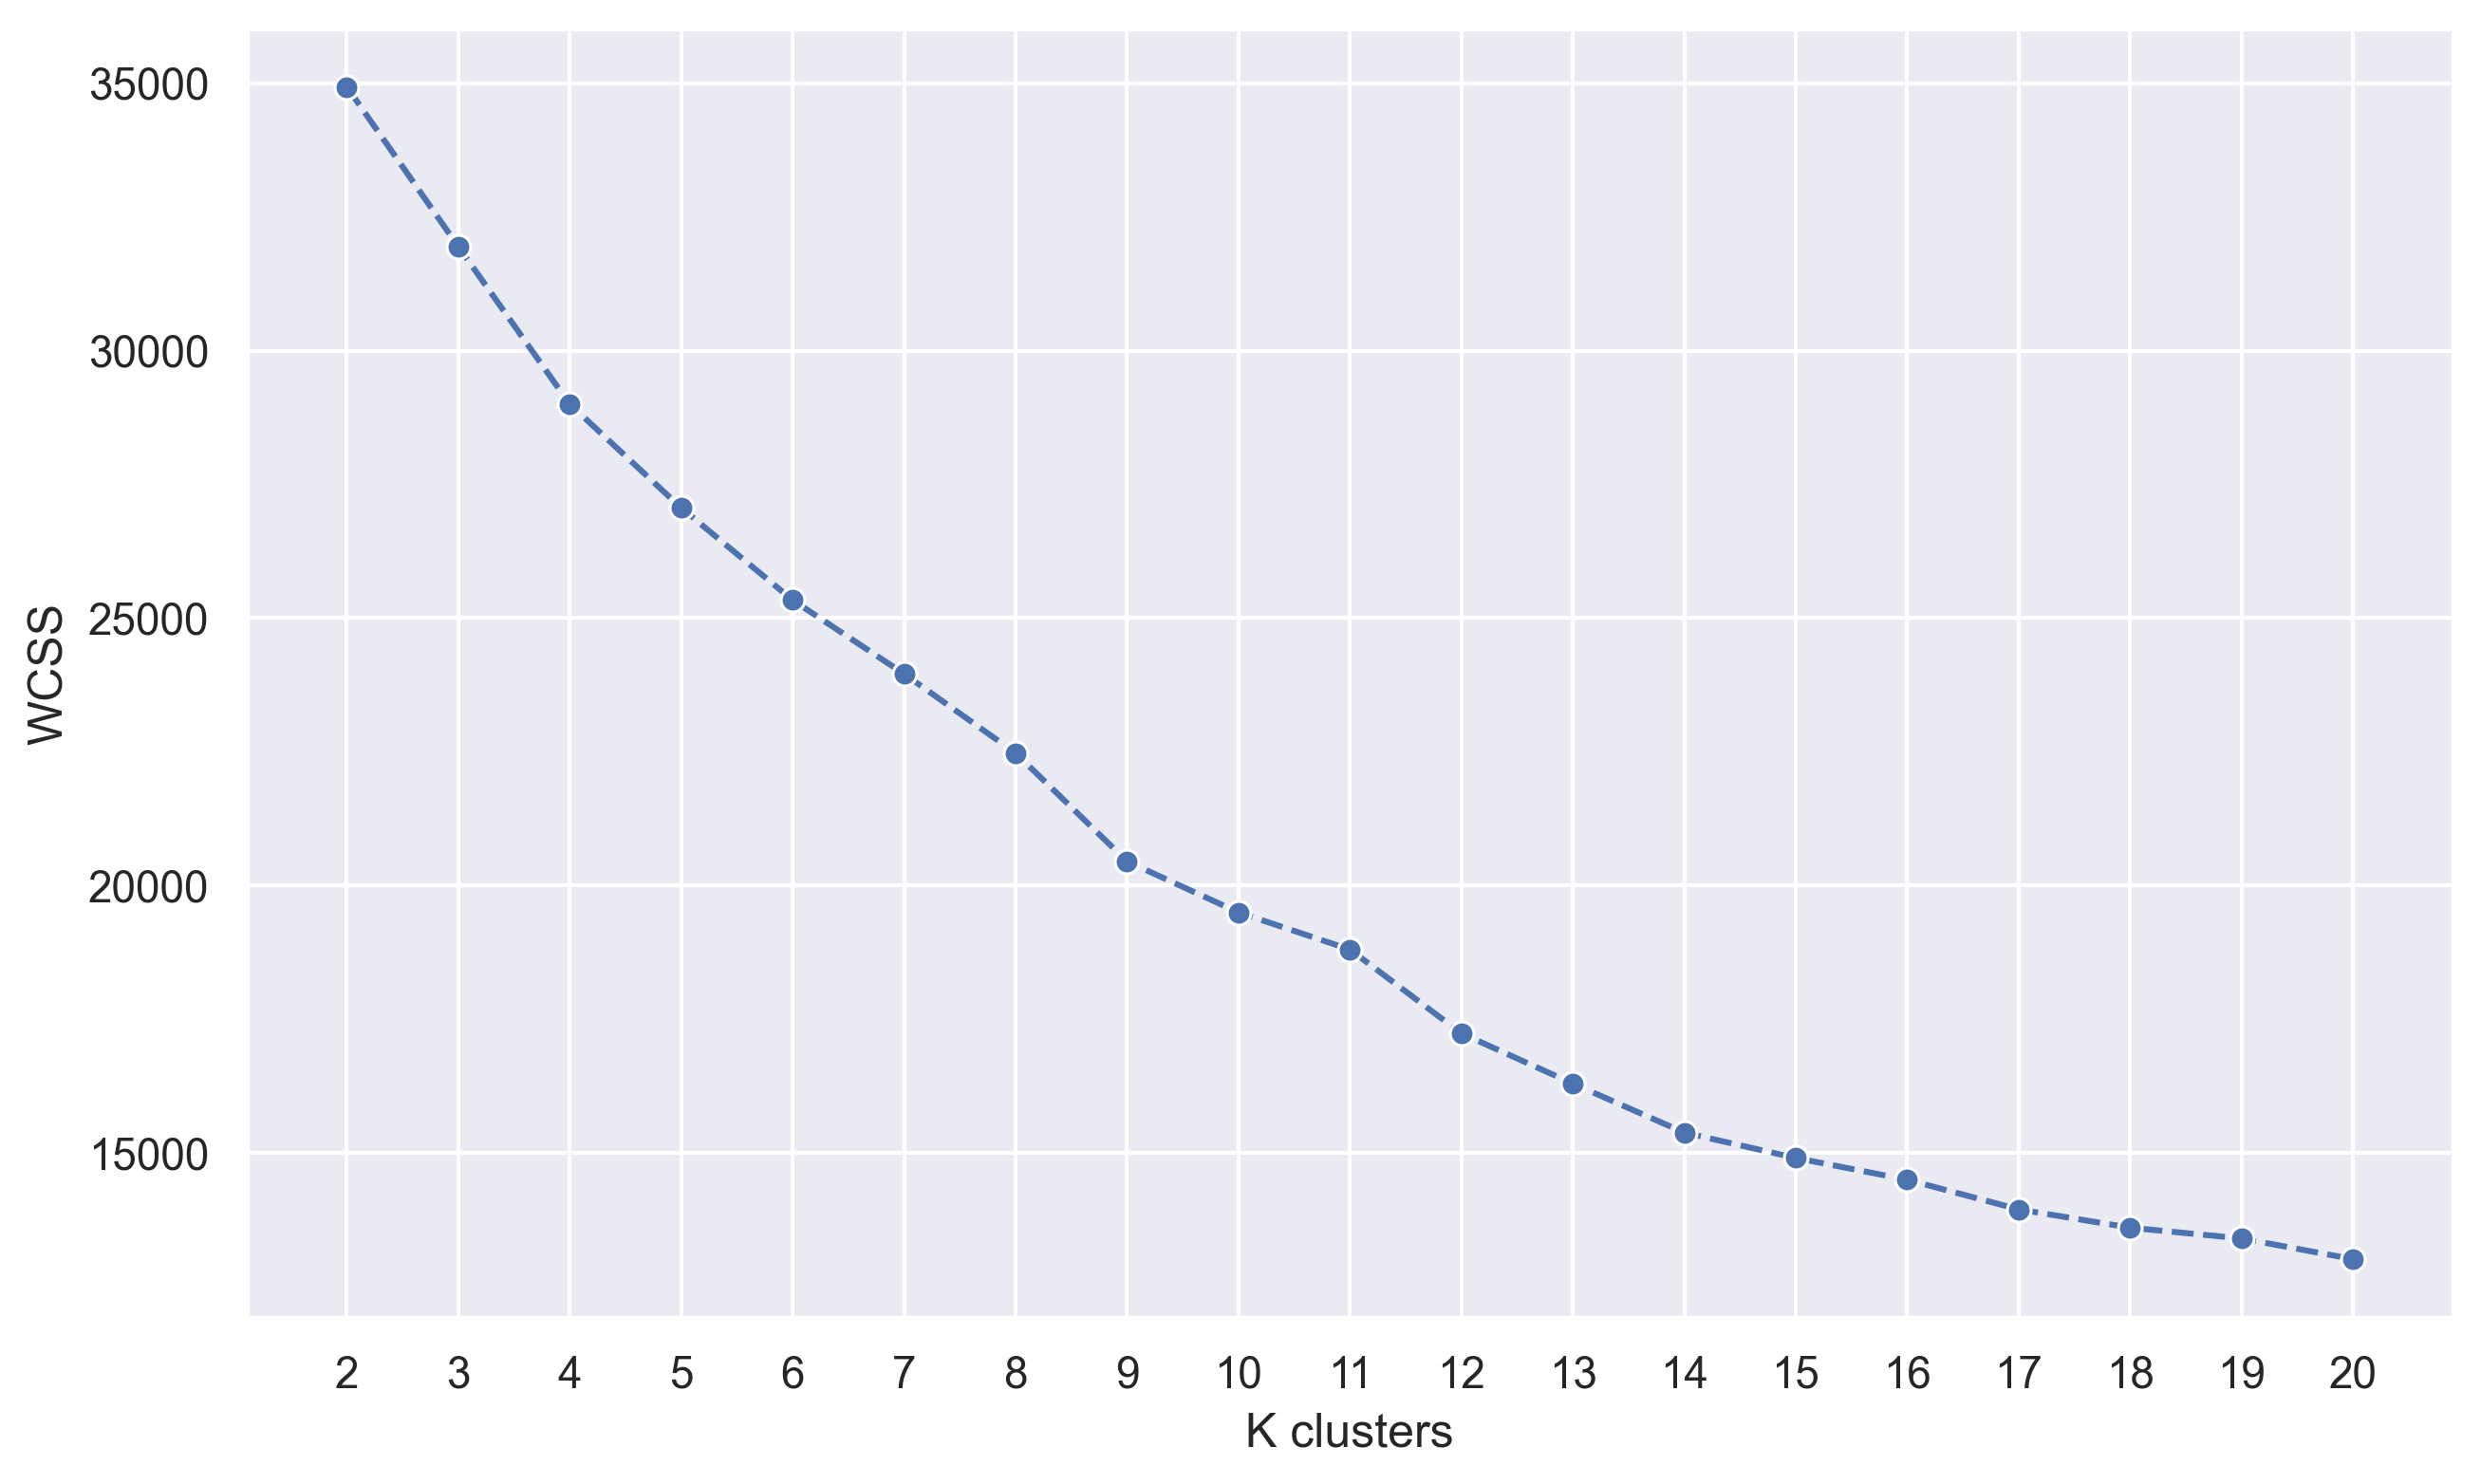

In [265]:
plt.figure(figsize=(10,6), dpi=300)
g = sns.lineplot(x=k_values, y=WCSS, marker='o', linestyle='--')
g.set_xticks(k_values)
g.set_xlabel('K clusters')
g.set_ylabel('WCSS')

There's no clear elbow point.

In [266]:
k = 9
kmeans_pca = KMeans(n_clusters=k, init='k-means++', random_state=123)
kmeans_pca.fit(scores_pca)

C:\Users\stanley27\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=9, random_state=123)

In [267]:
# Add pricipal components to original df
pc_col_names = ['PC' + str(k + 1) for k in range(n_comps)]
cluster_df = pd.concat([to_cluster_df, pd.DataFrame(scores_pca, columns=pc_col_names, index=to_cluster_df.index)], axis=1)

# add labels from kmeans
cluster_df['Cluster'] = kmeans_pca.labels_
cluster_df['Cluster'] = cluster_df['Cluster'].astype(str)
cluster_df

eala_net  Energy Burden (% income)  Avg Farm Net Income ($)  \
FIPS                                                                      
01001   20828.748821                       3.0                  29477.0   
01003  443676.897072                       2.0                  36125.0   
01005  196296.181220                       4.0                 122245.0   
01007    4751.245599                       4.0                   1623.0   
01009   10964.282012                       3.0                 120481.0   
...              ...                       ...                      ...   
56037    3454.037437                       2.0                  36158.0   
56039    1504.537027                       2.0                  12579.0   
56041    2538.875689                       3.0                  19121.0   
56043   13932.467121                       4.0                  90376.0   
56045    -530.078908                       7.0                  23922.0   

       Percent Non-white Cropland  Percent Non Investor Owned  \
FIPS                                                            
01001                        68.0                    2.942734   
01003                         0.0                    9.632698   
01005                        74.0                    4.668915   
01007                         0.0                    2.942734   
01009                         0.0                    0.000000   
...                           ...                         ...   
56037                         0.0                    0.003478   
56039                         0.0                   22.753224   
56041                         0.0                    0.000000   
56043                         0.0                    8.685847   
56045                         0.0                   91.119574   

       Percent Woman-owned Cropland  AgPV_crop_totals  \
FIPS                                                    
01001                          32.0                 0   
01003                          33.0               117   
01005                          28.0                 0   
01007                          21.0                 0   
01009                          24.0                 0   
...                             ...               ...   
56037                          13.0                 0   
56039                          29.0                 0   
56041                          11.0                 0   
56043                          17.0                 0   
56045                           3.0                 0   

       Sheep_goats_total_sales  Percent Nonwhite Sheep Goats Producers  \
FIPS                                                                     
01001                    78000                                    73.0   
01003                   136000                                     0.0   
01005                    22000                                    11.0   
01007                    72000                                     0.0   
01009                   111000                                     0.0   
...                        ...                                     ...   
56037                        0                                     0.0   
56039                     7000                                     0.0   
56041                  4764000                                     0.0   
56043                        0                                     0.0   
56045                    76000                                     0.0   

       Percent Woman-owned Sheep Goats Producers  ...       PC3       PC4  \
FIPS                                              ...                       
01001                                       18.0  ... -1.226002 -1.131730   
01003                                       11.0  ... -0.456285  1.134952   
01005                                       87.0  ...  0.650636 -1.182872   
01007                                       19.0  ... -0.177553 -0.189375   
01009                  

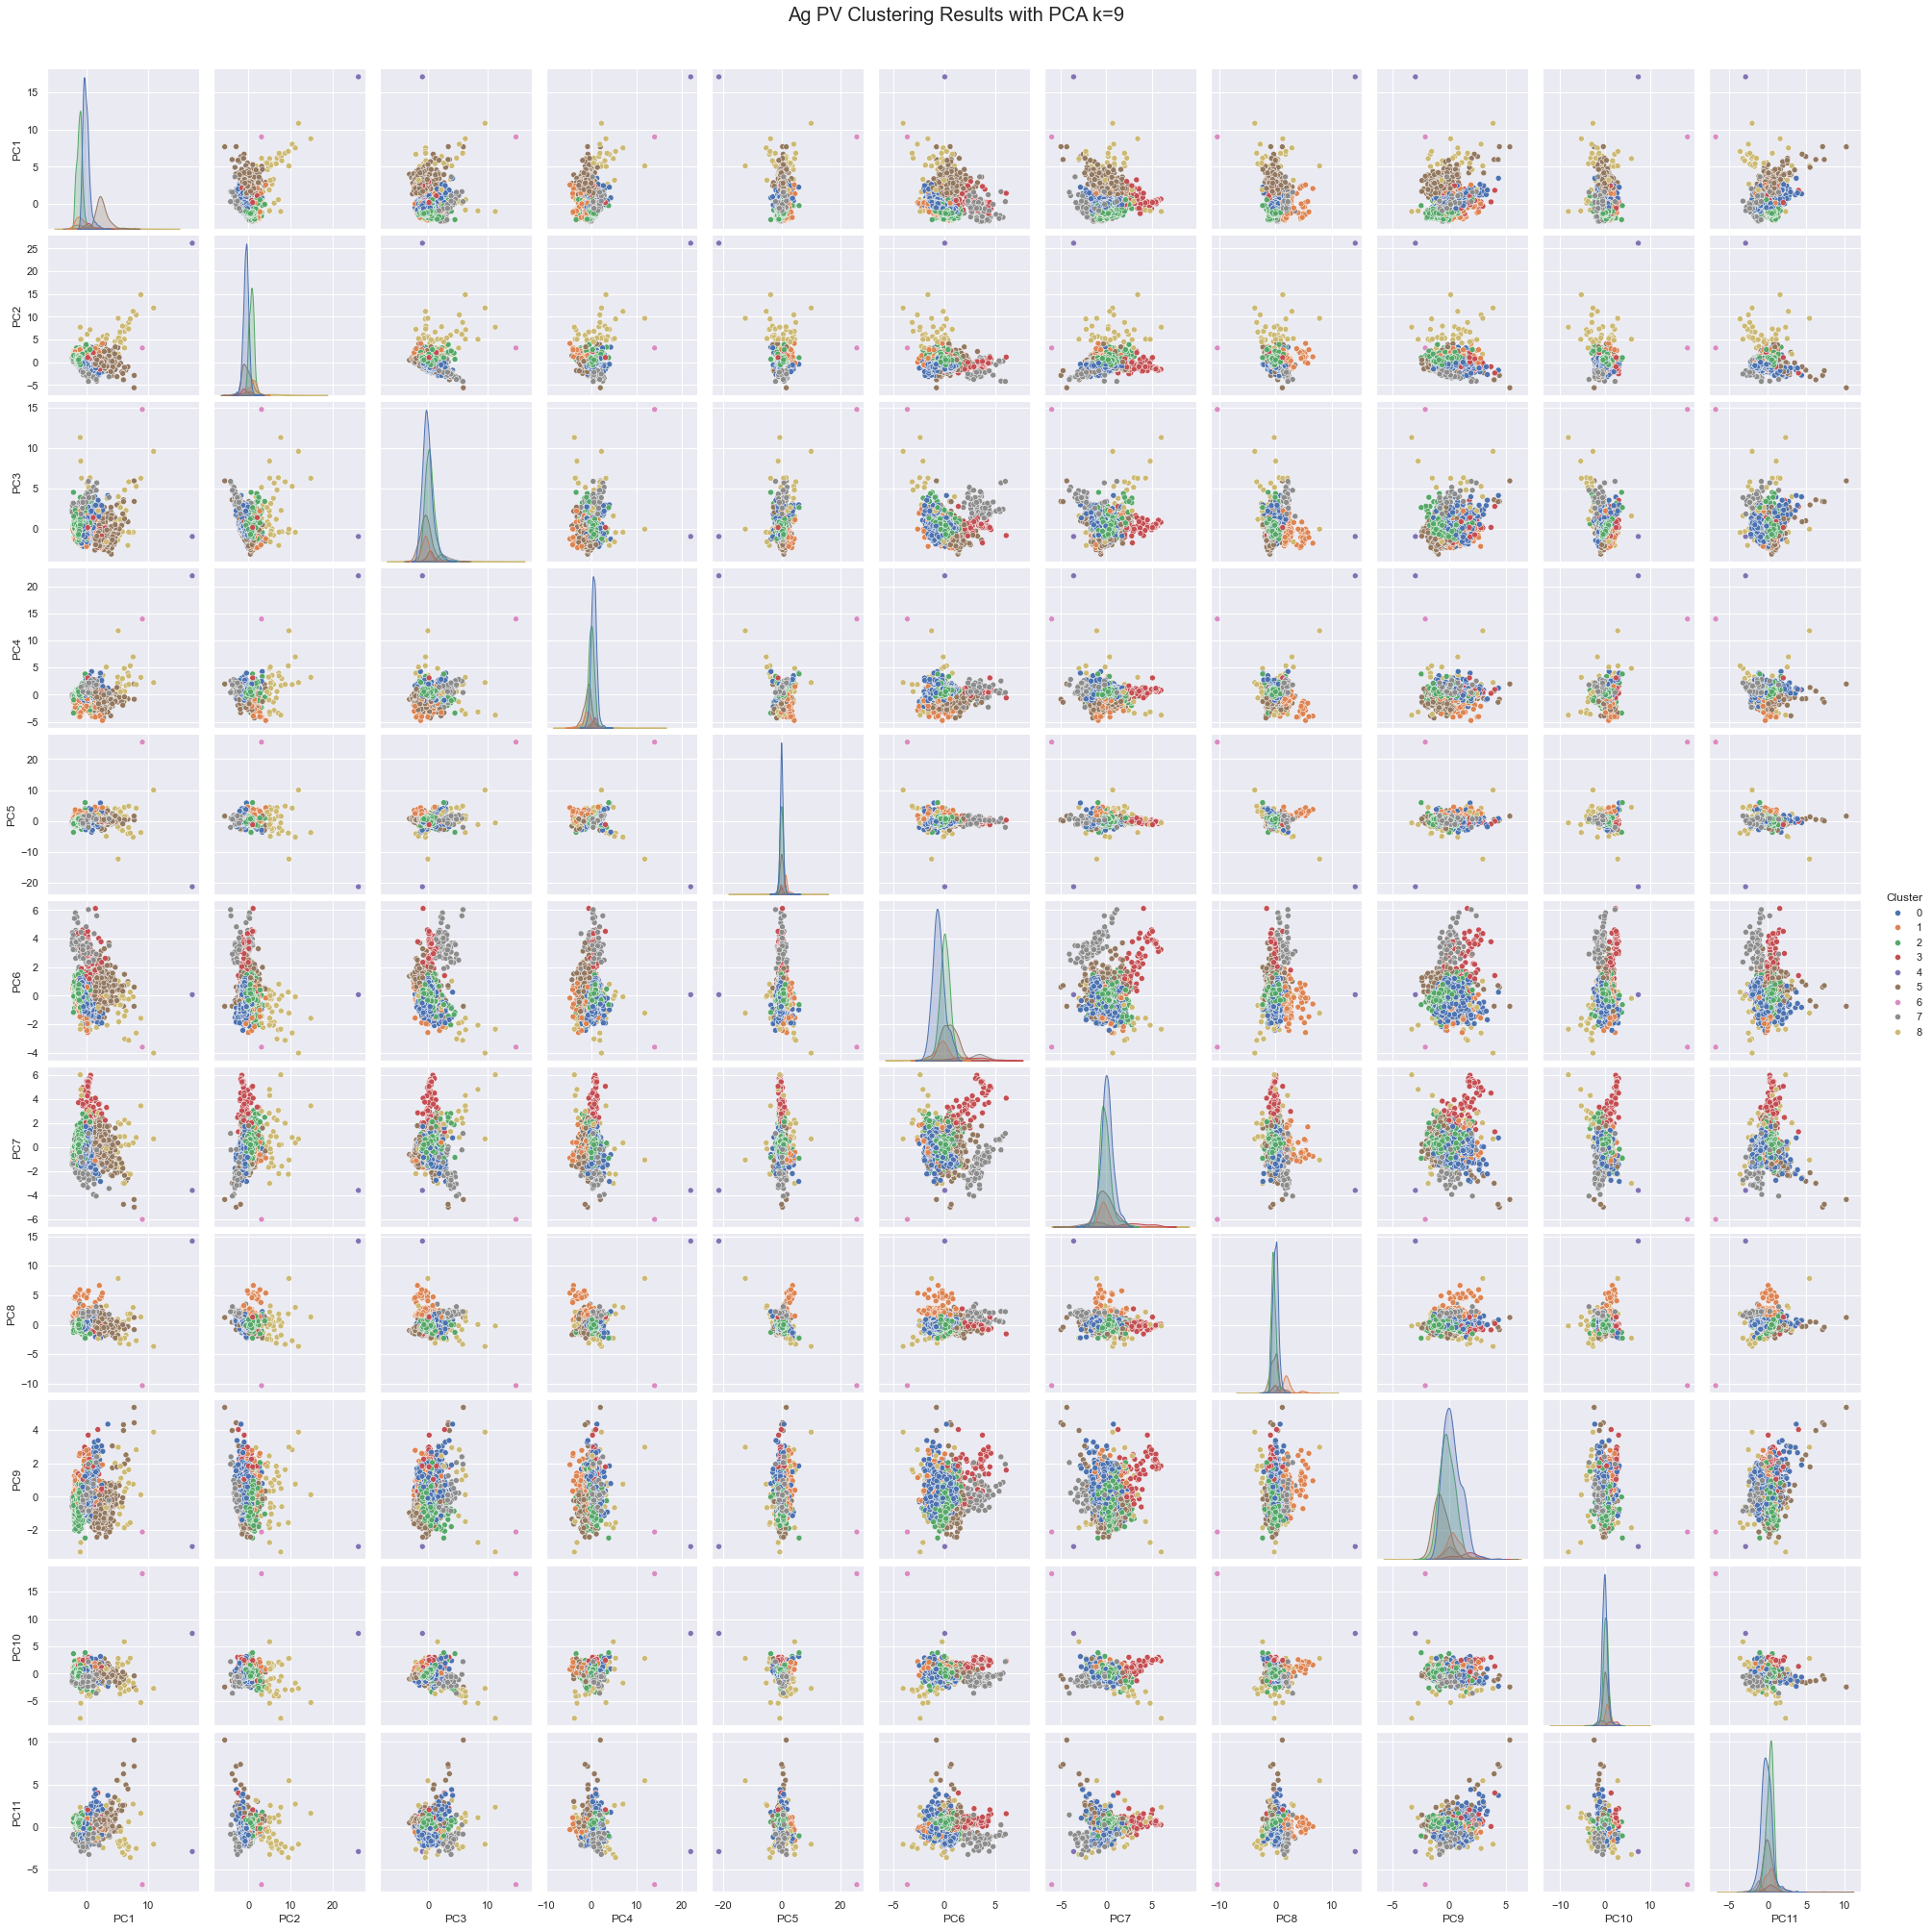

In [268]:
sns.pairplot(cluster_df.iloc[:,-n_comps-1:], hue='Cluster', hue_order=sorted(cluster_df['Cluster'].unique()))
plt.suptitle(f'Ag PV Clustering Results with PCA k={k}', size=20, y=1.02)
plt.savefig(os.path.join(graph_dir, 'agpv_pca_clustering.png'))

## Clustering Analysis
Most of the results seem jumbled together, but there's a few groups that stand out.

Let's have a look at the clusters:

In [276]:
cluster_summary = cluster_df.groupby(['Cluster']).mean()
# drop pc values
cluster_summary = cluster_summary.loc[:, :'PC1']
cluster_summary

TRND_ALRA     HWAV_ALRA  DRGT_ALRA  Energy Burden (% income)  \
Cluster                                                                 
0         0.000026  3.399676e-05   0.001506                  3.685624   
1         0.000036  1.366828e-05   0.002921                  3.087607   
10        0.000024  1.031590e-05   0.000092                  3.289474   
2         0.000020  3.205593e-05   0.003403                  3.127072   
3         0.000034  6.580003e-06   0.001793                  3.587258   
4         0.000006  7.005022e-05   0.021168                  2.142857   
5         0.000860  1.267475e-07   0.010030                  4.200000   
6         0.000033  1.646495e-05   0.001388                  2.960526   
7         0.000004  3.104818e-04   0.059919                  2.637931   
8         0.000098  0.000000e+00   0.000024                  2.000000   
9         0.000021  1.869069e-05   0.003080                  2.594817   

         Avg Farm Net Income ($)  Percent Non-white Cropland  \
Cluster                                                        
0                  190031.339652                    0.251185   
1                   48996.880342                   66.700855   
10                 146759.118421                    2.447368   
2                  108407.585635                    2.309392   
3                   60982.943213                    0.168975   
4                  372826.285714                   50.857143   
5                   33127.400000                    0.000000   
6                   49719.328947                   12.315789   
7                  161251.724138                   40.724138   
8                  149768.000000                   56.000000   
9                   35904.151943                    0.075383   

         Percent Non Investor Owned  Percent Woman-owned Cropland  \
Cluster                                                             
0                          3.561532                     77.872038   
1                          6.768763                     32.540598   
10                        19.877452                     51.842105   
2                          2.440473                     63.828729   
3                          3.106410                     26.045706   
4                          3.197896                     38.428571   
5                          0.000000                      1.600000   
6                         65.609216                     35.631579   
7                          3.659758                     27.413793   
8                         12.411154                     44.000000   
9                          3.323019                     41.942285   

         AgPV_crop_totals  Sheep_goats_total_sales  \
Cluster                                              
0               31.906793             2.353460e+05   
1              141.555556             3.375064e+05   
10               0.526316             5.663947e+05   
2               11.696133             1.966354e+05   
3               38.451524             3.125762e+05   
4            41866.714286             2.614286e+05   
5                0.000000             6.440000e+04   
6              207.736842             2.169474e+05   
7              181.534483             1.475293e+06   
8               70.000000             5.838300e+07   
9              169.055359             2.519635e+05   

         Percent Nonwhite Sheep Goats Producers  \
Cluster                                           
0                                      0.322275   
1                                     49.786325   
10                                     2.171053   
2                                      4.127072   
3                                      0.070637   
4                                     72.714286   
5                                      0.000000   
6                                      5.434211   
7                                     45.034483   
8                                     18.000000   
9            

In [277]:
cluster_df.groupby('Cluster').describe()

TRND_ALRA                                                        \
            count      mean       std           min       25%       50%   
Cluster                                                                   
0           633.0  0.000026  0.000019  4.719247e-07  0.000013  0.000024   
1           468.0  0.000036  0.000034  1.374777e-07  0.000014  0.000027   
10           76.0  0.000024  0.000015  1.913236e-06  0.000013  0.000020   
2           181.0  0.000020  0.000011  0.000000e+00  0.000011  0.000018   
3           722.0  0.000034  0.000040  0.000000e+00  0.000012  0.000026   
4             7.0  0.000006  0.000009  3.962449e-07  0.000001  0.000001   
5             5.0  0.000860  0.000237  6.150803e-04  0.000685  0.000778   
6            76.0  0.000033  0.000030  3.773024e-07  0.000011  0.000028   
7            58.0  0.000004  0.000006  1.339409e-07  0.000001  0.000003   
8             1.0  0.000098       NaN  9.849107e-05  0.000098  0.000098   
9           849.0  0.000021  0.000017  0.000000e+00  0.000007  0.000017   

                            HWAV_ALRA                ...       PC10  \
              75%       max     count          mean  ...        75%   
Cluster                                              ...              
0        0.000034  0.000174     633.0  3.399676e-05  ...  -0.164656   
1        0.000045  0.000236     468.0  1.366828e-05  ...  -0.092195   
10       0.000033  0.000068      76.0  1.031590e-05  ...   0.721260   
2        0.000026  0.000059     181.0  3.205593e-05  ...   1.810027   
3        0.000040  0.000412     722.0  6.580003e-06  ...   0.254722   
4        0.000005  0.000026       7.0  7.005022e-05  ...   2.238941   
5        0.001085  0.001136       5.0  1.267475e-07  ...  11.883506   
6        0.000047  0.000140      76.0  1.646495e-05  ...   1.626346   
7        0.000004  0.000040      58.0  3.104818e-04  ...   2.494161   
8        0.000098  0.000098       1.0  0.000000e+00  ... -10.273828   
9        0.000028  0.000120     849.0  1.869069e-05  ...   0.136672   

                     PC11                                             \
               max  count       mean       std        min        25%   
Cluster                                                                
0         1.429633  633.0   0.043375  0.673625  -2.542012  -0.363708   
1         1.841566  468.0  -0.351385  0.653356  -2.728302  -0.816146   
10        2.395692   76.0  -0.029435  0.696761  -1.879502  -0.508185   
2         5.373860  181.0   0.377849  0.728896  -1.382624  -0.117098   
3         4.053676  722.0   0.114647  0.711633  -1.723009  -0.367422   
4         6.815472    7.0   0.331212  1.174081  -1.187115  -0.472368   
5        12.931455    5.0  -1.218671  1.125511  -2.534523  -2.004807   
6         2.456058   76.0   1.527150  0.986481  -0.161248   0.673978   
7         4.274962   58.0  -0.290361  2.611102  -6.766180  -1.855335   
8       -10.273828    1.0  17.764173       NaN  17.764173  17.764173   
9         1.840461  849.0  -0.147408  0.617865  -2.080559  -0.555314   

                                          
               50%        75%        max  
Cluster                                   
0        -0.001417   0.459811   2.716650  
1        -0.364093   0.039679   2.311896  
10       -0.112274   0.404925   2.138750  
2         0.282485   0.853066   2.866715  
3         0.026278   0.538458   3.758878  
4         0.340520   1.046857   2.016100  
5        -1.242113  -0.634678   0.322765  
6         1.567699   2.386086   3.841577  
7         0.212807   1.276404   5.621886  
8        17.764173  17.764173  17.764173  
9        -0.215782   0.237630   2.523694  

[11 rows x 216 columns]

### Clustering with fewer variables
The index is composed of many uncorreleated independent variables. Dimensionality reduction techniues didn't help much since the variables are uncorrelated. Let's try an equity focused clustering with a subset of the variables

In [278]:
equity_cluster_cols = ['capacity_mw_ac', 
                       #'SOVI_SCORE',
                       'Energy Burden (% income)',
                       #'Percent Minority Owned', 
                       #'AgPV_crop_totals',
                       'Sheep_goats_total_sales',
                       'Percent Nonwhite Sheep Goats Producers'
                      ]
equity_cluster_df = merged_df[equity_cluster_cols]
"""equity_cluster_df = equity_cluster_df.loc[(equity_cluster_df['Sheep_goats_total_sales'] > 0) & \
                                          (equity_cluster_df['capacity_mw_ac'] > 0), :]"""

# equity_cluster_df['Sheep_goats_total_sales'] = np.log(equity_cluster_df['Sheep_goats_total_sales'])
# equity_cluster_df['capacity_mw_ac'] = np.log(equity_cluster_df['capacity_mw_ac'])
# equity_cluster_df.iloc[:, :-1] = np.log(equity_cluster_df.iloc[:, :-1])
equity_cluster_df

capacity_mw_ac  Energy Burden (% income)  Sheep_goats_total_sales  \
FIPS                                                                       
01001    22349.202978                       3.0                    78000   
01003    46948.973155                       2.0                   136000   
01005    43344.657028                       4.0                    22000   
01007    28368.690972                       4.0                    72000   
01009    18483.385380                       3.0                   111000   
...               ...                       ...                      ...   
78030             NaN                       NaN                        0   
02232             NaN                       NaN                        0   
11031             NaN                       NaN                        0   
02                NaN                       NaN                        0   
02261             NaN                       NaN                        0   

       Percent Nonwhite Sheep Goats Producers  
FIPS                                           
01001                                    73.0  
01003                                     0.0  
01005                                    11.0  
01007                                     0.0  
01009                                     0.0  
...                                       ...  
78030                                     0.0  
02232                                     0.0  
11031                                     0.0  
02                                        0.0  
02261                                     0.0  

[3235 rows x 4 columns]

In [279]:
X_norm = StandardScaler().fit_transform(equity_cluster_df)

k_values = range(2,21)
# clustering
WCSS = [] # holds within cluster sum of squares for eack value of k

for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=123)
    kmeans.fit(X_norm)
    WCSS.append(kmeans.inertia_)
    
plt.figure(figsize=(10,6), dpi=300)
g = sns.lineplot(x=k_values, y=WCSS, marker='o', linestyle='--')
g.set_xticks(k_values)
g.set_xlabel('K clusters')
g.set_ylabel('WCSS')

k = 5
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=123)
kmeans.fit(X_norm)

# add labels from kmeans
scaled_cluster_df = pd.DataFrame(X_norm, columns=equity_cluster_df.columns, index=equity_cluster_df.index)
equity_cluster_df['Cluster'] = kmeans.labels_
equity_cluster_df['Cluster'] = equity_cluster_df['Cluster'].astype(str)

equity_cluster_df

ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [280]:
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs

bandwidth = estimate_bandwidth(X_norm, quantile=0.8)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
c = ms.fit(X_norm)

equity_cluster_df['Cluster'] = c.labels_
equity_cluster_df['Cluster'] = equity_cluster_df['Cluster'].astype(str)

equity_cluster_df

ValueError: Input contains NaN.

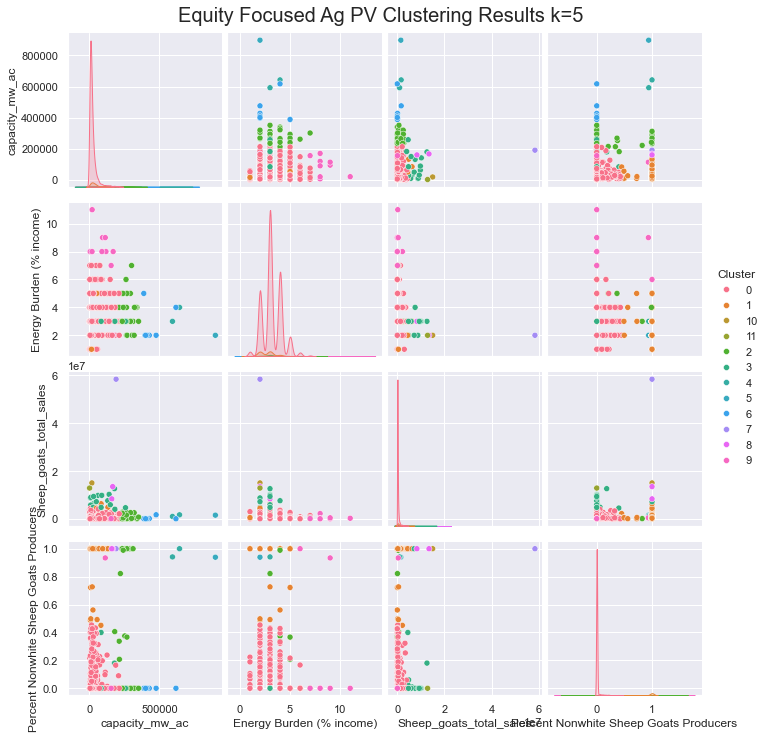

In [294]:
sns.pairplot(equity_cluster_df, hue='Cluster', hue_order=sorted(equity_cluster_df['Cluster'].unique()))
plt.suptitle(f'Equity Focused Ag PV Clustering Results k={k}', size=20, y=1.02)
plt.savefig(os.path.join(graph_dir, 'equity_agpv_pca_clustering.png'))

In [269]:
equity_cluster_df[equity_cluster_df['Cluster'] == '0']

capacity_mw_ac  Energy Burden (% income)  Sheep_goats_total_sales  \
FIPS                                                                       
04001   642890.582501                       4.0                  1651000   
04003   287109.296404                       3.0                   631000   
04005   898649.593988                       2.0                  1511000   
04007    99254.854730                       3.0                    45000   
04009   193371.836811                       3.0                        0   
...               ...                       ...                      ...   
56025   212886.939749                       2.0                  2078000   
56027   176565.725872                       5.0                    61000   
56029    91458.074630                       4.0                  2193000   
56031   107401.216358                       5.0                   105000   
56037   401041.398994                       2.0                        0   

       Percent Nonwhite Sheep Goats Producers Cluster  
FIPS                                                   
04001                                1.000000       0  
04003                                1.000000       0  
04005                                0.939185       0  
04007                                0.000000       0  
04009                                0.000000       0  
...                                       ...     ...  
56025                                0.000000       0  
56027                                0.000000       0  
56029                                0.000000       0  
56031                                0.000000       0  
56037                                0.000000       0  

[147 rows x 5 columns]

In [268]:
equity_cluster_df.groupby('Cluster').mean()

capacity_mw_ac  Energy Burden (% income)  Sheep_goats_total_sales  \
Cluster                                                                      
0         199503.642248                  3.435374             5.309116e+05   
1          16380.047965                  2.665420             2.686189e+05   
2          35316.212194                  2.715232             6.458609e+05   
3         190355.716993                  2.000000             5.838300e+07   
4          19334.579686                  4.312222             1.416344e+05   
5          81914.417515                  2.750000             1.033608e+07   

         Percent Nonwhite Sheep Goats Producers  
Cluster                                          
0                                      0.109550  
1                                      0.013315  
2                                      0.996351  
3                                      1.000000  
4                                      0.003108  
5                                      0.181699

In [242]:
equity_cluster_df.corr()

capacity_mw_ac  \
capacity_mw_ac                                1.000000   
Energy Burden (% income)                      0.083811   
Percent Minority Owned                        0.142842   
AgPV_crop_totals                              0.002171   
Sheep_goats_total_sales                       0.156034   
Percent Nonwhite Sheep Goats Producers        0.189113   
Cluster                                      -0.160997   

                                        Energy Burden (% income)  \
capacity_mw_ac                                          0.083811   
Energy Burden (% income)                                1.000000   
Percent Minority Owned                                  0.054850   
AgPV_crop_totals                                       -0.075113   
Sheep_goats_total_sales                                -0.071569   
Percent Nonwhite Sheep Goats Producers                 -0.116285   
Cluster                                                 0.402071   

                                        Percent Minority Owned  \
capacity_mw_ac                                        0.142842   
Energy Burden (% income)                              0.054850   
Percent Minority Owned                                1.000000   
AgPV_crop_totals                                     -0.010154   
Sheep_goats_total_sales                               0.004992   
Percent Nonwhite Sheep Goats Producers                0.075516   
Cluster                                               0.306412   

                                        AgPV_crop_totals  \
capacity_mw_ac                                  0.002171   
Energy Burden (% income)                       -0.075113   
Percent Minority Owned                         -0.010154   
AgPV_crop_totals                                1.000000   
Sheep_goats_total_sales                         0.015636   
Percent Nonwhite Sheep Goats Producers          0.024433   
Cluster                                         0.253450   

                                        Sheep_goats_total_sales  \
capacity_mw_ac                                         0.156034   
Energy Burden (% income)                              -0.071569   
Percent Minority Owned                                 0.004992   
AgPV_crop_totals                                       0.015636   
Sheep_goats_total_sales                                1.000000   
Percent Nonwhite Sheep Goats Producers                 0.152161   
Cluster                                                0.033867   

                                        Percent Nonwhite Sheep Goats Producers  \
capacity_mw_ac                                                        0.189113   
Energy Burden (% income)                                             -0.116285   
Percent Minority Owned                                                0.075516   
AgPV_crop_totals                                                      0.024433   
Sheep_goats_total_sales                                               0.152161   
Percent Nonwhite Sheep Goats Producers                                1.000000   
Cluster                                                               0.454291   

                                         Cluster  
capacity_mw_ac                         -0.160997  
Energy Burden (% income)                0.402071  
Percent Minority Owned                  0.306412  
AgPV_crop_totals                        0.253450  
Sheep_goats_total_sales                 0.033867  
Percent Nonwhite Sheep Goats Producers  0.454291  
Cluster                                 1.000000

In [243]:
merged_df.columns

Index(['county', 'state', 'capacity_mw_ac', 'capacity_mw_dc', 'RESL_SCORE',
       'SOVI_SCORE', 'TRND_ALRA', 'TRND_RISKV', 'TRND_RISKS', 'HWAV_ALRA',
       'HWAV_RISKV', 'HWAV_RISKS', 'HAIL_ALRA', 'HAIL_RISKV', 'HAIL_RISKS',
       'DRGT_ALRA', 'DRGT_RISKV', 'DRGT_RISKS', 'Energy Burden (% income)',
       'Avg Farm Net Income ($)', 'Percent Minority Owned',
       'Percent Non Investor Owned', 'Value_veggies', 'Undisclosed_veggies',
       'Value_berries', 'Undisclosed_berries', 'AgPV_crop_totals',
       'Sheep_goats_total_sales', 'Undisclosed_goats_sheep_totals',
       'Percent Nonwhite Sheep Goats Producers',
       'Undisclosed_goats_sheep_producers', 'tonne_co2_per_person',
       'SolarPanelLandUse', 'Negative Net Farm Income'],
      dtype='object')